<img src = "../../Data/bgsedsc_0.jpg">

# Extended Decision Trees, Ensembles and Neural Networks prediction project

The aim of this project is to predict the length of stay of a patient that is entering an ICU (Intensive Care Unit). The dataset comes from MIMIC project (https://mimic.physionet.org/) which refers to the Medical Information Mart for Intensive Care. 

The performance metric used is *RMSE* (root mean squared error).

## Modules and auxiliar functions import

The relevant modules are loaded and the auxiliar functions from *helper_functions* are imported. It is also set a random seed to ensure reproducibility and it is checked the current working directory.

In [2]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(os.path.dirname(currentdir))
sys.path.insert(1, parentdir)
from utils.helper_functions import *

import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
import ipywidgets
import xgboost as xgb
import matplotlib.pyplot as plt
import mlens
import lime
import shap
import lime.lime_tabular

from sklearn.neighbors import KNeighborsRegressor
from sklearn import preprocessing
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV
from mlens.ensemble import SuperLearner, Subsemble
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from collections import Counter
from sklearn.ensemble import StackingRegressor
from scipy.stats import skew
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from tensorflow import keras
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras import regularizers
from keras.callbacks import History


import warnings
warnings.filterwarnings('ignore')

SEED=3123
np.random.seed(SEED)

!pwd

[MLENS] backend: threading


/Users/bertacanal/Desktop


# Data load

The **training dataset** is imported as a pandas DataFrame and the first 5 rows are displayed to get an overview of the structure and the contents. The dataset consists of 20885 observations and 41 columns.

In [3]:
data=pd.read_csv('/Users/bertacanal/Desktop/cml23-length-of-stay-prediction-dt-ensembles/mimic_train.csv')
print(data.shape)
data.head()

(20885, 41)


HOSPITAL_EXPIRE_FLAG  subject_id  hadm_id  icustay_id  HeartRate_Min  \
0                     0       55440   195768      228357           89.0   
1                     0       76908   126136      221004           63.0   
2                     0       95798   136645      296315           81.0   
3                     0       40708   102505      245557           76.0   
4                     0       28424   127337      225281            NaN   

   HeartRate_Max  HeartRate_Mean  SysBP_Min  SysBP_Max  SysBP_Mean  ...  \
0          145.0      121.043478       74.0      127.0  106.586957  ...   
1          110.0       79.117647       89.0      121.0  106.733333  ...   
2           98.0       91.689655       88.0      138.0  112.785714  ...   
3          128.0       98.857143       84.0      135.0  106.972973  ...   
4            NaN             NaN        NaN        NaN         NaN  ...   

          Diff  ADMISSION_TYPE  INSURANCE           RELIGION  MARITAL_STATUS  \
0 -61961.78470       EMERGENCY   Medicare  PROTESTANT QUAKER          SINGLE   
1 -43146.18378       EMERGENCY    Private       UNOBTAINABLE         MARRIED   
2 -42009.96157       EMERGENCY   Medicare  PROTESTANT QUAKER       SEPARATED   
3 -43585.37922        ELECTIVE   Medicare      NOT SPECIFIED         WIDOWED   
4 -50271.76602       EMERGENCY   Medicare             JEWISH         WIDOWED   

                ETHNICITY                  DIAGNOSIS  ICD9_diagnosis  \
0                   WHITE     GASTROINTESTINAL BLEED            5789   
1                   WHITE  ESOPHAGEAL FOOD IMPACTION           53013   
2  BLACK/AFRICAN AMERICAN             UPPER GI BLEED           56983   
3                   WHITE          HIATAL HERNIA/SDA            5533   
4                   WHITE             ABDOMINAL PAIN           56211   

   FIRST_CAREUNIT     LOS  
0            MICU  4.5761  
1            MICU  0.7582  
2            MICU  3.7626  
3            SICU  3.8734  
4           TSICU  5.8654  

[5 rows x 41 columns]

The **test dataset** is imported as a pandas DataFrame and the first 5 rows are displayed to get an overview of the structure and the contents. This dataset will be used to produce predictions and consists of 5221 observations and 39 columns. This dataset does not include the variable *'LOS'*, therefore, a copy of this dataset is renamed as *X_test*.

In [4]:
data_test=pd.read_csv('/Users/bertacanal/Desktop/cml23-length-of-stay-prediction-dt-ensembles/mimic_test_los.csv')
X_test = data_test.copy()
print(X_test.shape)
X_test.sort_values('icustay_id').head()

(5221, 39)


subject_id  hadm_id  icustay_id  HeartRate_Min  HeartRate_Max  \
4930       93535   121562      200011           56.0           82.0   
1052       30375   177945      200044            NaN            NaN   
3412       73241   149216      200049           54.0           76.0   
1725       99052   129142      200063           85.0          102.0   
981        51698   190004      200081           82.0          133.0   

      HeartRate_Mean  SysBP_Min  SysBP_Max  SysBP_Mean  DiasBP_Min  ...  \
4930       71.205128      123.0      185.0  156.411765        37.0  ...   
1052             NaN        NaN        NaN         NaN         NaN  ...   
3412       64.833333       95.0      167.0  114.545455        33.0  ...   
1725       92.560976       91.0      131.0  108.365854        42.0  ...   
981        94.323529       86.0      143.0  111.093750        47.0  ...   

                ADMITTIME         Diff  ADMISSION_TYPE  INSURANCE  \
4930  2188-08-05 20:27:00 -64881.43517       EMERGENCY   Medicare   
1052  2135-07-07 16:13:00 -46540.62661       EMERGENCY   Medicare   
3412  2118-08-14 22:27:00 -38956.85890       EMERGENCY    Private   
1725  2141-03-09 23:19:00 -47014.25437       EMERGENCY   Medicaid   
981   2142-02-23 06:56:00 -47377.26087       EMERGENCY   Medicare   

           RELIGION  MARITAL_STATUS              ETHNICITY  \
4930         JEWISH          SINGLE                  WHITE   
1052       CATHOLIC         WIDOWED                  WHITE   
3412         JEWISH         MARRIED                  WHITE   
1725  NOT SPECIFIED          SINGLE  UNKNOWN/NOT SPECIFIED   
981           OTHER         MARRIED             PORTUGUESE   

                     DIAGNOSIS  ICD9_diagnosis  FIRST_CAREUNIT  
4930  ASTHMA;COPD EXACERBATION           49322            MICU  
1052                HEAD BLEED           85220            SICU  
3412    HEPATIC ENCEPHALOPATHY            5722            MICU  
1725         TYPE A DISSECTION           44101            CSRU  
981         PULMONARY EMBOLISM           41519             CCU  

[5 rows x 39 columns]

# Preprocessing of the data

## Meaning of the variables

Each observation of the training dataset corresponds to the ICU stay of a patient. The outcome to predict is the column *LOS*, which indicates the length of the stay measured in days. There are ID columns related to the ICU stay (*hadm_id* and *icustay_id*) and to the patient (*subject_id*). Other columns refer to the vitals of the patient (when entering the ICU) and general information. The specific meaning of each feature is specified in the table below (extracted from the file *mimic_patient_metadata.xlsx*).

In [5]:
meaning=pd.read_excel('/Users/bertacanal/Desktop/cml23-length-of-stay-prediction-dt-ensembles/mimic_patient_metadata.xlsx', header = 4)
pd.set_option('display.max_colwidth', None)
meaning

Field  \
0   HOSPITAL_EXPIRE_FLAG   
1             subject_id   
2                hadm_id   
3             icustay_id   
4          HeartRate_Min   
5          HeartRate_Max   
6         HeartRate_Mean   
7              SysBP_Min   
8              SysBP_Max   
9             SysBP_Mean   
10            DiasBP_Min   
11            DiasBP_Max   
12           DiasBP_Mean   
13            MeanBP_Min   
14            MeanBP_Max   
15           MeanBP_Mean   
16          RespRate_Min   
17          RespRate_Max   
18         RespRate_Mean   
19             TempC_Min   
20             TempC_Max   
21            TempC_Mean   
22              SpO2_Min   
23              SpO2_Max   
24             SpO2_Mean   
25           Glucose_Min   
26           Glucose_Max   
27          Glucose_Mean   
28                GENDER   
29                   DOB   
30                   DOD   
31             ADMITTIME   
32             DISCHTIME   
33             DEATHTIME   
34                  Diff   
35        ADMISSION_TYPE   
36             INSURANCE   
37              RELIGION   
38        MARITAL_STATUS   
39             ETHNICITY   
40             DIAGNOSIS   
41        ICD9_diagnosis   
42        FIRST_CAREUNIT   
43                   LOS   

                                                                  Description  
0                                 1 if patient died during this hospital stay  
1                                                          Patient identifier  
2                                                    Hospital stay identifier  
3                                                         ICU stay identifier  
4                                                                  Heart Rate  
5                                                                  Heart Rate  
6                                                                  Heart Rate  
7                                                     Systolic Blood Pressure  
8                                                     Systolic Blood Pressure  
9                                                     Systolic Blood Pressure  
10                                                   Diastolic Blood Pressure  
11                                                   Diastolic Blood Pressure  
12                                                   Diastolic Blood Pressure  
13                                                        Mean Blood Pressure  
14                                                        Mean Blood Pressure  
15                                                        Mean Blood Pressure  
16                                                           Respiration Rate  
17                                                           Respiration Rate  
18                                                           Respiration Rate  
19                                                        Temperature Celsius  
20                                                        Temperature Celsius  
21                                                        Temperature Celsius  
22                                                                     Oxygen  
23                                                                     Oxygen  
24                                                                     Oxygen  
25                                                                    Glucose  
26                                                                    Glucose  
27                                                                    Glucose  
28                                                                     Gender  
29                                                              Date of Birth  
30                                                              Date of Death  
31                                                          Admision datetime  
32                                                         Discharge datetime  
33                                    

## Variable *LOS*

The description of the variable *LOS* indicates that the mean corresponds to 3.7, the median to 2.02, and the minimum and maximum values are 0.06 and 101.74, respectively.

In [6]:
data['LOS'].describe()

count    20885.000000
mean         3.701046
std          5.175721
min          0.056600
25%          1.165400
50%          2.020800
75%          3.915800
max        101.739000
Name: LOS, dtype: float64

The distribution of the variable *LOS* is positively skewed, which is also suggested by the previous information since the mean (which is more affected by outliers) is higher than the median.

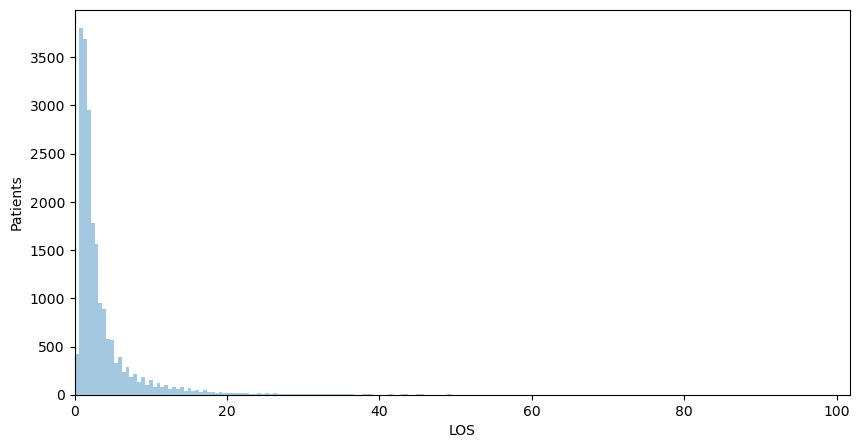

In [7]:
plt.figure(figsize=(10,5))
plt.xlim(0,data['LOS'].max())
plt.xlabel('LOS')
plt.ylabel('Patients')
sns.distplot(data['LOS'],bins=200,kde=False)
plt.show()

## Addition of metadata: Number of Comorbidities

As shown in the description of the variables, the *ICD9_diagnosis* column includes the main cause/disease of patient condition. However, a patient can have co-ocurrent diseases (comorbodities). The file containing the secondary codes is *MIMIC_diagnoses.csv* and some merge is required to consider these additional diagnoses. It is assumed that all of the comorbidities were diagnosed on the first day of the patient in the ICU.

The first information included from metadata will be the number of comorbidities of each patient in each of the ICU stays, since it could have predictive ability on the number of days a patient should stay in the ICU.

In [8]:
MIMIC_diagnoses = pd.read_csv('/Users/bertacanal/Desktop/cml23-length-of-stay-prediction-dt-ensembles/extra_data/MIMIC_diagnoses.csv')
MIMIC_diagnoses.head()

SUBJECT_ID  HADM_ID  SEQ_NUM ICD9_CODE
0         256   108811      1.0     53240
1         256   108811      2.0     41071
2         256   108811      3.0     53560
3         256   108811      4.0     40390
4         256   108811      5.0      5859

Firstly, the metadata is grouped by "SUBJECT_ID" and "HADM_ID", and then the maximum value of the column "SEQ_NUM" is computed. This statistic indicates the number of comorbidities in each ICU stay. 

In [9]:
number_comorbidities_patient = MIMIC_diagnoses.groupby(["SUBJECT_ID", "HADM_ID"]).max()["SEQ_NUM"].reset_index()
number_comorbidities_patient = number_comorbidities_patient.rename({"SEQ_NUM": "number_comorbidities"}, axis=1)
number_comorbidities_patient

SUBJECT_ID  HADM_ID  number_comorbidities
0               2   163353                   3.0
1               3   145834                   9.0
2               4   185777                   9.0
3               5   178980                   3.0
4               6   107064                   8.0
...           ...      ...                   ...
58971       99985   176670                  13.0
58972       99991   151118                  17.0
58973       99992   197084                  12.0
58974       99995   137810                  17.0
58975       99999   113369                   5.0

[58976 rows x 3 columns]

The minimum number of comorbidities corresponds to 1 and the maximum is 39. The mean is around 11 comorbidities and the median corresponds to 9:

In [10]:
number_comorbidities_patient["number_comorbidities"].describe()

count    58929.000000
mean        11.047192
std          6.462537
min          1.000000
25%          7.000000
50%          9.000000
75%         15.000000
max         39.000000
Name: number_comorbidities, dtype: float64

The information extracted is merged both to the training and testing set:

In [11]:
data = pd.merge(data, number_comorbidities_patient, left_on=["subject_id", "hadm_id"], right_on = ["SUBJECT_ID", "HADM_ID"], how = "left").drop(["SUBJECT_ID", "HADM_ID"], axis=1)
X_test = pd.merge(X_test, number_comorbidities_patient, left_on=["subject_id", "hadm_id"], right_on = ["SUBJECT_ID", "HADM_ID"], how = "left").drop(["SUBJECT_ID", "HADM_ID"], axis=1)

## Addition of metadata: Statistics from ICD9 codes

The second information included from the metadata will be the statistics extracted from the ICD9 codes.

The first step is to add the *LOS* column to the *MIMIC_diagnoses* file. Since it is merged on the ICU stay, each entry referring to the same ICU stay will have the same value for the *LOS* column:

In [12]:
los = data[["LOS", "subject_id", "hadm_id"]]
MIMIC_diagnoses = pd.merge(MIMIC_diagnoses, los, left_on=["SUBJECT_ID", "HADM_ID"], right_on = ["subject_id", "hadm_id"], how = "left").drop(["subject_id", "hadm_id"], axis=1)

In [13]:
MIMIC_diagnoses.head()

SUBJECT_ID  HADM_ID  SEQ_NUM ICD9_CODE     LOS
0         256   108811      1.0     53240  1.7219
1         256   108811      2.0     41071  1.7219
2         256   108811      3.0     53560  1.7219
3         256   108811      4.0     40390  1.7219
4         256   108811      5.0      5859  1.7219

Then, the mean of the *LOS* columns will be computed per each ICD9 code and this information will be merged to the *MIMIC_diagnoses* file as a new column named *MEAN_LOS*.

In [14]:
statistics = MIMIC_diagnoses.groupby(["ICD9_CODE"]).mean()["LOS"].reset_index()
statistics = statistics.rename({"LOS": "MEAN_LOS"}, axis=1)
statistics.head()

ICD9_CODE  MEAN_LOS
0      0030    3.3066
1      0031    3.7503
2      0038    3.2981
3      0039    2.9672
4      0041    0.9287

In [15]:
MIMIC_diagnoses = pd.merge(MIMIC_diagnoses, statistics, on = ["ICD9_CODE"], how = "left")

In [16]:
MIMIC_diagnoses.head()

SUBJECT_ID  HADM_ID  SEQ_NUM ICD9_CODE     LOS  MEAN_LOS
0         256   108811      1.0     53240  1.7219  4.263924
1         256   108811      2.0     41071  1.7219  4.499102
2         256   108811      3.0     53560  1.7219  2.736041
3         256   108811      4.0     40390  1.7219  3.857329
4         256   108811      5.0      5859  1.7219  3.895319

For each ICU stay, the following statistics are computed using the *MEAN_LOS* column: maximum, minimum, sum, 10th percentile, first quartile, third quartile, 90th percentile, mean, median and standard deviation.

Note that the standard deviation from *pandas* is normalized by N-1 by default. Therefore, since the minimum number of the variable *number_comorbidities* is 1, it means that there are patients with a single comorbidity, which will cause getting missing values when computing the standard deviation from that patients. This can be changed using the *ddof* argument and setting it to 0.

In [17]:
more_statistics_hadmid = (
    MIMIC_diagnoses.groupby("HADM_ID")["MEAN_LOS"]
    .agg(['max', 'min', 'sum', lambda x: x.quantile(0.1), lambda x: x.quantile(0.25), 
          lambda x: x.quantile(0.75), lambda x: x.quantile(0.9), 'mean', 'median', lambda x: x.std(ddof=0)])
    .reset_index())
rename_stats = {"<lambda_0>": "q10", "<lambda_1>": "q25", "<lambda_2>": "q75", "<lambda_3>": "q90", "<lambda_4>": "std"}
more_statistics_hadmid = more_statistics_hadmid.rename(rename_stats, axis=1)

In [18]:
more_statistics_hadmid.head()

HADM_ID       max       min        sum       q10       q25       q75  \
0   100001  5.590355  2.437944  55.567898  2.530198  2.640222  3.900375   
1   100003  4.565325  3.068523  35.696968  3.336857  3.507838  4.505459   
2   100006  7.381652  3.447769  42.188622  3.583209  4.018384  5.020139   
3   100007  8.569929  3.628801  31.335467  4.246627  5.173365  6.991090   
4   100009  4.979556  2.434800  63.940397  2.636852  3.333658  3.824853   

        q90      mean    median       std  
0  4.395007  3.472994  3.470669  0.845297  
1  4.550106  3.966330  4.141353  0.536944  
2  5.615023  4.687625  4.571196  1.100147  
3  7.938393  6.267093  6.972282  1.701843  
4  4.327234  3.552244  3.531937  0.616797

In [19]:
data.head()

HOSPITAL_EXPIRE_FLAG  subject_id  hadm_id  icustay_id  HeartRate_Min  \
0                     0       55440   195768      228357           89.0   
1                     0       76908   126136      221004           63.0   
2                     0       95798   136645      296315           81.0   
3                     0       40708   102505      245557           76.0   
4                     0       28424   127337      225281            NaN   

   HeartRate_Max  HeartRate_Mean  SysBP_Min  SysBP_Max  SysBP_Mean  ...  \
0          145.0      121.043478       74.0      127.0  106.586957  ...   
1          110.0       79.117647       89.0      121.0  106.733333  ...   
2           98.0       91.689655       88.0      138.0  112.785714  ...   
3          128.0       98.857143       84.0      135.0  106.972973  ...   
4            NaN             NaN        NaN        NaN         NaN  ...   

   ADMISSION_TYPE  INSURANCE           RELIGION  MARITAL_STATUS  \
0       EMERGENCY   Medicare  PROTESTANT QUAKER          SINGLE   
1       EMERGENCY    Private       UNOBTAINABLE         MARRIED   
2       EMERGENCY   Medicare  PROTESTANT QUAKER       SEPARATED   
3        ELECTIVE   Medicare      NOT SPECIFIED         WIDOWED   
4       EMERGENCY   Medicare             JEWISH         WIDOWED   

                ETHNICITY                  DIAGNOSIS  ICD9_diagnosis  \
0                   WHITE     GASTROINTESTINAL BLEED            5789   
1                   WHITE  ESOPHAGEAL FOOD IMPACTION           53013   
2  BLACK/AFRICAN AMERICAN             UPPER GI BLEED           56983   
3                   WHITE          HIATAL HERNIA/SDA            5533   
4                   WHITE             ABDOMINAL PAIN           56211   

   FIRST_CAREUNIT     LOS  number_comorbidities  
0            MICU  4.5761                  17.0  
1            MICU  0.7582                   3.0  
2            MICU  3.7626                  14.0  
3            SICU  3.8734                  15.0  
4           TSICU  5.8654                  16.0  

[5 rows x 42 columns]

The statistics computed are merged both to the training and testing dataset:

In [20]:
data = pd.merge(data, more_statistics_hadmid, left_on=["hadm_id"], right_on = ["HADM_ID"], how = "left").drop(["HADM_ID"], axis=1)
X_test = pd.merge(X_test, more_statistics_hadmid, left_on=["hadm_id"], right_on = ["HADM_ID"], how = "left").drop(["HADM_ID"], axis=1)

In [21]:
data.head()

HOSPITAL_EXPIRE_FLAG  subject_id  hadm_id  icustay_id  HeartRate_Min  \
0                     0       55440   195768      228357           89.0   
1                     0       76908   126136      221004           63.0   
2                     0       95798   136645      296315           81.0   
3                     0       40708   102505      245557           76.0   
4                     0       28424   127337      225281            NaN   

   HeartRate_Max  HeartRate_Mean  SysBP_Min  SysBP_Max  SysBP_Mean  ...  \
0          145.0      121.043478       74.0      127.0  106.586957  ...   
1          110.0       79.117647       89.0      121.0  106.733333  ...   
2           98.0       91.689655       88.0      138.0  112.785714  ...   
3          128.0       98.857143       84.0      135.0  106.972973  ...   
4            NaN             NaN        NaN        NaN         NaN  ...   

         max       min         sum       q10       q25       q75       q90  \
0   7.381652  3.499846   73.770483  3.561374  3.853161  4.415805  5.028428   
1   6.641739  1.109420    9.283488  1.194002  1.320874  4.087034  5.619857   
2   8.659720  3.041571   70.330355  3.292316  3.866827  6.277919  6.939499   
3   9.706866  2.862015   60.433065  3.134970  3.450924  3.808504  4.696546   
4  10.790989  3.695159  182.764946  3.882383  4.221803  6.212449  8.908093   

       mean    median       std  
0  4.339440  4.201232  0.922693  
1  3.094496  1.532329  2.514215  
2  5.023597  4.322307  1.630490  
3  4.028871  3.493876  1.592394  
4  5.711405  5.094307  2.033343  

[5 rows x 52 columns]

## Binning ICD9 codes

There are diagnoses categories for the ICD9 codes (source: https://en.wikipedia.org/wiki/List_of_ICD-9_codes) that allows to produce bins:

* 001–139: infectious and parasitic diseases
* 140–239: neoplasms
* 240–279: endocrine, nutritional and metabolic diseases, and immunity disorders
* 280–289: diseases of the blood and blood-forming organs
* 290–319: mental disorders
* 320–389: diseases of the nervous system and sense organs
* 390–459: diseases of the circulatory system
* 460–519: diseases of the respiratory system
* 520–579: diseases of the digestive system
* 580–629: diseases of the genitourinary system
* 630–679: complications of pregnancy, childbirth, and the puerperium
* 680–709: diseases of the skin and subcutaneous tissue
* 710–739: diseases of the musculoskeletal system and connective tissue
* 740–759: congenital anomalies
* 760–779: certain conditions originating in the perinatal period
* 780–799: symptoms, signs, and ill-defined conditions
* 800–999: injury and poisoning
* E and V codes: external causes of injury and supplemental classification

This preprocessing is included in a project whose source is https://github.com/daniel-codes/hospital-los-predictor/blob/master/hospital_los_prediction.ipynb. Therefore, computations to bin the ICD9 codes are extracted from this source, although they have been properly understood before adding them into this project.

Working with bins of the ICD9 code to compute the statistics from the previous section instead of working with the ICD9 code itself decreases the out-sample predictive accuracy, since the RMSE in the testing set decreases. Therefore, the bins from the ICD9 code will only be used as a exploratory analysis but will not be incorporated further in the analysis.

E and V codes are filtered out and replaced with the value 999 to easen the computations. Note that the code 999 corresponds to complications of medical care not elsewhere classified:

In [22]:
MIMIC_diagnoses.rename(columns={'HADM_ID': 'hadm_id'}, inplace=True)

MIMIC_diagnoses['RECODE'] = MIMIC_diagnoses['ICD9_CODE']
MIMIC_diagnoses['RECODE'] = MIMIC_diagnoses['RECODE'][~MIMIC_diagnoses['RECODE'].str.contains("[a-zA-Z]").fillna(False)]
MIMIC_diagnoses['RECODE'].fillna(value='999', inplace=True)

With the aim of binning the ICD9 codes, only the first three characters of each code are considered, which are converted into integers:

In [23]:
MIMIC_diagnoses['RECODE'] = MIMIC_diagnoses['RECODE'].str.slice(start=0, stop=3, step=1)
MIMIC_diagnoses['RECODE'] = MIMIC_diagnoses['RECODE'].astype(int)

The following code aims to convert the ICD9 codes into bins attaining the classification previously mentioned, which are indicated in a new column called *CAT*.

In [24]:
icd9_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390), 
               (390, 460), (460, 520), (520, 580), (580, 630), (630, 680), (680, 710),
               (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000)]

diag_dict = {0: 'INFECTIOUS', 1: 'NEOPLASMS', 2: 'ENDOCRINE', 3: 'BLOOD',
             4: 'MENTAL', 5: 'NERVOUS', 6: 'CIRCULATORY', 7: 'RESPIRATORY',
             8: 'DIGESTIVE', 9: 'GENITOURINARY', 10: 'PREGNANCY', 11: 'SKIN', 
             12: 'MUSCULAR', 13: 'CONGENITAL', 14: 'PRENATAL', 15: 'MISC',
             16: 'INJURY'}

for num, cat_range in enumerate(icd9_ranges):
    MIMIC_diagnoses['RECODE'] = np.where(MIMIC_diagnoses['RECODE'].between(cat_range[0],cat_range[1]), 
            num, MIMIC_diagnoses['RECODE'])
    
MIMIC_diagnoses['RECODE'] = MIMIC_diagnoses['RECODE']
MIMIC_diagnoses['CAT'] = MIMIC_diagnoses['RECODE'].replace(diag_dict)

In [25]:
MIMIC_diagnoses.head()

SUBJECT_ID  hadm_id  SEQ_NUM ICD9_CODE     LOS  MEAN_LOS  RECODE  \
0         256   108811      1.0     53240  1.7219  4.263924       8   
1         256   108811      2.0     41071  1.7219  4.499102       6   
2         256   108811      3.0     53560  1.7219  2.736041       8   
3         256   108811      4.0     40390  1.7219  3.857329       6   
4         256   108811      5.0      5859  1.7219  3.895319       9   

             CAT  
0      DIGESTIVE  
1    CIRCULATORY  
2      DIGESTIVE  
3    CIRCULATORY  
4  GENITOURINARY

The following graph plot the average length of stay by diagnosis category. It can be seen that respiratory and infectious diagnoses present the higher average length of stay for the given data. Instead, neoplasms and muscular diagnosis present the lower average.

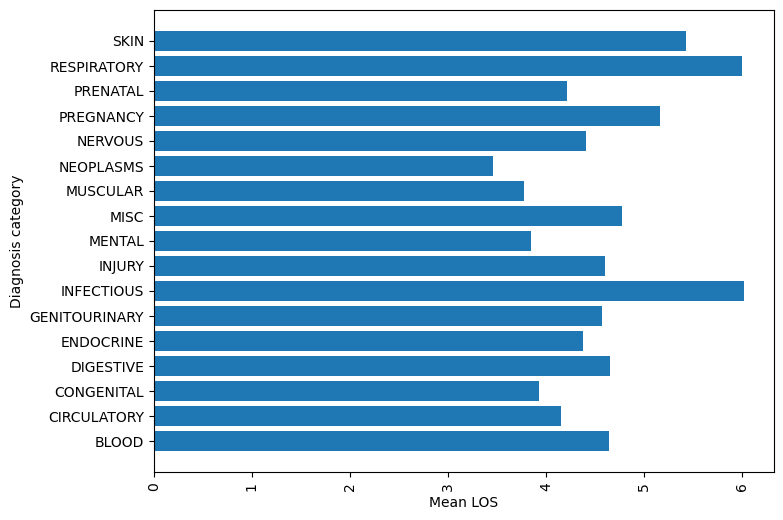

In [26]:
mean_by_category = MIMIC_diagnoses.groupby('CAT').mean()['LOS'].reset_index()
mean_by_category = mean_by_category.rename({'LOS': 'MEAN'}, axis=1)

plt.figure(figsize=(8, 6))
plt.barh(mean_by_category['CAT'], mean_by_category['MEAN'])
plt.xlabel('Mean LOS')
plt.ylabel('Diagnosis category')
plt.xticks(rotation=90)
plt.show()

## Visits to the ICU

The number of previous visits of a specific patient to the ICU can be a significant indicator to the length of its stay in the ICU. 

Therefore, a new variable *visits_ICU* is created which counts the cumulative number of occurrences for each unique "subject_id" based on the order of admission times (*ADMITTIME*) of each subject. 

In [27]:
data["visits_ICU"] = data.sort_values(['subject_id', 'ADMITTIME']).groupby(["subject_id"]).cumcount() + 1
X_test["visits_ICU"] = X_test.sort_values(['subject_id', 'ADMITTIME']).groupby(["subject_id"]).cumcount() + 1

In [28]:
data[["subject_id", "ADMITTIME", "visits_ICU"]].sort_values(["subject_id", "ADMITTIME"]).iloc[:13]

subject_id            ADMITTIME  visits_ICU
18310          23  2157-10-18 19:34:00           1
17908          34  2191-02-23 05:23:00           1
9591           36  2134-05-10 11:30:00           1
727            85  2167-07-25 18:49:00           1
16007         109  2141-03-27 21:08:00           1
13738         109  2141-05-24 14:47:00           2
4002          109  2141-09-05 20:04:00           3
12883         109  2141-09-11 10:12:00           4
17983         109  2141-09-18 10:32:00           5
8222          109  2141-10-13 23:10:00           6
1283          109  2141-11-18 14:00:00           7
6733          109  2141-11-24 16:11:00           8
13431         109  2141-12-08 01:40:00           9

## Dicernment between *X_train* and *y_train*

From the training dataset it should be distinguished between *X_train* (including all the features) and *y_train* (including the variable *LOS*).

In [29]:
X_train = data.drop(['LOS'], axis=1)
y_train = data['LOS']

X_train.head()

HOSPITAL_EXPIRE_FLAG  subject_id  hadm_id  icustay_id  HeartRate_Min  \
0                     0       55440   195768      228357           89.0   
1                     0       76908   126136      221004           63.0   
2                     0       95798   136645      296315           81.0   
3                     0       40708   102505      245557           76.0   
4                     0       28424   127337      225281            NaN   

   HeartRate_Max  HeartRate_Mean  SysBP_Min  SysBP_Max  SysBP_Mean  ...  \
0          145.0      121.043478       74.0      127.0  106.586957  ...   
1          110.0       79.117647       89.0      121.0  106.733333  ...   
2           98.0       91.689655       88.0      138.0  112.785714  ...   
3          128.0       98.857143       84.0      135.0  106.972973  ...   
4            NaN             NaN        NaN        NaN         NaN  ...   

        min         sum       q10       q25       q75       q90      mean  \
0  3.499846   73.770483  3.561374  3.853161  4.415805  5.028428  4.339440   
1  1.109420    9.283488  1.194002  1.320874  4.087034  5.619857  3.094496   
2  3.041571   70.330355  3.292316  3.866827  6.277919  6.939499  5.023597   
3  2.862015   60.433065  3.134970  3.450924  3.808504  4.696546  4.028871   
4  3.695159  182.764946  3.882383  4.221803  6.212449  8.908093  5.711405   

     median       std  visits_ICU  
0  4.201232  0.922693           1  
1  1.532329  2.514215           1  
2  4.322307  1.630490           1  
3  3.493876  1.592394           1  
4  5.094307  2.033343           2  

[5 rows x 52 columns]

The following code aims to compare the dimensions from *X_train* and *X_test*. As expected, the number of observations of the training dataset is higher than the testing dataset since we want to feed the model with as much data as possible to find and learn meaningful patterns.

In [30]:
dimensions = [X_train.shape, X_test.shape]
dimensions_df = pd.DataFrame([(int(dim[0]), int(dim[1])) for dim in dimensions], index= ["X_train", "X_test"], columns=["Rows", "Columns"])
dimensions_df

Rows  Columns
X_train  20885       52
X_test    5221       51

To know which columns appear in *X_train* but not in *X_test* it is done a set difference operation. It is useful to know the columns in each dataset for the step related to drop the features not used in the model. As seen in the output, the columns that only appear in *X_train* correspond to *'HOSPITAL_EXPIRE_FLAG'*.

In [31]:
columns_X_train = set(X_train.columns)
columns_X_test = set(X_test.columns)

columns_only_in_X_train = columns_X_train - columns_X_test
columns_only_in_X_train

{'HOSPITAL_EXPIRE_FLAG'}

## Creation of the *AGE* variable

The age could have an impact on the predicted length of the stay of a that is entering an ICU, however, there is no specific feature in the dataset referring to the age. An alternative could be to subtract the *DOB* (Date of Birth) from the *DOD* (Date of Death) but it has to be disregarded since the *DOD* is not known in the first day of a patient in an ICU and moreover it does not allow to compute the age of the patients who survive.

Therefore, the procedure followed consists on subtracting the *DOB* (Date of Birth) from the *ADMITTIME* (Admision datetime) since this results on the age of the patient in the admission day. These two date columns are converted to datatime objects and then the age is computed using the *relativedelta* function.

#### In the training dataset

In [32]:
X_train['DOB'] = pd.to_datetime(X_train['DOB'], format='%Y-%m-%d %H:%M:%S')
X_train['ADMITTIME'] = pd.to_datetime(X_train['ADMITTIME'], format='%Y-%m-%d %H:%M:%S')

X_train['AGE'] = X_train.apply(lambda row: relativedelta(row['ADMITTIME'], row['DOB']).years, axis=1)

X_train['AGE'].describe()

count    20885.000000
mean        74.884606
std         55.755731
min         15.000000
25%         53.000000
50%         65.000000
75%         78.000000
max        310.000000
Name: AGE, dtype: float64

#### In the testing dataset

In [33]:
X_test['DOB'] = pd.to_datetime(X_test['DOB'], format='%Y-%m-%d %H:%M:%S')
X_test['ADMITTIME'] = pd.to_datetime(X_test['ADMITTIME'], format='%Y-%m-%d %H:%M:%S')

X_test['AGE'] = X_test.apply(lambda row: relativedelta(row['ADMITTIME'], row['DOB']).years, axis=1)

X_test['AGE'].describe()

count    5221.000000
mean       75.090021
std        54.973065
min        15.000000
25%        53.000000
50%        66.000000
75%        78.000000
max       310.000000
Name: AGE, dtype: float64

#### Adjustments to the variable *AGE*

The quartiles and the mean seem to be reasonable. However, since the maximum value of the column *AGE* corresponds to 310 in both the training and testing data, an adjustment is needed.  The problem is that the age of patients older than 89 has been fixed to 300 at their first admission (Source: https://mimic.mit.edu/docs/iii/about/time/). 

In [34]:
print('Patients older than 89:')
print(X_train[X_train['AGE'] > 89]['AGE'])

Patients older than 89:
10       300
13       300
30       300
53       300
56       300
        ... 
20837    300
20844    300
20853    300
20874    300
20883    300
Name: AGE, Length: 1107, dtype: int64


Therefore, it is reasonable to readjust the *AGE* by assigning 89 years as the maximum patient's age:

In [35]:
X_train['AGE'] = X_train['AGE'].apply(lambda age: min(age, 89))
X_test['AGE'] = X_test['AGE'].apply(lambda age: min(age, 89))

## Features selection

Vital signs are considered important in medical care and disease diagnosis. They include heart rate, blood pressure, respiratory rate and body temperature. For example, a significant increase or decrease in heart rate may be an indicator of heart problems, high blood pressure can increase the risk of cardiovascular diseases, changes in respiratory rate can indicate respiratory or cardiovascular problems and a significant increase or decrease in temperature can be a sign of infection. Therefore, features related to the minimum, maximum and mean of the vital signs are included in the model since supposedly they can contribute significantly to predict the length of stay of a patient entering the ICU.

Both the main disease and comorbidities play significant roles in determining a patient's length of stay in the ICU. The main disease's severity directly influences the risk of mortality. Comorbidities, on the other hand, add complexity to the patient's health profile: they can complicate treatment, reduce the body's ability to respond to stress and weaken the immune system. Therefore, features related to the main disease and comorbodities are included in the model. Note that not only is crucial to consider the specific comorbidity but also how many the patient has. Moreover, the patient's history of previous ICU visits should also be considered when forecasting their length of stay in the ICU.

Gender differences can impact how certain diseases manifest and respond to treatment, potentially influencing recovery times. Meanwhile, age is a significant factor, with older patients often having more complex medical histories and decreased physiological reserves, which can prolong their stay. Instead, younger patients might recover more swiftly due to better overall health.

Patients admitted to the ICU in an emergency, such as after a sudden cardiac arrest or trauma, may have a higher initial severity of illness, which may correlate with prolonged ICU stays. The first care unit to which a patient is assigned can provide valuable insights into the initial assessment of the patient's condition and potential factors that may influence their potential length of stay. At the same time, the type of insurance also infers because it affects the access to care and the care quality, since patients with certain insurance plans may receive care at facilities with higher ICU quality ratings, potentially leading to better outcomes and this translates into a shorter length of stay. Marital status can also be an influenting factor through factors such as social support, advocacy and emotional well-being. For example, married patients may benefit from spousal support or better mental health, advocating for better care decisions, and potentially influencing a shorter length of stay due to improved overall support system.

Although healthcare models often prioritize clinical needs over ethnicity and religion, these factors can still influence a patient's journey. Cultural differences and beliefs within ethnic or religious groups might affect treatment adherence and support networks, potentially impacting a patient's length of stay in the ICU.

#### From the training dataset

The features not included in the model are dropped. From the training dataset we should exclude the ID variables (*subject_id*, *hadm_id* and *icustay_id*), the features we don't know the first day of a patient in an ICU (*HOSPITAL_EXPIRE_FLAG*) and the variables we consider not to infer (*ETHNICITY*, *RELIGION* and *Diff*). In addition, the variables used to create the *AGE* variable, in particular *DOB* and *ADMITTIME*, are also excluded since its information is already contained by the model with the created *AGE* variable. Regarding *ICD9_diagnosis* and the text variable *DIAGNOSIS* they are also removed since its information is already added through the statistics from metadata.

Note: *subject_id* will be used to fill missing values with forward/backward filling from previous visits. Therefore, this specific column will be removed in a further step.

In [36]:
X_train = X_train.drop(['ICD9_diagnosis','hadm_id', 'icustay_id', 'DOB', 'ADMITTIME', 'Diff', 'HOSPITAL_EXPIRE_FLAG', 'DIAGNOSIS'], axis=1)
print(X_train.shape)
X_train.head()

(20885, 45)


subject_id  HeartRate_Min  HeartRate_Max  HeartRate_Mean  SysBP_Min  \
0       55440           89.0          145.0      121.043478       74.0   
1       76908           63.0          110.0       79.117647       89.0   
2       95798           81.0           98.0       91.689655       88.0   
3       40708           76.0          128.0       98.857143       84.0   
4       28424            NaN            NaN             NaN        NaN   

   SysBP_Max  SysBP_Mean  DiasBP_Min  DiasBP_Max  DiasBP_Mean  ...  \
0      127.0  106.586957        42.0        90.0    61.173913  ...   
1      121.0  106.733333        49.0        74.0    64.733333  ...   
2      138.0  112.785714        45.0        67.0    56.821429  ...   
3      135.0  106.972973        30.0        89.0    41.864865  ...   
4        NaN         NaN         NaN         NaN          NaN  ...   

          sum       q10       q25       q75       q90      mean    median  \
0   73.770483  3.561374  3.853161  4.415805  5.028428  4.339440  4.201232   
1    9.283488  1.194002  1.320874  4.087034  5.619857  3.094496  1.532329   
2   70.330355  3.292316  3.866827  6.277919  6.939499  5.023597  4.322307   
3   60.433065  3.134970  3.450924  3.808504  4.696546  4.028871  3.493876   
4  182.764946  3.882383  4.221803  6.212449  8.908093  5.711405  5.094307   

        std  visits_ICU  AGE  
0  0.922693           1   69  
1  2.514215           1   42  
2  1.630490           1   68  
3  1.592394           1   74  
4  2.033343           2   79  

[5 rows x 45 columns]

#### From the testing dataset

The features not included in the model are dropped. From the testing dataset we exclude the ID variables (*subject_id*, *hadm_id* and *icustay_id*) and the variables we consider not to infer (*ETHNICITY*, *RELIGION* and *Diff*). In addition, the variables used to create the *AGE* variable, in particular *DOB* and *ADMITTIME*, are also excluded since its information is already contained by the model with the created *AGE* variable. Regarding *ICD9_diagnosis* and the text variable *DIAGNOSIS* they are also removed since its information is already added through the statistics from metadata.

As seen before, *X_test* does not contain the column *'HOSPITAL_EXPIRE_FLAG'*. Therefore, this columns should not be droped from the testing dataset.

Note: *subject_id* will be used to fill missing values with forward/backward filling from previous visits. Therefore, this specific column will be removed in a further step.

In [37]:
X_test = X_test.drop(['ICD9_diagnosis','hadm_id', 'icustay_id', 'DOB','ADMITTIME', 'Diff', 'DIAGNOSIS'], axis=1)
print(X_test.shape)
X_test.head()

(5221, 45)


subject_id  HeartRate_Min  HeartRate_Max  HeartRate_Mean  SysBP_Min  \
0       64058           58.0           90.0       85.244898       77.0   
1       55871           91.0          145.0      115.055556       73.0   
2       42892          106.0          132.0      117.750000       93.0   
3       66629           72.0          105.0       83.627119       72.0   
4       79851           85.0          124.0       98.600000       86.0   

   SysBP_Max  SysBP_Mean  DiasBP_Min  DiasBP_Max  DiasBP_Mean  ...  \
0      153.0   98.490909        40.0        77.0    52.018182  ...   
1      143.0  101.210526        42.0        86.0    65.578947  ...   
2      137.0  116.222222        51.0        76.0    66.703704  ...   
3      168.0  126.981818        39.0        99.0    62.854545  ...   
4      144.0  110.666667        52.0       133.0    72.833333  ...   

          sum       q10       q25       q75       q90      mean    median  \
0   81.151600  3.026671  3.426930  4.364695  5.202311  4.057580  3.889511   
1   69.472542  3.628801  3.933268  7.818446  8.659720  6.315686  6.467405   
2   61.872560  3.287106  4.020278  6.056308  7.406148  5.156047  5.049418   
3   66.723293  3.388696  3.490163  4.668356  5.282656  4.170206  3.863811   
4  136.973273  3.623327  3.799999  5.491607  7.924229  5.073084  4.479669   

        std  visits_ICU  AGE  
0  1.065368           1   81  
1  2.607172           1   48  
2  1.572231           2   42  
3  0.814069           1   84  
4  1.779936           2   52  

[5 rows x 45 columns]

After dropping the variables, it can be observed that the number of columns on both *X_train* and *X_test* is equal:

In [38]:
dimensions = [X_train.shape, X_test.shape]
dimensions_df = pd.DataFrame([(int(dim[0]), int(dim[1])) for dim in dimensions], index= ["X_train", "X_test"], columns=["Rows", "Columns"])
dimensions_df

Rows  Columns
X_train  20885       45
X_test    5221       45

The following code creates a list of the names of the categorical and numerical columns:

In [39]:
categorical_features_names = ['GENDER', 'INSURANCE', 'ADMISSION_TYPE', 'MARITAL_STATUS', 'RELIGION', 'ETHNICITY', 'FIRST_CAREUNIT']

numerical_features_names = ['max', 'min', 'sum', 'median', 'mean', 'q10', 'q25', 'q75', 'q90','std','HeartRate_Min','HeartRate_Max','HeartRate_Mean','SysBP_Min','SysBP_Max','SysBP_Mean','DiasBP_Min','DiasBP_Max','DiasBP_Mean','MeanBP_Min','MeanBP_Max','MeanBP_Mean','RespRate_Min','RespRate_Max','RespRate_Mean','TempC_Min','TempC_Max','TempC_Mean','SpO2_Min','SpO2_Max','SpO2_Mean','Glucose_Min','Glucose_Max','Glucose_Mean','number_comorbidities','visits_ICU','AGE']

## Exploratory analysis of categorical features

The following output provides information about the categorical features: *count* corresponds to the number of non-null values, *unique* indicates the number of unique categories in the feature, *top* refers to the most frequent category and *freq* corresponds to the frequency in which the top category occur.

In [40]:
categorical_summary = []

for feature in categorical_features_names:
    summary = X_train[feature].describe()
    categorical_summary.append(summary)

categorical_summary_table = pd.DataFrame(categorical_summary, index=categorical_features_names)
categorical_summary_table

count  unique        top   freq
GENDER          20885       2          M  11759
INSURANCE       20885       5   Medicare  11718
ADMISSION_TYPE  20885       3  EMERGENCY  17817
MARITAL_STATUS  20163       7    MARRIED   9664
RELIGION        20885      17   CATHOLIC   7655
ETHNICITY       20885      41      WHITE  15112
FIRST_CAREUNIT  20885       5       MICU   8640

As can be seen in the output of the previous code, the categorical variables with a low cardinality consist on *GENDER*, *INSURANCE*, *ADMISSION_TYPE*, *MARITAL_STATUS* and *FIRST_CAREUNIT*. Instead, the cardinality of *RELIGION* and *ETHNICITY* is higher.

The output is also useful to identify that most of the patients from the training dataset are males, the most frequent marital status is to be married, the insurance is Medicare, the admission type is emergency and the first ICU assigned is Medical Intensive Care Unit (MICU).

Focusing on the low cardinality categorical features, let's see more in detail how many observations are included in each category.

In [41]:
pd.DataFrame(X_train['GENDER'].value_counts())

GENDER
M   11759
F    9126

In [42]:
pd.DataFrame(X_train['FIRST_CAREUNIT'].value_counts())

FIRST_CAREUNIT
MICU             8640
SICU             3961
CSRU             3127
TSICU            2645
CCU              2512

In [43]:
pd.DataFrame(X_train['INSURANCE'].value_counts())

INSURANCE
Medicare        11718
Private          6245
Medicaid         2117
Government        611
Self Pay          194

In [44]:
pd.DataFrame(X_train['ADMISSION_TYPE'].value_counts())

ADMISSION_TYPE
EMERGENCY           17817
ELECTIVE             2848
URGENT                220

In [45]:
pd.DataFrame(X_train['ETHNICITY'].value_counts())

ETHNICITY
WHITE                                                         15112
BLACK/AFRICAN AMERICAN                                         1977
UNABLE TO OBTAIN                                                577
UNKNOWN/NOT SPECIFIED                                           568
HISPANIC OR LATINO                                              562
OTHER                                                           489
ASIAN                                                           265
PATIENT DECLINED TO ANSWER                                      175
HISPANIC/LATINO - PUERTO RICAN                                  155
ASIAN - CHINESE                                                 146
BLACK/CAPE VERDEAN                                              126
WHITE - RUSSIAN                                                 117
BLACK/HAITIAN                                                    72
HISPANIC/LATINO - DOMINICAN                                      59
ASIAN - ASIAN INDIAN                                             58
WHITE - OTHER EUROPEAN                                           50
MULTI RACE ETHNICITY                                             50
PORTUGUESE                                                       40
WHITE - BRAZILIAN                                                33
ASIAN - VIETNAMESE                                               28
BLACK/AFRICAN                                                    26
MIDDLE EASTERN                                                   24
HISPANIC/LATINO - GUATEMALAN                                     24
WHITE - EASTERN EUROPEAN                                         18
HISPANIC/LATINO - CUBAN                                          17
ASIAN - FILIPINO                                                 16
ASIAN - CAMBODIAN                                                14
AMERICAN INDIAN/ALASKA NATIVE                                    13
HISPANIC/LATINO - SALVADORAN                                     13
HISPANIC/LATINO - MEXICAN                                         8
HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)                        7
SOUTH AMERICAN                                                    7
CARIBBEAN ISLAND                                                  6
ASIAN - KOREAN                                                    6
NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER                         6
ASIAN - JAPANESE                                                  6
HISPANIC/LATINO - COLOMBIAN                                       5
ASIAN - OTHER                                                     3
ASIAN - THAI                                                      3
HISPANIC/LATINO - HONDURAN                                        2
AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE          2

In [46]:
pd.DataFrame(X_train['RELIGION'].value_counts())

RELIGION
CATHOLIC                    7655
NOT SPECIFIED               5398
PROTESTANT QUAKER           2753
JEWISH                      1840
UNOBTAINABLE                1515
OTHER                        702
EPISCOPALIAN                 288
GREEK ORTHODOX               178
CHRISTIAN SCIENTIST          164
BUDDHIST                     109
MUSLIM                        74
UNITARIAN-UNIVERSALIST        54
JEHOVAH'S WITNESS             45
ROMANIAN EAST. ORTH           41
HINDU                         38
7TH DAY ADVENTIST             30
HEBREW                         1

In [47]:
pd.DataFrame(X_train['MARITAL_STATUS'].value_counts())

MARITAL_STATUS
MARRIED                      9664
SINGLE                       5910
WIDOWED                      2819
DIVORCED                     1413
SEPARATED                     240
UNKNOWN (DEFAULT)             103
LIFE PARTNER                   14

## Handling high cardinality categorical variables

There are some categories from the high cardinality categorical variables with a low number of observations. 

Regarding *RELIGION*, the categories that includes less than 4% of the total observations in *X_train* are combined into 'OTHERS':

In [48]:
religion_counts = X_train['RELIGION'].value_counts()
categories_to_replace = religion_counts[religion_counts < 0.04 * len(X_train)].index

X_train.loc[X_train['RELIGION'].isin(categories_to_replace), 'RELIGION'] = 'OTHER'
X_test.loc[X_test['RELIGION'].isin(categories_to_replace), 'RELIGION'] = 'OTHER'

In [49]:
pd.DataFrame(X_train['RELIGION'].value_counts())

RELIGION
CATHOLIC               7655
NOT SPECIFIED          5398
PROTESTANT QUAKER      2753
JEWISH                 1840
OTHER                  1724
UNOBTAINABLE           1515

For the variable *ETHNICITY*, its categories are logically combined to reduced the number of dummy variables we have to produce:

In [50]:
for df in [X_train, X_test]:
    
    df['ETHNICITY'] = df['ETHNICITY'].replace(['ASIAN', 'ASIAN - CHINESE', 'ASIAN - ASIAN INDIAN', 'ASIAN - VIETNAMESE', 'ASIAN - FILIPINO', 'ASIAN - CAMBODIAN',
                                                     'ASIAN - JAPANESE', 'ASIAN - THAI', 'ASIAN - OTHER', 'ASIAN - KOREAN'
                                                      ], 'ASIAN')

    df['ETHNICITY'] = df['ETHNICITY'].replace(['HISPANIC 0R LATINO', 'HISPANIC/LATINO - PUERTO RICAN', 'HISPANIC/LATINO - DOMINICAN',
                                                     'HISPANIC/LATINO - GUATEMALAN', 'HISPANIC/LATINO - CUBAN', 'HISPANIC/LATINO - SALVADORAN',
                                                     'HISPANIC/LATINO - MEXICAN', 'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)', 'HISPANIC/LATINO - COLOMBIAN',
                                                     'HISPANIC/LATINO - HONDURAN', 'SOUTH AMERICAN'
                                                     ], 'HISPANIC OR LATINO')

    df['ETHNICITY'] = df['ETHNICITY'].replace(['WHITE', 'WHITE - RUSSIAN', 'WHITE - OTHER EUROPEAN', 'WHITE - EASTERN EUROPEAN',
                                                     'WHITE - BRAZILIAN'
                                                     ], 'WHITE')

    df['ETHNICITY'] = df['ETHNICITY'].replace(['BLACK/AFRICAN', 'BLACK/AFRICAN AMERICAN', 'BLACK/CAPE VERDEAN', 'BLACK/HAITIAN'
                                                     ], 'BLACK')

    df['ETHNICITY'] = df['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'UNKNOWN/NOT SPECIFIED', 'PATIENT DECLINED TO ANSWER'
                                                     ], 'UNKNOWN')

    df['ETHNICITY'] = df['ETHNICITY'].replace(['AMERICAN INDIAN/ALASKA NATIVE', 'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE',
                                                     'CARIBBEAN ISLAND', 'MIDDLE EASTERN', 'OTHER', 'PORTUGUESE', 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER',
                                                     'MULTI RACE ETHNICITY'
                                                     ], 'OTHER')

In [51]:
pd.DataFrame(X_train['ETHNICITY'].value_counts())

ETHNICITY
WHITE                   15330
BLACK                    2201
UNKNOWN                  1320
HISPANIC OR LATINO        859
OTHER                     630
ASIAN                     545

Regarding *MARITAL_STATUS*, the category 'SEPARATED' is combined into 'DIVORCED' and the category 'LIFE_PARTNER' is combined into 'MARRIED':

In [52]:
X_train['MARITAL_STATUS'].replace('SEPARATED', 'DIVORCED', inplace=True)
X_test['MARITAL_STATUS'].replace('SEPARATED', 'DIVORCED', inplace=True)

X_train['MARITAL_STATUS'].replace('LIFE PARTNER', 'MARRIED', inplace=True)
X_test['MARITAL_STATUS'].replace('LIFE PARTNER', 'MARRIED', inplace=True)

In [53]:
pd.DataFrame(X_train['MARITAL_STATUS'].value_counts())

MARITAL_STATUS
MARRIED                      9678
SINGLE                       5910
WIDOWED                      2819
DIVORCED                     1653
UNKNOWN (DEFAULT)             103

The distribution of the low cardinality categorical features are depicted in the following graphs:

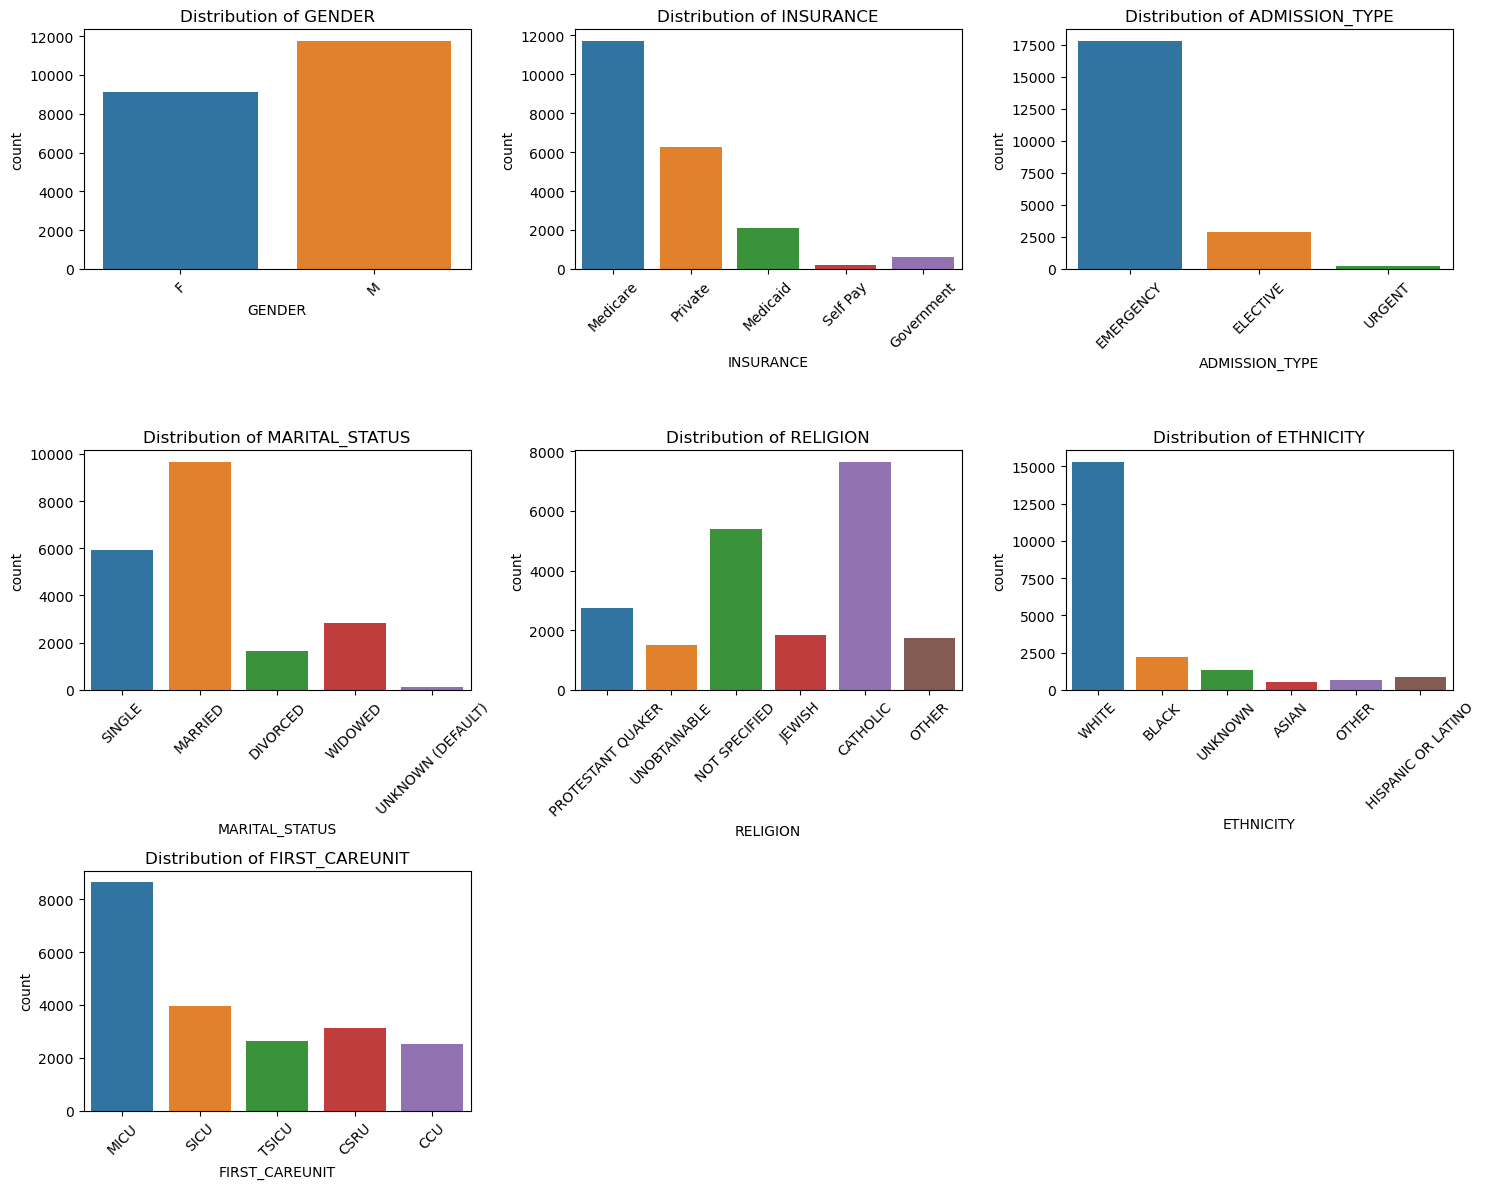

In [54]:
fcols = 3
frows = (len(categorical_features_names) + fcols - 1) // fcols
plt.figure(figsize=(15, 4 * frows))

for i, col in enumerate(categorical_features_names):
    plt.subplot(frows, fcols, i + 1)
    sns.countplot(data=X_train, x=col)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Handling missing data from categorical features

The first step is to check the null values per categorical feature for both the X_train and X_test:

In [55]:
X_train[categorical_features_names].isnull().sum()

GENDER              0
INSURANCE           0
ADMISSION_TYPE      0
MARITAL_STATUS    722
RELIGION            0
ETHNICITY           0
FIRST_CAREUNIT      0
dtype: int64

In [56]:
X_test[categorical_features_names].isnull().sum()

GENDER              0
INSURANCE           0
ADMISSION_TYPE      0
MARITAL_STATUS    180
RELIGION            0
ETHNICITY           0
FIRST_CAREUNIT      0
dtype: int64

The previous output indicates that the only categorical feature with missing data corresponds to *MARITAL_STATUS*. To missing data from this feature will be logically combined with the 'UNKNOWN (DEFAULT)' category:

In [57]:
X_train['MARITAL_STATUS'] = X_train['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')
X_test['MARITAL_STATUS'] = X_test['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')

In [58]:
pd.DataFrame(X_train['MARITAL_STATUS'].value_counts())

MARITAL_STATUS
MARRIED                      9678
SINGLE                       5910
WIDOWED                      2819
DIVORCED                     1653
UNKNOWN (DEFAULT)             825

To check there is no missing data in categorical features: 

In [59]:
print('Missing values in the categorical columns of X_train: ',X_train[categorical_features_names].isnull().sum().sum())
print('Missing values in the categorical columns of X_test: ',X_test[categorical_features_names].isnull().sum().sum())

Missing values in the categorical columns of X_train:  0
Missing values in the categorical columns of X_test:  0


## Encoding categorical features

The low cardinality categorical variables will be encoded using one-hot encoding to transform categorical variables into dummies. The parameter *drop_first = True* is used to get k-1 dummies out of k categorical levels by removing the first level.

In [60]:
columns_to_encode = ['GENDER', 'INSURANCE', 'ADMISSION_TYPE', 'MARITAL_STATUS', 'FIRST_CAREUNIT', 'ETHNICITY', 'RELIGION']

for col in columns_to_encode:
    X_train = pd.get_dummies(X_train, prefix=[col], columns=[col], drop_first=True)
    X_test = pd.get_dummies(X_test, prefix=[col], columns=[col], drop_first=True)

X_test.head()

subject_id  HeartRate_Min  HeartRate_Max  HeartRate_Mean  SysBP_Min  \
0       64058           58.0           90.0       85.244898       77.0   
1       55871           91.0          145.0      115.055556       73.0   
2       42892          106.0          132.0      117.750000       93.0   
3       66629           72.0          105.0       83.627119       72.0   
4       79851           85.0          124.0       98.600000       86.0   

   SysBP_Max  SysBP_Mean  DiasBP_Min  DiasBP_Max  DiasBP_Mean  ...  \
0      153.0   98.490909        40.0        77.0    52.018182  ...   
1      143.0  101.210526        42.0        86.0    65.578947  ...   
2      137.0  116.222222        51.0        76.0    66.703704  ...   
3      168.0  126.981818        39.0        99.0    62.854545  ...   
4      144.0  110.666667        52.0       133.0    72.833333  ...   

   ETHNICITY_BLACK  ETHNICITY_HISPANIC OR LATINO  ETHNICITY_OTHER  \
0                0                             0                0   
1                0                             0                0   
2                0                             0                0   
3                0                             0                0   
4                0                             0                0   

   ETHNICITY_UNKNOWN  ETHNICITY_WHITE  RELIGION_JEWISH  \
0                  0                1                0   
1                  0                1                0   
2                  0                1                0   
3                  0                1                0   
4                  0                1                0   

   RELIGION_NOT SPECIFIED  RELIGION_OTHER  RELIGION_PROTESTANT QUAKER  \
0                       0               0                           0   
1                       1               0                           0   
2                       0               0                           0   
3                       0               1                           0   
4                       0               0                           0   

   RELIGION_UNOBTAINABLE  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0  

[5 rows x 63 columns]

## Handling missing data from numerical features

The first step is to check the null values per numerical feature for both the X_train and X_test:

In [61]:
missing_data = X_train[numerical_features_names].isnull().sum()
missing_data[missing_data > 0]

HeartRate_Min     2187
HeartRate_Max     2187
HeartRate_Mean    2187
SysBP_Min         2208
SysBP_Max         2208
SysBP_Mean        2208
DiasBP_Min        2209
DiasBP_Max        2209
DiasBP_Mean       2209
MeanBP_Min        2186
MeanBP_Max        2186
MeanBP_Mean       2186
RespRate_Min      2189
RespRate_Max      2189
RespRate_Mean     2189
TempC_Min         2497
TempC_Max         2497
TempC_Mean        2497
SpO2_Min          2203
SpO2_Max          2203
SpO2_Mean         2203
Glucose_Min        253
Glucose_Max        253
Glucose_Mean       253
dtype: int64

In [62]:
missing_data = X_test[numerical_features_names].isnull().sum()
missing_data[missing_data > 0]

HeartRate_Min     545
HeartRate_Max     545
HeartRate_Mean    545
SysBP_Min         551
SysBP_Max         551
SysBP_Mean        551
DiasBP_Min        552
DiasBP_Max        552
DiasBP_Mean       552
MeanBP_Min        547
MeanBP_Max        547
MeanBP_Mean       547
RespRate_Min      546
RespRate_Max      546
RespRate_Mean     546
TempC_Min         638
TempC_Max         638
TempC_Mean        638
SpO2_Min          551
SpO2_Max          551
SpO2_Mean         551
Glucose_Min        58
Glucose_Max        58
Glucose_Mean       58
dtype: int64

### Forward/Backward filling from previous visits

The information from previous visits of a patient can be used to forward and backward fill missing data:

In [63]:
X_train = X_train.groupby(['subject_id'], as_index = False).apply(lambda group: group.ffill())
X_test = X_test.groupby(['subject_id'], as_index = False).apply(lambda group: group.ffill())

In [64]:
missing_data = X_train[numerical_features_names].isnull().sum()
missing_data[missing_data > 0]

HeartRate_Min     1937
HeartRate_Max     1937
HeartRate_Mean    1937
SysBP_Min         1957
SysBP_Max         1957
SysBP_Mean        1957
DiasBP_Min        1958
DiasBP_Max        1958
DiasBP_Mean       1958
MeanBP_Min        1937
MeanBP_Max        1937
MeanBP_Mean       1937
RespRate_Min      1938
RespRate_Max      1938
RespRate_Mean     1938
TempC_Min         2207
TempC_Max         2207
TempC_Mean        2207
SpO2_Min          1952
SpO2_Max          1952
SpO2_Mean         1952
Glucose_Min        214
Glucose_Max        214
Glucose_Mean       214
dtype: int64

In [65]:
X_train = X_train.groupby(['subject_id'], as_index = False).apply(lambda group: group.bfill())
X_test = X_test.groupby(['subject_id'], as_index = False).apply(lambda group: group.bfill())

In [66]:
missing_data = X_train[numerical_features_names].isnull().sum()
missing_data[missing_data > 0]

HeartRate_Min     1787
HeartRate_Max     1787
HeartRate_Mean    1787
SysBP_Min         1804
SysBP_Max         1804
SysBP_Mean        1804
DiasBP_Min        1805
DiasBP_Max        1805
DiasBP_Mean       1805
MeanBP_Min        1788
MeanBP_Max        1788
MeanBP_Mean       1788
RespRate_Min      1787
RespRate_Max      1787
RespRate_Mean     1787
TempC_Min         2028
TempC_Max         2028
TempC_Mean        2028
SpO2_Min          1800
SpO2_Max          1800
SpO2_Mean         1800
Glucose_Min        191
Glucose_Max        191
Glucose_Mean       191
dtype: int64

After using the column *subject_id* for this step of forward/backward filling, it is removed from both the traning and testing set:

In [67]:
X_train = X_train.drop(["subject_id"], axis = 1)
X_test = X_test.drop(["subject_id"], axis = 1)

The remaining missing data from the vitals of the pateint (when entering the ICU) can be imputed trough *IterativeImputer*. This imputation method is used since some variables such as the age or the number of comorbidities presumably impact more on vitals than religion or ethnicity. This strategy is based on modelling each feature containing missing values as a function of the other selected features. This imputer works using an iterated round-robin fashion, which designates one feature as the output and the rest as the inputs to model. Then a regression is fit on the known y, which is then used to predict the missing values of the variable deisgnated as the output. The estimator used is *BayesianRidge*, which corresponds to a regularized linear regression.

A previous step to the imputation consists in standardizing the data. The standradization is done using *StandardScaler*. The parameters *with_mean* and *with_std* are set to *True* which implies that data is centered before scaling and it scale the data to unit variance. The scaler is fitted with the resampled dataset and then applied to both resampled and testing dataset.

### Data standardization

In [68]:
scaler = preprocessing.StandardScaler(with_mean = True, with_std = True)
scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

In [69]:
X_test.head()

HeartRate_Min  HeartRate_Max  HeartRate_Mean  SysBP_Min  SysBP_Max  \
0      -0.790322      -0.726572        0.004506  -0.799344   0.096878   
1       1.433890       1.896352        1.951235  -1.026895  -0.322282   
2       2.444895       1.276388        2.127190   0.110863  -0.573778   
3       0.153283      -0.011229       -0.101140  -1.083783   0.725619   
4       1.029488       0.894872        0.876636  -0.287352  -0.280366   

   SysBP_Mean  DiasBP_Min  DiasBP_Max  DiasBP_Mean  MeanBP_Min  ...  \
0   -1.230893   -0.357708   -0.586888    -0.946723   -0.225676  ...   
1   -1.068339   -0.190273   -0.121538     0.280083   -0.434397  ...   
2   -0.171080    0.563184   -0.638594     0.381837    0.261339  ...   
3    0.472028   -0.441425    0.550634     0.033614   -0.712691  ...   
4   -0.503139    0.646901    2.308624     0.936368    0.678780  ...   

   ETHNICITY_BLACK  ETHNICITY_HISPANIC OR LATINO  ETHNICITY_OTHER  \
0        -0.343222                     -0.207109        -0.176362   
1        -0.343222                     -0.207109        -0.176362   
2        -0.343222                     -0.207109        -0.176362   
3        -0.343222                     -0.207109        -0.176362   
4        -0.343222                     -0.207109        -0.176362   

   ETHNICITY_UNKNOWN  ETHNICITY_WHITE  RELIGION_JEWISH  \
0          -0.259745         0.601965        -0.310827   
1          -0.259745         0.601965        -0.310827   
2          -0.259745         0.601965        -0.310827   
3          -0.259745         0.601965        -0.310827   
4          -0.259745         0.601965        -0.310827   

   RELIGION_NOT SPECIFIED  RELIGION_OTHER  RELIGION_PROTESTANT QUAKER  \
0               -0.590382       -0.299957                   -0.389655   
1                1.693820       -0.299957                   -0.389655   
2               -0.590382       -0.299957                   -0.389655   
3               -0.590382        3.333807                   -0.389655   
4               -0.590382       -0.299957                   -0.389655   

   RELIGION_UNOBTAINABLE  
0              -0.279667  
1              -0.279667  
2              -0.279667  
3              -0.279667  
4              -0.279667  

[5 rows x 62 columns]

### Handling remaining missing data with IterativeImputer

In [70]:
columns_to_impute = ['max', 'min', 'sum', 'median', 'mean', 'q10', 'q25', 'q75', 'q90','std','HeartRate_Min','HeartRate_Max','HeartRate_Mean','SysBP_Min','SysBP_Max','SysBP_Mean','DiasBP_Min','DiasBP_Max','DiasBP_Mean','MeanBP_Min','MeanBP_Max','MeanBP_Mean','RespRate_Min','RespRate_Max','RespRate_Mean','TempC_Min','TempC_Max','TempC_Mean','SpO2_Min','SpO2_Max','SpO2_Mean','Glucose_Min','Glucose_Max','Glucose_Mean','number_comorbidities','visits_ICU','AGE']

subset_X_train = X_train[columns_to_impute]
subset_X_test = X_test[columns_to_impute]
column_names = X_train.columns

In [71]:
my_imputer=IterativeImputer(random_state=SEED, estimator=BayesianRidge(), max_iter=30, add_indicator=False)
my_imputer.fit(subset_X_train)

X_train[columns_to_impute] = my_imputer.transform(subset_X_train)
X_test[columns_to_impute] = my_imputer.transform(subset_X_test)

In [72]:
X_train.head()

HeartRate_Min  HeartRate_Max  HeartRate_Mean  SysBP_Min  SysBP_Max  \
0       1.299089       1.896352        2.342265  -0.970007  -0.992938   
1      -0.453320       0.227219       -0.395622  -0.116689  -1.244434   
2       0.759886      -0.345056        0.425369  -0.173577  -0.531862   
3       0.422884       1.085630        0.893428  -0.401128  -0.657610   
4      -0.790322      -1.966500       -1.622885  -0.742456  -1.370182   

   SysBP_Mean  DiasBP_Min  DiasBP_Max  DiasBP_Mean  MeanBP_Min  ...  \
0   -0.746986   -0.190273    0.085284    -0.118428    0.191765  ...   
1   -0.738237    0.395749   -0.742005     0.203583    0.122192  ...   
2   -0.376482    0.060879   -1.103944    -0.512186    0.539633  ...   
3   -0.723914   -1.194881    0.033579    -1.865266   -0.573544  ...   
4   -1.174848   -1.529751   -2.138055    -2.135212   -1.199705  ...   

   ETHNICITY_BLACK  ETHNICITY_HISPANIC OR LATINO  ETHNICITY_OTHER  \
0        -0.343222                     -0.207109        -0.176362   
1        -0.343222                     -0.207109        -0.176362   
2         2.913566                     -0.207109        -0.176362   
3        -0.343222                     -0.207109        -0.176362   
4        -0.343222                     -0.207109        -0.176362   

   ETHNICITY_UNKNOWN  ETHNICITY_WHITE  RELIGION_JEWISH  \
0          -0.259745         0.601965        -0.310827   
1          -0.259745         0.601965        -0.310827   
2          -0.259745        -1.661227        -0.310827   
3          -0.259745         0.601965        -0.310827   
4          -0.259745         0.601965         3.217226   

   RELIGION_NOT SPECIFIED  RELIGION_OTHER  RELIGION_PROTESTANT QUAKER  \
0               -0.590382       -0.299957                    2.566373   
1               -0.590382       -0.299957                   -0.389655   
2               -0.590382       -0.299957                    2.566373   
3                1.693820       -0.299957                   -0.389655   
4               -0.590382       -0.299957                   -0.389655   

   RELIGION_UNOBTAINABLE  
0              -0.279667  
1               3.575679  
2              -0.279667  
3              -0.279667  
4              -0.279667  

[5 rows x 62 columns]

## Check skewness

The skewness is checked for the numerical features. The feature is considered slightly skewed if the skewness is between -1 and -0.5 (negative skewed) or between 0.5 and 1 (positive skewed). The feature is considered extremely skewed if the skewness is lower than -1 (negative skewed) or greater than 1 (positive skewed).

A log transformation is appropriate to handle extremely right-skewed features. However, since it attain a lower out-of-sample predictive accuracy, it has not been applied in the model.

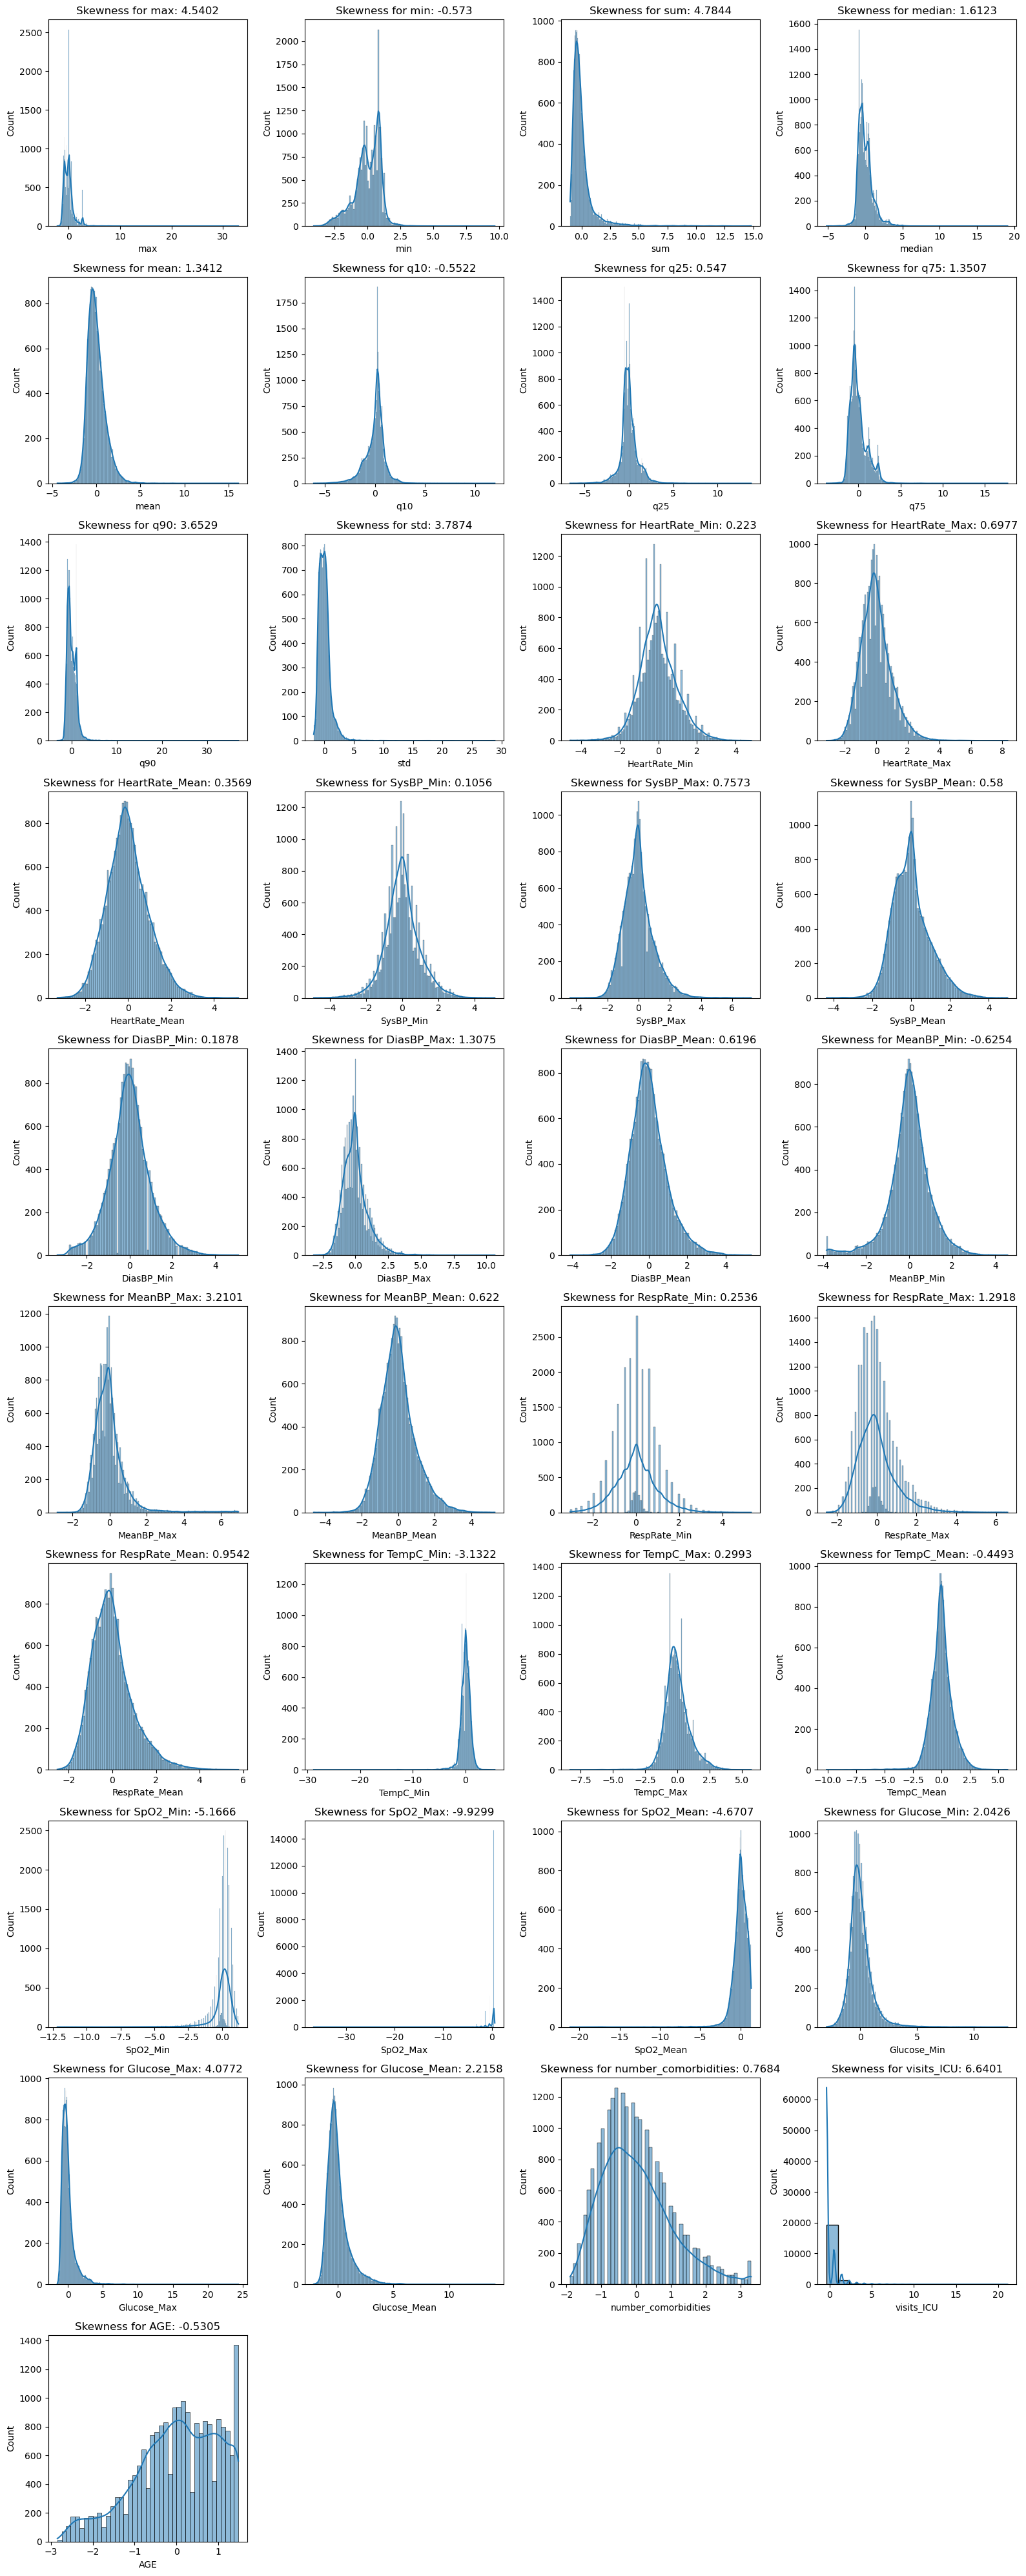

In [73]:
skewness_results = {}
num_features = len(numerical_features_names)
num_plots_per_row = 4
num_rows = (num_features + num_plots_per_row - 1) // num_plots_per_row

#Create a figure and an array of subplots
fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(16, 4 * num_rows))

#Loop through each numerical feature
for i, col in enumerate(numerical_features_names):
    col_name = col
    col_skew = skew(X_train[col], nan_policy = 'omit')
    col_skew_rounded = round(col_skew, 4)
    skewness_results[col_name] = col_skew_rounded
    row_idx = i // num_plots_per_row
    col_idx = i % num_plots_per_row
    
    # Plot a histogram in the current subplot
    sns.histplot(X_train[col], kde=True, ax=axes[row_idx, col_idx])
    axes[row_idx, col_idx].set_title(f'Skewness for {col_name}: {col_skew_rounded}')

#Remove empty subplots
for i in range(num_features, num_rows * num_plots_per_row):
    row_idx = i // num_plots_per_row
    col_idx = i % num_plots_per_row
    fig.delaxes(axes[row_idx, col_idx])

#Adjust layout spacing
plt.tight_layout()

#Show all the plots
plt.show()

# Decision trees

For this section, the decision trees that are fit corresponds to Extreme Gradient Boosting (XGBoost) and Gradient Boosting (GBM). Regarding the former, the feature importances are assessed. While for the later, confidence intervals are built for the predictions.

Both Extreme Gradient Boosting and Gradient Boosting are boosting algorithms. Boosting favours the bias-variance tradeoff since it reduces the variance of an estimator and increases its predictive accuracy. 

Altough being similar, Extreme Gradient Boosting refines its predictions by iteratively solving the gradient search in one single step using Taylor expansion of the gradient formula. Furthermore, Extreme Gradient Boosting is a more regularized model than Gradient Boosting, since it uses regularizations (L1 and L2 parameters) that allow to control overfitting and improves model generalization capabilities. 

## Extreme Gradient Boosting (XGBoost)

First, it is created an instance of an XGBoost regressor model. The parameter *objective* specify the learning objective, in this case it is set the default which corresponds to regression with squared loss (*'reg:squarederror'*). The parameter *eval_metric* corresponds to the evaluation metrics for validation data, which are assigned based on the objective: the default for regression is *'rmse'*).  


The hyperparameter optimization is done before fitting the model.

The parameters tuned in the GridSearch corresponds to:
- *gamma*: minimum decrease in loss needed to split a leaf node further in the tree. The minimum value for *gamma* corresponds to 0.
- *colsample_bytree*: subsample ratio of columns when constructing each tree.
- *n_estimators*: Number of boosting rounds.
- *subsample*: Subsample ratio of the training instances. Subsampling occur once in every boosting iteration and the range is (0,1].
- *learning_rate*: Step size shrinkage used in update to prevent overfitting. Its range coresponds to [0,1].
- *reg_alpha*: L1 regularization term on weights. It is analogous to Lasso regression and it is used to control overfitting.
- *reg_lambda*: L2 regularization term on weights. It is analogous to Ridge regression and is used to control overtiffing.
- *max_depth*: Maximum depth of a tree. It is used to control overfitting since a deeper tree learn pattens more specific to the concrete sample.
- *'min_child_weight'*: Minimum number of instances needed to be in each node. 


The process to find the optimal parameter using GridSearch was the following: first only the parameters *max_depth* and *min_child_weight* were introduced in a wide sparse grid. Then the parameters *n_estimators* and *learning_rate* were also introduced to be tuned. The results of the best parameters from the grid allow to keep exploring the most promising regions of each parameter. The grid has been extended adding all the parameters mentioned above and iteratively zooming over the grid search. 

It is important to notice that regularization parameters such as *reg_lambda* and *reg_alpha*, along with the proper tuning of other parameters, allow to deal with the risk of overfitting, which can be proved by checking the out-of-sample predictive accuracy.

Since the hyperparameters chosen has to attain the highest RMSE, that is why *'scoring'* is set to *'neg_root_mean_squared_error'*. The number of splits for cross-validation is set to 10.

Then the model is fitted with the *X_train* and *y_train*.

Note that the model does an implicit variable selection since some variables are never chosen for split.

The following hastag out code shows the procedure explained, which is the one followed. The last combination of the grid is also in a hastag out code with the aim of computationally saving time. Therefore, this version fits the model with the optimal parameters from the grid.

In [74]:
#xgb_model = xgb.XGBRegressor(objective = 'reg:squarederror', eval_metric = 'rmse', seed = SEED)

   
# Examples of previous grids: 
# {'max_depth': [1,3,6,9,10],'min_child_weight': [2,10,100]} best parameters: {'max_depth': 3, 'min_child_weight': 100}
# {'max_depth': [2,3,4],'min_child_weight': [100,150,200]} best parameters: {'max_depth': 3, 'min_child_weight': 100}
# {'max_depth': [1,2,3,4], 'min_child_weight': [90,100,110,120]} best parameters: {'max_depth': 3, 'min_child_weight': 120}
# {'max_depth': [1,2,3,4],'min_child_weight': [120,130,140,150]} best parameters: {'max_depth': 3, 'min_child_weight': 120}
# {'max_depth': [1,2,3,4],'min_child_weight': [115,120,125]} best parameters: {'max_depth': 3, 'min_child_weight': 120}
# {'max_depth': [1,2,3,4], 'min_child_weight': [115,120,125],'n_estimators': [100, 400, 800],'learning_rate': [0.05, 0.1, 0.20]} best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 120, 'n_estimators': 100}
# {'max_depth': [1,2,3,4],'min_child_weight': [115,120,125],'n_estimators': [50,100,150],'learning_rate': [0.15,0.20,0.25]} best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 120, 'n_estimators': 150}
# {'max_depth': [1,2,3,4],'min_child_weight': [115,120,125],'n_estimators': [150,250,350],'learning_rate': [0.15,0.20,0.25]} best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 120, 'n_estimators': 150}
# {'max_depth': [1,2,3,4],'min_child_weight': [115,120,125],'n_estimators': [130,140,150,160,170],'learning_rate': [0.15,0.20,0.25]} best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 120, 'n_estimators': 160}
# {'max_depth': [1,2,3,4],'min_child_weight': [115,120,125],'n_estimators': [130,140,150,160,170],'learning_rate': [0.15,0.20,0.25], 'gamma': [0,0.25,0.5]} best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 120, 'n_estimators': 160, 'gamma': 0}
# {'max_depth': [1,2,3,4],'min_child_weight': [115,120,125],'n_estimators': [130,140,150,160,170],'learning_rate': [0.15,0.20,0.25], 'gamma': [0,0.05,0.1]} best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 120, 'n_estimators': 160, 'gamma': 0}
# {'max_depth': [1,2,3,4],'min_child_weight': [115,120,125],'n_estimators': [130,140,150,160,170],'learning_rate': [0.15,0.20,0.25], 'gamma': [0,0.05,0.1],'subsample': [0.5, 1], 'colsample_bytree': [0.5,1]} best parameters: {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 120, 'n_estimators': 160, 'subsample': 1}
# {'max_depth': [2,3,4],'min_child_weight': [115,120,125],'n_estimators': [150,160,170],'learning_rate': [0.15,0.20,0.25], 'gamma': [0,0.05],'subsample': [0.8,1], 'colsample_bytree': [0.8,1], 'reg_alpha': [0,0.5],'reg_lambda': [1, 1.5]} best parameters: {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.15, 'max_depth': 4, 'min_child_weight': 115, 'n_estimators': 150, 'reg_alpha': 0, 'reg_lambda': 1.5, 'subsample': 1}


# Last grid search:
# parameters = {'max_depth': [3,4,5],'min_child_weight': [115,120,125],'n_estimators': [80,85,90,95],'learning_rate': [0.10,0.15,0.20], 'gamma': [0,0.05,0.1],'subsample': [0.8,1,1.2], 'colsample_bytree': [0.6,0.8,1], 'reg_alpha': [0,0.5],'reg_lambda': [1,1.5,2]}


#XGB = GridSearchCV(xgb_model, parameters, n_jobs=-1, cv=10, scoring='neg_root_mean_squared_error', verbose=2, refit=True, error_score='raise')

#XGB.fit(X_train, y_train)

In [75]:
XGB = xgb.XGBRegressor(objective = 'reg:squarederror', eval_metric = 'rmse',
                       max_depth = 4, min_child_weight = 120, n_estimators = 90,
                       learning_rate = 0.15, gamma = 0, subsample = 1, colsample_bytree = 0.8,
                       reg_alpha = 0.5, reg_lambda = 1.5, seed = SEED)
  
XGB.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.15, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=120, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=90, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

As stated before, the proper procedure followed was to obtain a table and a plot of the different scores obtained from the combinations of parameters from the grid, which allow to get the parameters with the best score. Since the previous code has been hastag out, this is also, since it requires the grid search from above.

The optimal parameters obtained from the grid are indicated in the model above.

In [76]:
## Optimal parameters from the grid
#GridSearch_table_plot(XGB, "n_estimators", negative=True, display_all_params=False)

The in-sample predictions and in-sample Root Mean Squared Error are computed:

In [77]:
XGB_insample_pred = XGB.predict(X_train)

rmse = mean_squared_error(y_train, XGB_insample_pred, squared=False)
rmse

3.307067917783879

Regarding the out-of-sample predictions, they attain a value of the RMSE of 3.99 (from the Kaggle), which indicates a reasonable good predictive accuracy:

In [78]:
XGB_outsample_pred = XGB.predict(X_test)

### Feature importances

The following plot shows the importance of different features in the trained XGBoost model. Among the most important there is statistics from metadata such as the mean, the 95th quantile and the maximum along with the number of comorbidities:

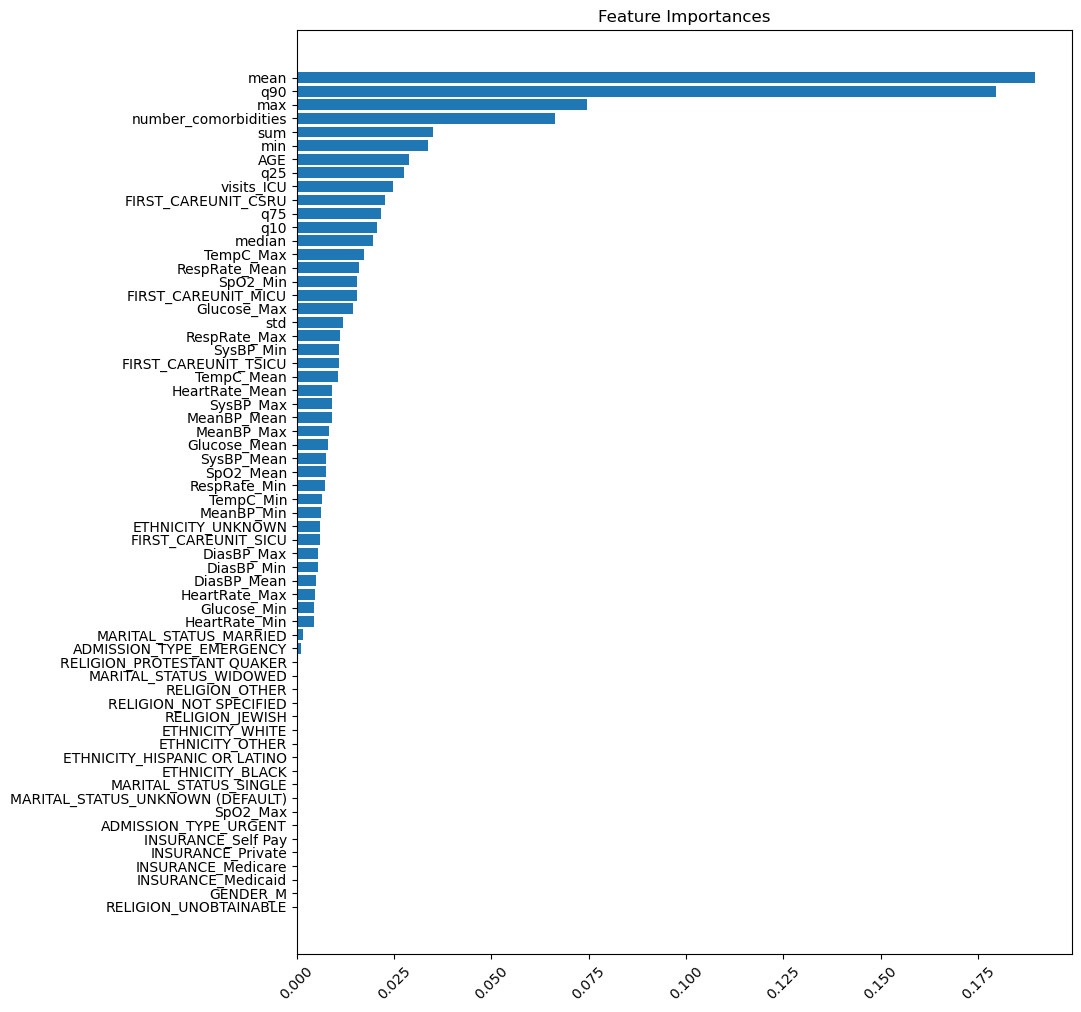

In [79]:
feature_importances = XGB.feature_importances_
sorted_importance = np.argsort(feature_importances)

plt.figure(figsize=(10, 12))
plt.barh(X_train.columns[sorted_importance], feature_importances[sorted_importance])
plt.title("Feature Importances")
plt.xticks(rotation=45)
plt.show()

## Gradient Boosting (GBM)

For the Gradient Boosting, the same procedure has been followed to found the optimal parameters. Therefore, GridSearch is also used for the parameters to be tuned. All the parameters tuned for this model are already described in XGBoost, except for:
- *min_samples_split*: The minimum number of samples required to split an internal node
- *max_features*: Number of features to consider when looking for the best split.

Since the differential part of this decision tree is the creation of the confidence intervals for predictions, I will work directly with the optimal parameters from the grid.

### Confidence interval for predictions

To account for uncertainty, we will generate prediction intervals for this model using Quantile Regressor Forest. The GBM model from scikit-learn has inbuilt functionality to train Quantile Regressor Forest setting the parameter *loss* to *quantile*. Therefore, to obtain the lower bound prediction we will train a GBM model with *alpha = 0.05* and the same to obtain the upper bound prediction but setting *alpha = 0.95*. In this way, we will obtain a 95% confidence interval for our predictions.

In [80]:
GBR = GradientBoostingRegressor(n_estimators=400,
                                learning_rate=0.006,
                                min_samples_leaf=10,
                                max_depth=15, 
                                max_features='sqrt', 
                                subsample=0.85,
                                random_state=SEED)
GBR.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.006, max_depth=15,
                          max_features='sqrt', min_samples_leaf=10,
                          n_estimators=400, random_state=3123, subsample=0.85)

In [81]:
lower_bound = GradientBoostingRegressor(n_estimators=400,
                                learning_rate=0.006,
                                min_samples_leaf=10,
                                max_depth=15, 
                                max_features='sqrt', 
                                subsample=0.85,
                                random_state=SEED,
                                loss='quantile', 
                                alpha=0.05)

lower_bound.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.05, learning_rate=0.006, loss='quantile',
                          max_depth=15, max_features='sqrt',
                          min_samples_leaf=10, n_estimators=400,
                          random_state=3123, subsample=0.85)

In [82]:
upper_bound = GradientBoostingRegressor(n_estimators=400,
                                learning_rate=0.006,
                                min_samples_leaf=10,
                                max_depth=15, 
                                max_features='sqrt', 
                                subsample=0.85,
                                random_state=SEED,
                                loss='quantile', 
                                alpha=0.95)

upper_bound.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.95, learning_rate=0.006, loss='quantile',
                          max_depth=15, max_features='sqrt',
                          min_samples_leaf=10, n_estimators=400,
                          random_state=3123, subsample=0.85)

In [83]:
LOS_mid_prediction = GBR.predict(X_test)
LOS_lower_bound = lower_bound.predict(X_test)
LOS_upper_bound = upper_bound.predict(X_test)

The table shows the point estimate of the predictions and the 95% confidence intervals generated with the upper and lower bounds:

In [84]:
predic = {'Lower bound': LOS_lower_bound, 'LOS prediction': LOS_mid_prediction, 'Upper bound': LOS_upper_bound}

predictions = pd.DataFrame(predic)
predictions.head()

Lower bound  LOS prediction  Upper bound
0     1.080628        3.480001     6.826719
1     1.107930        9.536085    18.442177
2     0.994496        3.579703     9.526541
3     0.979205        3.012016     6.506830
4     1.202263        8.842043    16.947926

The in-sample predictions and in-sample Root Mean Squared Error are computed:

In [85]:
GBR_insample_pred = GBR.predict(X_train)

rmse = mean_squared_error(y_train, GBR_insample_pred, squared=False)
rmse

2.2508655459825535

Regarding the out-of-sample predictions, they attain a value of the RMSE of 4.07 (from the Kaggle). Given the differences explained at the beggining of the section of decision trees, it is expected the fact that XGBoost attain a better performance. 

In [86]:
GBR_outsample_pred = GBR.predict(X_test)

# Ensembles

The ensemble technique used is Stacking, which involves fitting many models types on the same data and then training an extra model (meta-learner) on the output of the baseline models to learn the best combination of the predictions and attain a better predictive performance.

The selection of the models in the ensemble are based on the out-of-sample predictive performance attained for the ensemble with each combination. The parameters from each model are tuned using a Gird Search and some have been readjusted when introduced in the ensemble to attain a better predictive accuracy.

The chosen models are the following: *Ridge*, *GradientBoostRegressor*, *KNRegressor*, *RandomForest* and *ExtraTreesRegressor* (meta-learner). 

It follows a briefly discussion on the combination of models selected:

- *Ridge*: The parameter *alpha* is tuned using GridSearch, which gives as the optimal value *'alpha'=0*. Therefore, this value suggests to introduce instead Linear Regression. In practical, the predictive accuracy of the ensemble using Linear Regression instead of Ridge with the default *'alpha'=1* is lower, therefore the later is included.

- *SVR*: Support Vector Regression presents a low predictive accuracy on its own, even tuning all the parameters, and worsens the performance of the overall ensemble, that is why it has been excluded. 

- *GradientBoostRegressor* and *RandomForestRegressor* maintains a high correlation with *CatBoostRegressor* and the predictive accuracy of the overall ensemble is higher if the later is disregarded.

- *KNRegressor* is also included, whose parameters are tuned using the GridSearch as shown below.

- The meta-learner used is *ExtraTreesRegressor*. Different combinations of models for the meta-learner were tried and this is the model that attain the higher predictive accuracy for the overall ensemble. The parameters are also tuned using Gird Search.

The grid search of the models included in the ensemble is briefly shown in the following code: 

### KNeighborsRegressor

In [87]:
KNN = KNeighborsRegressor(algorithm =  'brute')

#Previous grid search: (only appear n neighbours but the other has not changed across trials)
#'n_neighbors':[100, 150, 200, 250, 300, 350, 400, 450] gives 100 and it is at the edge of the grid
#'n_neighbors':[50, 100, 150, 200, 250, 300, 350] gives 50
#'n_neighbors':[20, 30, 40, 50, 100, 150, 200, 250] gives 20
#'n_neighbors':[5, 10, 15, 20, 30, 40, 50] gives 20
#'n_neighbors':[18, 20, 22, 24] gives 24

grid_values = {'n_neighbors':[22, 23, 24, 25], 'weights':['uniform','distance'], 'metric': ['manhattan', 'minkowski']}

grid_knn_acc = GridSearchCV(KNN, param_grid = grid_values, scoring = 'neg_root_mean_squared_error', n_jobs = -1, cv = 20) # CV defines the number of folds 

grid_knn_acc.fit(X_train, y_train)

GridSearchCV(cv=20, estimator=KNeighborsRegressor(algorithm='brute'), n_jobs=-1,
             param_grid={'metric': ['manhattan', 'minkowski'],
                         'n_neighbors': [22, 23, 24, 25],
                         'weights': ['uniform', 'distance']},
             scoring='neg_root_mean_squared_error')

best parameters: {'metric': 'manhattan', 'n_neighbors': 23, 'weights': 'uniform'}
best score:      -4.01587 (+/-0.38837)


param_metric param_n_neighbors param_weights  \
2     manhattan                23       uniform   
4     manhattan                24       uniform   
0     manhattan                22       uniform   
6     manhattan                25       uniform   
3     manhattan                23      distance   
5     manhattan                24      distance   
7     manhattan                25      distance   
1     manhattan                22      distance   
15    minkowski                25      distance   
13    minkowski                24      distance   
11    minkowski                23      distance   
14    minkowski                25       uniform   
9     minkowski                22      distance   
12    minkowski                24       uniform   
10    minkowski                23       uniform   

                                                               params  \
2    {'metric': 'manhattan', 'n_neighbors': 23, 'weights': 'uniform'}   
4    {'metric': 'manhattan', 'n_neighbors': 24, 'weights': 'uniform'}   
0    {'metric': 'manhattan', 'n_neighbors': 22, 'weights': 'uniform'}   
6    {'metric': 'manhattan', 'n_neighbors': 25, 'weights': 'uniform'}   
3   {'metric': 'manhattan', 'n_neighbors': 23, 'weights': 'distance'}   
5   {'metric': 'manhattan', 'n_neighbors': 24, 'weights': 'distance'}   
7   {'metric': 'manhattan', 'n_neighbors': 25, 'weights': 'distance'}   
1   {'metric': 'manhattan', 'n_neighbors': 22, 'weights': 'distance'}   
15  {'metric': 'minkowski', 'n_neighbors': 25, 'weights': 'distance'}   
13  {'metric': 'minkowski', 'n_neighbors': 24, 'weights': 'distance'}   
11  {'metric': 'minkowski', 'n_neighbors': 23, 'weights': 'distance'}   
14   {'metric': 'minkowski', 'n_neighbors': 25, 'weights': 'uniform'}   
9   {'metric': 'minkowski', 'n_neighbors': 22, 'weights': 'distance'}   
12   {'metric': 'minkowski', 'n_neighbors': 24, 'weights': 'uniform'}   
10   {'metric': 'minkowski', 'n_neighbors': 23, 'weights': 'uniform'}   

    split0_test_score  split1_test_score  split2_test_score  \
2           -4.242098          -3.720229          -3.824327   
4           -4.259127          -3.714650          -3.832386   
0           -4.235495          -3.710171          -3.819094   
6           -4.244300          -3.717131          -3.830684   
3           -4.251325          -3.717362          -3.836255   
5           -4.266276          -3.712495          -3.843608   
7           -4.251548          -3.715113          -3.841510   
1           -4.245937          -3.708580          -3.831998   
15          -4.244560          -3.742598          -3.868465   
13          -4.243390          -3.750566          -3.865412   
11          -4.238093          -3.758124          -3.862663   
14          -4.256095          -3.746962          -3.863989   
9           -4.237011          -3.767653          -3.862772   
12          -4.255472          -3.755384          -3.860504   
10          -4.249670          -3.763022          -3.857416   

    split3_test_score  split4_test_score  split5_test_score  ...  \
2           -3.346403          -3.874701          -4.827173  ...   
4           -3.349354          -3.864238          -4.835089  ...   
0           -3.363938          -3.859323          -4.806282  ...   
6           -3.357270          -3.864446          -4.844709  ...   
3           -3.356470          -3.894734          -4.845305  ...   
5           -3.358914          -3.884782          -4.851435  ...   
7           -3.365454          -3.883503          -4.860104  ...   
1           -3.372369          -3.881041          -4.828046  ...   
15          -3.444359          -3.919235          -4.980793  ...   
13          -3.459225          -3.911284          -4.979876  ...   
11          -3.463788          -3.935079          -4.972545  ...   
14          -3.442659          -3.911552          -4.985274  ...   
9           -3.472083          -3.922366          -4.976241  ...   
12          -3.458733          -3.903105          -4.983

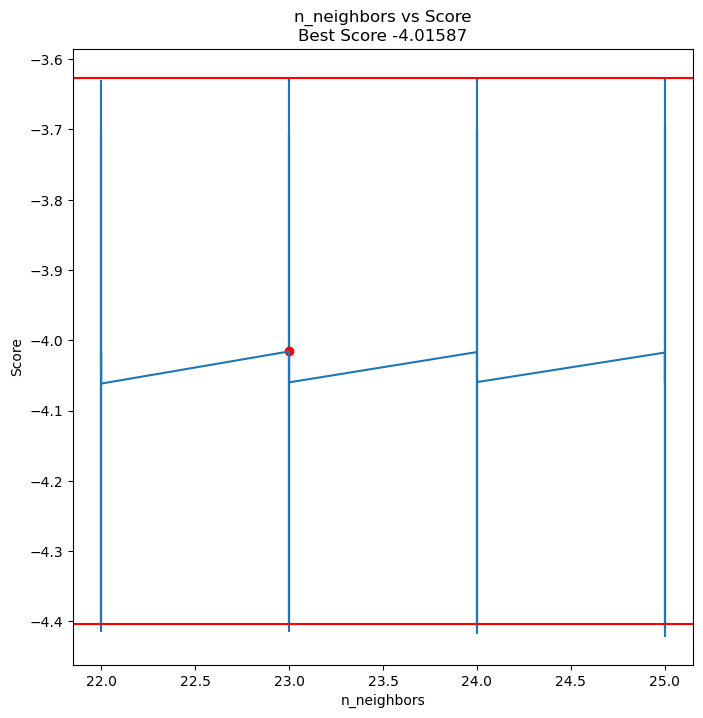

Best k parameter : 23
Best weights parameter : uniform
Best metric parameter : manhattan


In [88]:
GridSearch_table_plot(grid_knn_acc, "n_neighbors", negative=False, display_all_params=False)

print('Best k parameter : '+ str(grid_knn_acc.best_estimator_.n_neighbors))
print('Best weights parameter : '+ str(grid_knn_acc.best_estimator_.weights))
print('Best metric parameter : '+ str(grid_knn_acc.best_estimator_.metric))

### Ridge

In [89]:
#Example of previous grid:
#parameters = {'alpha':[1, 5, 10]} best parameters: {'alpha': 1}

parameters = {'alpha':[0,0.2, 0.4, 0.8, 1, 1.2]}

Rid = Ridge()

Ridge_reg= GridSearchCV(Rid, parameters, scoring='neg_mean_squared_error',cv=10)

Ridge_reg.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': [0, 0.2, 0.4, 0.8, 1, 1.2]},
             scoring='neg_mean_squared_error')

best parameters: {'alpha': 0}
best score:      -16.06293 (+/-1.90954)


param_alpha          params  split0_test_score  split1_test_score  \
0           0    {'alpha': 0}         -13.737407         -13.798997   
1         0.2  {'alpha': 0.2}         -13.737797         -13.798682   
2         0.4  {'alpha': 0.4}         -13.738188         -13.798369   
3         0.8  {'alpha': 0.8}         -13.738971         -13.797751   
4           1    {'alpha': 1}         -13.739364         -13.797445   
5         1.2  {'alpha': 1.2}         -13.739758         -13.797142   

   split2_test_score  split3_test_score  split4_test_score  split5_test_score  \
0         -20.268452         -15.641901         -14.278319         -16.420211   
1         -20.268192         -15.642581         -14.278436         -16.419726   
2         -20.267933         -15.643260         -14.278554         -16.419243   
3         -20.267420         -15.644611         -14.278792         -16.418285   
4         -20.267167         -15.645283         -14.278911         -16.417811   
5         -20.266915         -15.645953         -14.279031         -16.417339   

   split6_test_score  split7_test_score  split8_test_score  split9_test_score  \
0         -16.640568         -15.304135         -16.586874         -17.952387   
1         -16.640560         -15.304064         -16.586832         -17.952452   
2         -16.640554         -15.303996         -16.586792         -17.952518   
3         -16.640543         -15.303863         -16.586717         -17.952653   
4         -16.640540         -15.303799         -16.586681         -17.952723   
5         -16.640537         -15.303737         -16.586647         -17.952794   

   mean_test_score  std_test_score  rank_test_score  
0       -16.062925        1.909545                1  
1       -16.062932        1.909450                2  
2       -16.062941        1.909356                3  
3       -16.062961        1.909167                4  
4       -16.062972        1.909074                5  
5       -16.062985        1.908980                6

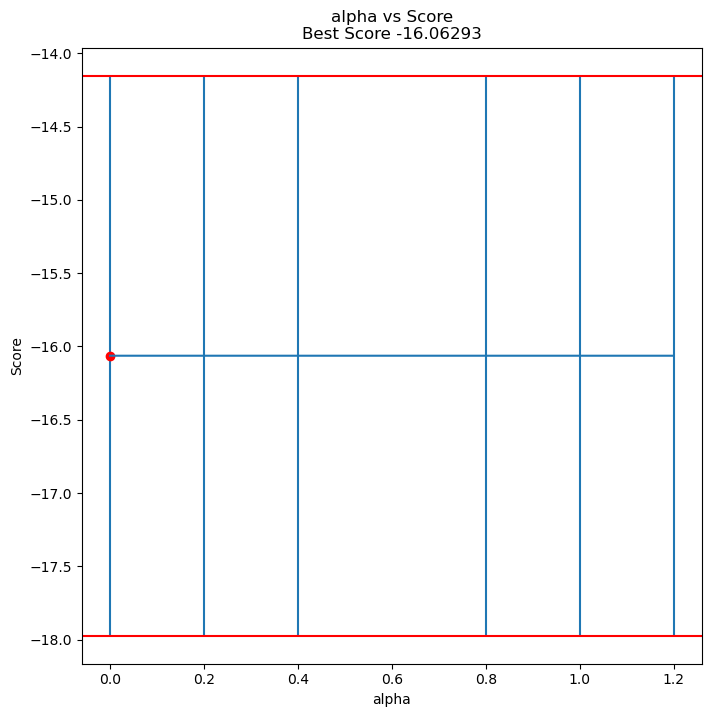

In [90]:
GridSearch_table_plot(Ridge_reg, "alpha", negative=False, display_all_params=False)

### ExtraTreesRegressor

In [93]:
#Example of previous grid:
#'n_estimators': [50,100,150,200,300] gives 300 so I increase since 300 is at the end of the grid

ETR_model = ExtraTreesRegressor()

parameters = {
    'n_estimators': [300,350,400],
    'criterion': ['squared_error'],
    'max_depth': [14,16,18,20],
    'max_features': ['auto','sqrt','log2'],    
    'bootstrap': [True, False],
    'warm_start': [True, False],
}

ETR = GridSearchCV(ETR_model, parameters, n_jobs=-1, 
                   cv=10,
                   scoring='neg_root_mean_squared_error',
                   verbose=2, refit=True)
ETR.fit(X_train, y_train)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
[CV] END bootstrap=True, criterion=squared_error, max_depth=14, max_features=auto, n_estimators=300, warm_start=True; total time=   0.0s
[CV] END bootstrap=True, criterion=squared_error, max_depth=14, max_features=auto, n_estimators=350, warm_start=True; total time=   0.0s
[CV] END bootstrap=True, criterion=squared_error, max_depth=14, max_features=sqrt, n_estimators=300, warm_start=False; total time=   3.9s
[CV] END bootstrap=True, criterion=squared_error, max_depth=14, max_features=sqrt, n_estimators=300, warm_start=False; total time=   4.0s
[CV] END bootstrap=True, criterion=squared_error, max_depth=14, max_features=sqrt, n_estimators=300, warm_start=False; total time=   3.8s
[CV] END bootstrap=True, criterion=squared_error, max_depth=14, max_features=sqrt, n_estimators=300, warm_start=False; total time=   3.6s
[CV] END bootstrap=True, criterion=squared_error, max_depth=14, max_features=auto, n_estimators=300, warm_sta

[CV] END bootstrap=True, criterion=squared_error, max_depth=14, max_features=auto, n_estimators=300, warm_start=True; total time=   0.0s
[CV] END bootstrap=True, criterion=squared_error, max_depth=14, max_features=auto, n_estimators=350, warm_start=True; total time=   0.0s
[CV] END bootstrap=True, criterion=squared_error, max_depth=14, max_features=auto, n_estimators=350, warm_start=True; total time=   0.0s
[CV] END bootstrap=True, criterion=squared_error, max_depth=14, max_features=auto, n_estimators=400, warm_start=False; total time=   0.0s
[CV] END bootstrap=True, criterion=squared_error, max_depth=14, max_features=auto, n_estimators=400, warm_start=False; total time=   0.0s
[CV] END bootstrap=True, criterion=squared_error, max_depth=14, max_features=sqrt, n_estimators=300, warm_start=True; total time=   3.9s
[CV] END bootstrap=True, criterion=squared_error, max_depth=14, max_features=sqrt, n_estimators=300, warm_start=True; total time=   3.9s
[CV] END bootstrap=True, criterion=squa

GridSearchCV(cv=10, estimator=ExtraTreesRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['squared_error'],
                         'max_depth': [14, 16, 18],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [300, 350, 400],
                         'warm_start': [True, False]},
             scoring='neg_root_mean_squared_error', verbose=2)

best parameters: {'bootstrap': False, 'criterion': 'squared_error', 'max_depth': 18, 'max_features': 'sqrt', 'n_estimators': 350, 'warm_start': True}
best score:      -3.83417 (+/-0.20530)


param_bootstrap param_criterion param_max_depth param_max_features  \
98            False   squared_error              18               sqrt   
101           False   squared_error              18               sqrt   
100           False   squared_error              18               sqrt   
96            False   squared_error              18               sqrt   
97            False   squared_error              18               sqrt   
99            False   squared_error              18               sqrt   
47             True   squared_error              18               sqrt   
44             True   squared_error              18               sqrt   
46             True   squared_error              18               sqrt   
45             True   squared_error              18               sqrt   
42             True   squared_error              18               sqrt   
43             True   squared_error              18               sqrt   
78            False   squared_error              16               sqrt   
80            False   squared_error              16               sqrt   
81            False   squared_error              16               sqrt   

    param_n_estimators param_warm_start  \
98                 350             True   
101                400            False   
100                400             True   
96                 300             True   
97                 300            False   
99                 350            False   
47                 400            False   
44                 350             True   
46                 400             True   
45                 350            False   
42                 300             True   
43                 300            False   
78                 300             True   
80                 350             True   
81                 350            False   

                                                                                                                                    params  \
98    {'bootstrap': False, 'criterion': 'squared_error', 'max_depth': 18, 'max_features': 'sqrt', 'n_estimators': 350, 'warm_start': True}   
101  {'bootstrap': False, 'criterion': 'squared_error', 'max_depth': 18, 'max_features': 'sqrt', 'n_estimators': 400, 'warm_start': False}   
100   {'bootstrap': False, 'criterion': 'squared_error', 'max_depth': 18, 'max_features': 'sqrt', 'n_estimators': 400, 'warm_start': True}   
96    {'bootstrap': False, 'criterion': 'squared_error', 'max_depth': 18, 'max_features': 'sqrt', 'n_estimators': 300, 'warm_start': True}   
97   {'bootstrap': False, 'criterion': 'squared_error', 'max_depth': 18, 'max_features': 'sqrt', 'n_estimators': 300, 'warm_start': False}   
99   {'bootstrap': False, 'criterion': 'squared_error', 'max_depth': 18, 'max_features': 'sqrt', 'n_estimators': 350, 'warm_start': False}   
47    {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 18, 'max_features': 'sqrt', 'n_estimators': 400, 'warm_start': False}   
44     {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 18, 'max_features': 'sqrt', 'n_estimators': 350, 'warm_start': True}   
46     {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 18, 'max_features': 'sqrt', 'n_estimators': 400, 'warm_start': True}   
45    {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 18, 'max_features': 'sqrt', 'n_estimators': 350, 'warm_start': False}   
42     {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 18, 'max_features': 'sqrt', 'n_estimators': 300, 'warm_start': True}   
43    {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 18, 'max_features': 'sqrt', 'n_estimators': 300, 'warm_start': False}   
78    {'bootstrap': False, 'criterion': 'squared_error', 'max_depth': 16, 'max_features': 'sqrt', 'n_estimators': 300, 'warm_start': True}   
80    {'bootstrap': False, 'criterion': 'squared_error', 'max_depth': 16, 'max_features': 'sqrt', 'n_estimators': 350, 'warm_start': True}   


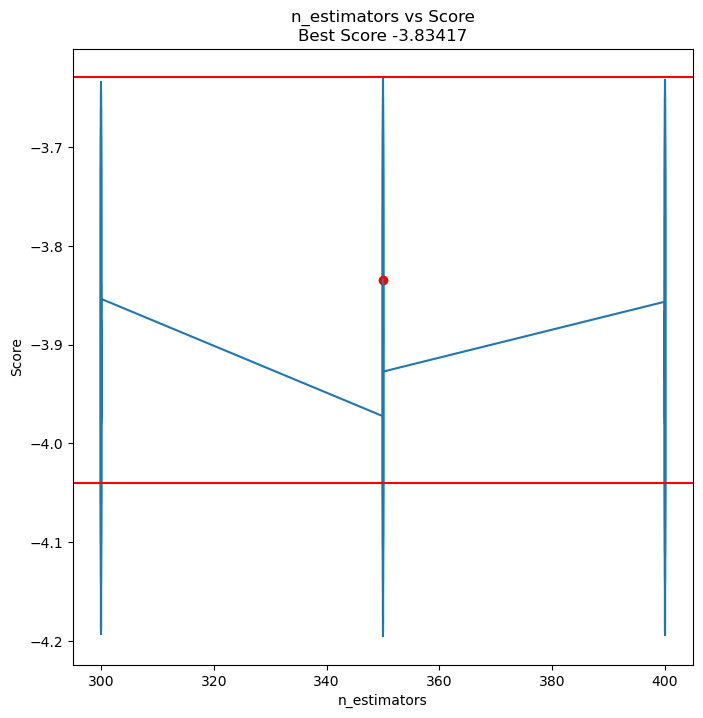

In [94]:
GridSearch_table_plot(ETR, "n_estimators", negative=False, display_all_params=False)

### Ensemble configuration

The first step is to create three functions: a function that generates a library of simple learners (*get_models*), a function that fit the models on the training set and return predictions (*train_predict*) and the other that scores the models in the test set (*score_models*):

In [104]:
def get_models():
    KNN = KNeighborsRegressor(n_neighbors=23, weights = 'uniform', metric = 'manhattan')
    Rid = Ridge()
    GBR = GradientBoostingRegressor(n_estimators=450,learning_rate=0.006,min_samples_leaf=10,
                                    max_depth=15, max_features='sqrt', subsample=0.85,random_state=SEED)
    RF = RandomForestRegressor(n_estimators=10, max_features=3, max_depth=9,bootstrap = True,
                               min_samples_split=10, criterion = 'squared_error',random_state=SEED)
    

    models = {'knn': KNN,'Ridge': Rid,'GradientBoosting': GBR, 'Random Forest': RF}

    return models


def train_predict(model_list,xtrain,ytrain):
    P = np.zeros((y_train.shape[0], len(model_list)))
    P = pd.DataFrame(P)

    cols = list()
    for i, (name, m) in enumerate(models.items()):
        print("%s..." % name, end=" ", flush=False)
        m.fit(xtrain, ytrain)
        P.iloc[:, i] = m.predict(xtrain)
        cols.append(name)
        print("done")

    P.columns = cols
    print("Done.\n")
    return P


def score_models(P, y):
    print("Scoring models.")
    scores=[]
    for m in P.columns:
        score = mean_squared_error(y, P.loc[:, m], squared=False)
        scores.append(score)
        print("%-26s: %.3f" % (m, score))
    return P.columns,scores

In [105]:
models = get_models()
P = train_predict(models,X_train,y_train)
my_models,my_scores= score_models(P, y_train)

knn... done
Ridge... done
GradientBoosting... done
Random Forest... done
Done.

Scoring models.
knn                       : 3.862
Ridge                     : 3.990
GradientBoosting          : 2.124
Random Forest             : 3.521


It is adviced to avoid ensembling models that are quite correlated. As can be seen in the plot, this combination does not exceed the correlation of 0.90, which have been considered a reasonable value to mantain all four within the ensemble. Moreover, the predictive performance of these combination is better than the performance obtained by removing one of these models:

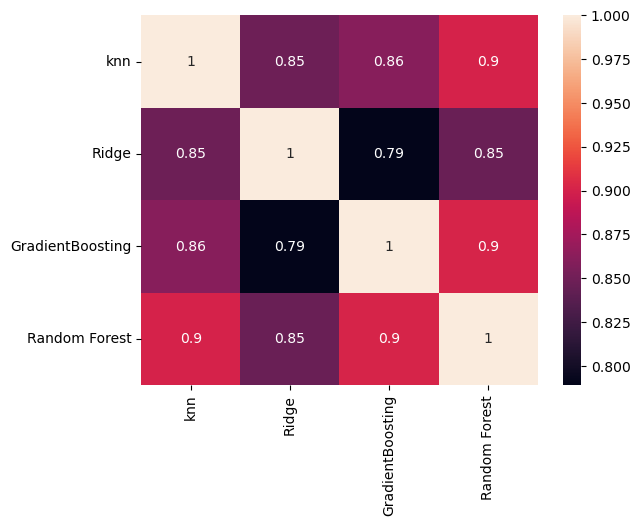

In [106]:
sns.heatmap(P.corr(), annot=True)
plt.show()

The results of model predictions are saved:

In [107]:
results=[(model,score) for model,score in zip(my_models,my_scores)]
results

[('knn', 3.8622012534744785),
 ('Ridge', 3.9896241256856717),
 ('GradientBoosting', 2.123842109407136),
 ('Random Forest', 3.521272519427478)]

Here we define the features to propagate from the original training dataset. Therefore, the meta-learner will deal with the results from previous models but also the propagated features. These features are selected based on the feature importance shown previously and corresponds to *'mean'*, *'max'*, *'q90'* and *'number_comorbidities'*.

In [108]:
features_to_propagate = ['mean','max','q90','number_comorbidities']
pointer= [i for i,x in enumerate(X_train.columns) if x in features_to_propagate]
X_train.columns[pointer]

Index(['number_comorbidities', 'max', 'q90', 'mean'], dtype='object')

The meta-learner is defined:

In [109]:
meta_learner = ExtraTreesRegressor(bootstrap = False, criterion = 'squared_error', max_depth = 16, max_features = 'sqrt', n_estimators = 350, warm_start = True, random_state=SEED)

### Stacking

Firstly, a Super Learner model with specific settings is initialized. For example, the number of folds for cross-validation is set to 5. Then, the base learners and the features to propagate are added, and also the meta-learner. Then the ensemble is trained and the training set is predicted to get a RMSE score of the overall ensemble:

In [110]:
SL = SuperLearner(folds=5, verbose=2, backend="threading", n_jobs=-1, random_state=SEED)

SL.add(list(models.values()), propagate_features=pointer)
SL.add_meta(meta_learner)

SL.fit(X_train.values,y_train.values)

SL_insample_predict = SL.predict(X_train.values)
scoreStackXtres=mean_squared_error(y_train, SL_insample_predict)
print("\nSuper Learner RMSE score: %.3f" % scoreStackXtres)


Fitting 2 layers
Processing layer-1             done | 00:00:33
Processing layer-2             done | 00:00:02
Fit complete                        | 00:00:36

Predicting 2 layers
Processing layer-1             done | 00:00:03
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:04

Super Learner RMSE score: 6.674


In [111]:
results=results+[('StackingExtraTrees',scoreStackXtres)]
results

[('knn', 3.8622012534744785),
 ('Ridge', 3.9896241256856717),
 ('GradientBoosting', 2.123842109407136),
 ('Random Forest', 3.521272519427478),
 ('StackingExtraTrees', 6.673554605804181)]

Although the in-sample RMSE of the ensemble seems to be quite high, the out-of-sample prediction attain a better out-of-sample predictive performance with a RMSE of 4.06:

In [112]:
prediction_kaggle = SL.predict(X_test.values)


Predicting 2 layers
Processing layer-1             done | 00:00:01
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:01


# Neural Network

This function *Neural_model* constructs a feedforward neural network (Multilayer Perceptron) using Keras. 

The Keras model is built using the Sequential class, which organizes layers in a linear stack. For standard feedforward networks, the model primarily uses Dense layers, representing fully-connected layers within the neural network architecture.

Dropout tries to approximate different neural networks on our data. At each iteration, we pretend to have a slightly different network by randomly drop out nodes and then remove all connections from this node onwards. This avoids to overfitting a particular network to a particular dataset.

Model architecture: 

- For the input layer it is used a dropout regularization with a dropout rate of *p0* and it is passed an *input_shape* argument (which is adjusted to the number of features from the X_train).
- The subsequent function adds hidden layers based on the value of *hidden_layers*. The hidden layers defined are dense layers that uses ReLU activation and includes constraints (kernel_constraint) on the weights using maxNorm and regularization for both kernel and bias. A dropout layer is applied to the output of the hidden layers to provide regularization by randomly setting a fraction p of the inputs to zero during training.
- The output layer is a dense layer with a single node and with a linear activation function, since the project is based on regression.

The model is compiled with Mean Squared Error (MSE) as the loss function and Root Mean Squared Error (RMSE) as the evaluation metric using the Adam optimizer.

The values not tuned in grid search are set to common values since they attain a reasonable good predictive performance and ensures convergence to the neural.

In [129]:
def Neural_model(optimizer='Adam', L1 = 1e-4, L2 = 1e-5, hidden_layers = 1, p = 0.5, p0 = 0.2):

    input_shape = X_train.shape[1]

    Keras_MLP = Sequential()

    Keras_MLP.add(Dropout(p0, input_shape=(input_shape,)))

    for layer in range(hidden_layers):
        Keras_MLP.add(Dense((1/p)*64, activation='relu', kernel_constraint=MaxNorm(3, axis=0),
            kernel_regularizer=regularizers.l1_l2(l1= L1, l2= L2),
            bias_regularizer=regularizers.l2(L2)))
        Keras_MLP.add(Dropout(p))
    Keras_MLP.add(Dense(1, activation='linear'))


    Keras_MLP.compile(
        optimizer= optimizer,
        loss='mse',
        metrics=['RootMeanSquaredError']
    )

    return Keras_MLP

An instance of a KerasRegressor is created, which is a scikit-learn wrapper for Keras neural networks. This enables the compatibility with grid search, cross-validation...

In [130]:
Keras_MLP = KerasRegressor(build_fn=Neural_model , L1 = 1e-4, L2 = 1e-5, hidden_layers = 1, p = 0.5, p0 =0.2)

print(Keras_MLP.get_params().keys())

dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs', 'L1', 'L2', 'hidden_layers', 'p', 'p0'])


## Grid Search

A Grid Search is used to tune the following parameters from the neural: *epochs*, *batch_size*, *hidden_layers*, *p*, *L1* and *L2*.

The proper number of epochs and the batch size is tuned through Grid Search ensuring the convergence of the model and avoiding overfitting. Epochs corresponds to the number of times the algorithm processes the entire dataset while batch size indicates the number of samples used per gradient update.

The following code shows the last grid, where the values of specific already tuned parameters are set to a specific value. 

The optimal parameters corresponds to *L1 = 0.01*, *L2 = 0.001*, *batch_size = 1250*, *epochs = 150*, *hidden_layers = 2* and *p = 0.4*.

Epoch 1/150
14/14 [==============================] - 0s 2ms/step - loss: 42.7980 - root_mean_squared_error: 5.8251
Epoch 2/150
14/14 [==============================] - 0s 2ms/step - loss: 33.1359 - root_mean_squared_error: 4.9598
Epoch 3/150
14/14 [==============================] - 0s 2ms/step - loss: 28.8314 - root_mean_squared_error: 4.5436
Epoch 4/150
14/14 [==============================] - 0s 2ms/step - loss: 26.4476 - root_mean_squared_error: 4.3230
Epoch 5/150
14/14 [==============================] - 0s 2ms/step - loss: 25.6828 - root_mean_squared_error: 4.2905
Epoch 6/150
14/14 [==============================] - 0s 3ms/step - loss: 24.7909 - root_mean_squared_error: 4.2434
Epoch 7/150
14/14 [==============================] - 0s 2ms/step - loss: 23.9620 - root_mean_squared_error: 4.1987
Epoch 8/150
14/14 [==============================] - 0s 2ms/step - loss: 23.4652 - root_mean_squared_error: 4.1884
Epoch 9/150
14/14 [==============================] - 0s 2ms/step - loss: 22.8109

14/14 [==============================] - 0s 2ms/step - loss: 16.2715 - root_mean_squared_error: 3.9119
Epoch 142/150
14/14 [==============================] - 0s 2ms/step - loss: 16.3367 - root_mean_squared_error: 3.9196
Epoch 143/150
14/14 [==============================] - 0s 2ms/step - loss: 16.1685 - root_mean_squared_error: 3.8974
Epoch 144/150
14/14 [==============================] - 0s 2ms/step - loss: 16.7692 - root_mean_squared_error: 3.9736
Epoch 145/150
14/14 [==============================] - 0s 2ms/step - loss: 16.5093 - root_mean_squared_error: 3.9402
Epoch 146/150
14/14 [==============================] - 0s 2ms/step - loss: 16.2516 - root_mean_squared_error: 3.9067
Epoch 147/150
14/14 [==============================] - 0s 2ms/step - loss: 16.4908 - root_mean_squared_error: 3.9368
Epoch 148/150
14/14 [==============================] - 0s 2ms/step - loss: 16.4437 - root_mean_squared_error: 3.9299
Epoch 149/150
14/14 [==============================] - 0s 2ms/step - loss: 16.

14/14 [==============================] - 0s 2ms/step - loss: 15.6119 - root_mean_squared_error: 3.8380
Epoch 132/150
14/14 [==============================] - 0s 2ms/step - loss: 15.1547 - root_mean_squared_error: 3.7771
Epoch 133/150
14/14 [==============================] - 0s 2ms/step - loss: 15.2897 - root_mean_squared_error: 3.7951
Epoch 134/150
14/14 [==============================] - 0s 2ms/step - loss: 15.1389 - root_mean_squared_error: 3.7743
Epoch 135/150
14/14 [==============================] - 0s 2ms/step - loss: 15.3459 - root_mean_squared_error: 3.8031
Epoch 136/150
14/14 [==============================] - 0s 2ms/step - loss: 15.4080 - root_mean_squared_error: 3.8098
Epoch 137/150
14/14 [==============================] - 0s 2ms/step - loss: 15.2358 - root_mean_squared_error: 3.7870
Epoch 138/150
14/14 [==============================] - 0s 2ms/step - loss: 15.3174 - root_mean_squared_error: 3.7966
Epoch 139/150
14/14 [==============================] - 0s 2ms/step - loss: 15.

14/14 [==============================] - 0s 2ms/step - loss: 16.3052 - root_mean_squared_error: 3.9142
Epoch 122/150
14/14 [==============================] - 0s 2ms/step - loss: 16.0811 - root_mean_squared_error: 3.8851
Epoch 123/150
14/14 [==============================] - 0s 2ms/step - loss: 16.1299 - root_mean_squared_error: 3.8906
Epoch 124/150
14/14 [==============================] - 0s 2ms/step - loss: 15.8310 - root_mean_squared_error: 3.8532
Epoch 125/150
14/14 [==============================] - 0s 2ms/step - loss: 15.7678 - root_mean_squared_error: 3.8450
Epoch 126/150
14/14 [==============================] - 0s 2ms/step - loss: 16.0606 - root_mean_squared_error: 3.8834
Epoch 127/150
14/14 [==============================] - 0s 2ms/step - loss: 16.0021 - root_mean_squared_error: 3.8769
Epoch 128/150
14/14 [==============================] - 0s 2ms/step - loss: 16.0133 - root_mean_squared_error: 3.8769
Epoch 129/150
14/14 [==============================] - 0s 2ms/step - loss: 16.

14/14 [==============================] - 0s 2ms/step - loss: 17.1238 - root_mean_squared_error: 3.9570
Epoch 42/150
14/14 [==============================] - 0s 2ms/step - loss: 16.8505 - root_mean_squared_error: 3.9273
Epoch 43/150
14/14 [==============================] - 0s 2ms/step - loss: 16.9067 - root_mean_squared_error: 3.9383
Epoch 44/150
14/14 [==============================] - 0s 2ms/step - loss: 17.4177 - root_mean_squared_error: 4.0049
Epoch 45/150
14/14 [==============================] - 0s 2ms/step - loss: 16.8078 - root_mean_squared_error: 3.9309
Epoch 46/150
14/14 [==============================] - 0s 2ms/step - loss: 16.9520 - root_mean_squared_error: 3.9530
Epoch 47/150
14/14 [==============================] - 0s 2ms/step - loss: 16.8084 - root_mean_squared_error: 3.9374
Epoch 48/150
14/14 [==============================] - 0s 2ms/step - loss: 16.8207 - root_mean_squared_error: 3.9412
Epoch 49/150
14/14 [==============================] - 0s 2ms/step - loss: 16.7104 - r

14/14 [==============================] - 0s 1ms/step - loss: 17.0317 - root_mean_squared_error: 3.8915
Epoch 32/150
14/14 [==============================] - 0s 1ms/step - loss: 16.8179 - root_mean_squared_error: 3.8714
Epoch 33/150
14/14 [==============================] - 0s 1ms/step - loss: 16.7511 - root_mean_squared_error: 3.8711
Epoch 34/150
14/14 [==============================] - 0s 1ms/step - loss: 16.8305 - root_mean_squared_error: 3.8886
Epoch 35/150
14/14 [==============================] - 0s 1ms/step - loss: 16.7835 - root_mean_squared_error: 3.8894
Epoch 36/150
14/14 [==============================] - 0s 1ms/step - loss: 16.4591 - root_mean_squared_error: 3.8546
Epoch 37/150
14/14 [==============================] - 0s 1ms/step - loss: 16.6667 - root_mean_squared_error: 3.8872
Epoch 38/150
14/14 [==============================] - 0s 1ms/step - loss: 16.4890 - root_mean_squared_error: 3.8687
Epoch 39/150
14/14 [==============================] - 0s 1ms/step - loss: 16.8193 - r

14/14 [==============================] - 0s 1ms/step - loss: 19.8013 - root_mean_squared_error: 4.0883
Epoch 21/150
14/14 [==============================] - 0s 2ms/step - loss: 19.5333 - root_mean_squared_error: 4.0713
Epoch 22/150
14/14 [==============================] - 0s 2ms/step - loss: 19.4833 - root_mean_squared_error: 4.0809
Epoch 23/150
14/14 [==============================] - 0s 1ms/step - loss: 19.4281 - root_mean_squared_error: 4.0888
Epoch 24/150
14/14 [==============================] - 0s 2ms/step - loss: 19.0303 - root_mean_squared_error: 4.0532
Epoch 25/150
14/14 [==============================] - 0s 2ms/step - loss: 19.2208 - root_mean_squared_error: 4.0900
Epoch 26/150
14/14 [==============================] - 0s 2ms/step - loss: 18.6711 - root_mean_squared_error: 4.0340
Epoch 27/150
14/14 [==============================] - 0s 2ms/step - loss: 18.6801 - root_mean_squared_error: 4.0464
Epoch 28/150
14/14 [==============================] - 0s 2ms/step - loss: 18.5925 - r

14/14 [==============================] - 0s 1ms/step - loss: 22.0352 - root_mean_squared_error: 4.0784
Epoch 10/150
14/14 [==============================] - 0s 1ms/step - loss: 22.0324 - root_mean_squared_error: 4.1135
Epoch 11/150
14/14 [==============================] - 0s 1ms/step - loss: 21.7368 - root_mean_squared_error: 4.1115
Epoch 12/150
14/14 [==============================] - 0s 1ms/step - loss: 21.3634 - root_mean_squared_error: 4.0980
Epoch 13/150
14/14 [==============================] - 0s 1ms/step - loss: 20.8067 - root_mean_squared_error: 4.0586
Epoch 14/150
14/14 [==============================] - 0s 1ms/step - loss: 20.4510 - root_mean_squared_error: 4.0416
Epoch 15/150
14/14 [==============================] - 0s 1ms/step - loss: 20.1138 - root_mean_squared_error: 4.0260
Epoch 16/150
14/14 [==============================] - 0s 1ms/step - loss: 19.8087 - root_mean_squared_error: 4.0118
Epoch 17/150
14/14 [==============================] - 0s 1ms/step - loss: 19.7809 - r

14/14 [==============================] - 0s 1ms/step - loss: 15.9761 - root_mean_squared_error: 3.8856
Epoch 150/150
4/4 [==============================] - 0s 665us/step
Epoch 1/150
14/14 [==============================] - 0s 1ms/step - loss: 42.7333 - root_mean_squared_error: 5.9066
Epoch 2/150
14/14 [==============================] - 0s 1ms/step - loss: 34.3865 - root_mean_squared_error: 5.1738
Epoch 3/150
14/14 [==============================] - 0s 1ms/step - loss: 29.3904 - root_mean_squared_error: 4.6919
Epoch 4/150
14/14 [==============================] - 0s 1ms/step - loss: 26.9437 - root_mean_squared_error: 4.4562
Epoch 5/150
14/14 [==============================] - 0s 1ms/step - loss: 25.9598 - root_mean_squared_error: 4.3833
Epoch 6/150
14/14 [==============================] - 0s 1ms/step - loss: 25.3709 - root_mean_squared_error: 4.3579
Epoch 7/150
14/14 [==============================] - 0s 1ms/step - loss: 24.1919 - root_mean_squared_error: 4.2635
Epoch 8/150
14/14 [======

14/14 [==============================] - 0s 1ms/step - loss: 15.9539 - root_mean_squared_error: 3.8774
Epoch 140/150
14/14 [==============================] - 0s 1ms/step - loss: 15.8905 - root_mean_squared_error: 3.8703
Epoch 141/150
14/14 [==============================] - 0s 1ms/step - loss: 16.4526 - root_mean_squared_error: 3.9417
Epoch 142/150
14/14 [==============================] - 0s 1ms/step - loss: 16.1247 - root_mean_squared_error: 3.8992
Epoch 143/150
14/14 [==============================] - 0s 1ms/step - loss: 16.5915 - root_mean_squared_error: 3.9586
Epoch 144/150
14/14 [==============================] - 0s 1ms/step - loss: 15.8057 - root_mean_squared_error: 3.8574
Epoch 145/150
14/14 [==============================] - 0s 1ms/step - loss: 16.3065 - root_mean_squared_error: 3.9221
Epoch 146/150
14/14 [==============================] - 0s 1ms/step - loss: 16.4344 - root_mean_squared_error: 3.9369
Epoch 147/150
14/14 [==============================] - 0s 1ms/step - loss: 16.

14/14 [==============================] - 0s 1ms/step - loss: 16.3575 - root_mean_squared_error: 3.9340
Epoch 130/150
14/14 [==============================] - 0s 1ms/step - loss: 15.9744 - root_mean_squared_error: 3.8869
Epoch 131/150
14/14 [==============================] - 0s 1ms/step - loss: 16.2377 - root_mean_squared_error: 3.9196
Epoch 132/150
14/14 [==============================] - 0s 1ms/step - loss: 16.3369 - root_mean_squared_error: 3.9322
Epoch 133/150
14/14 [==============================] - 0s 1ms/step - loss: 16.3897 - root_mean_squared_error: 3.9391
Epoch 134/150
14/14 [==============================] - 0s 1ms/step - loss: 16.6895 - root_mean_squared_error: 3.9771
Epoch 135/150
14/14 [==============================] - 0s 1ms/step - loss: 16.1035 - root_mean_squared_error: 3.9027
Epoch 136/150
14/14 [==============================] - 0s 1ms/step - loss: 16.0015 - root_mean_squared_error: 3.8901
Epoch 137/150
14/14 [==============================] - 0s 1ms/step - loss: 15.

14/14 [==============================] - 0s 1ms/step - loss: 15.7408 - root_mean_squared_error: 3.8579
Epoch 120/150
14/14 [==============================] - 0s 1ms/step - loss: 16.0017 - root_mean_squared_error: 3.8921
Epoch 121/150
14/14 [==============================] - 0s 1ms/step - loss: 15.7969 - root_mean_squared_error: 3.8673
Epoch 122/150
14/14 [==============================] - 0s 1ms/step - loss: 15.2819 - root_mean_squared_error: 3.7996
Epoch 123/150
14/14 [==============================] - 0s 1ms/step - loss: 15.4417 - root_mean_squared_error: 3.8209
Epoch 124/150
14/14 [==============================] - 0s 1ms/step - loss: 16.1056 - root_mean_squared_error: 3.9071
Epoch 125/150
14/14 [==============================] - 0s 1ms/step - loss: 15.9133 - root_mean_squared_error: 3.8808
Epoch 126/150
14/14 [==============================] - 0s 1ms/step - loss: 15.7986 - root_mean_squared_error: 3.8665
Epoch 127/150
14/14 [==============================] - 0s 1ms/step - loss: 15.

14/14 [==============================] - 0s 2ms/step - loss: 18.4947 - root_mean_squared_error: 4.0001
Epoch 40/150
14/14 [==============================] - 0s 2ms/step - loss: 18.4634 - root_mean_squared_error: 3.9961
Epoch 41/150
14/14 [==============================] - 0s 2ms/step - loss: 18.2652 - root_mean_squared_error: 3.9823
Epoch 42/150
14/14 [==============================] - 0s 2ms/step - loss: 18.2665 - root_mean_squared_error: 3.9949
Epoch 43/150
14/14 [==============================] - 0s 2ms/step - loss: 18.2300 - root_mean_squared_error: 3.9932
Epoch 44/150
14/14 [==============================] - 0s 2ms/step - loss: 17.9883 - root_mean_squared_error: 3.9696
Epoch 45/150
14/14 [==============================] - 0s 2ms/step - loss: 18.0864 - root_mean_squared_error: 3.9870
Epoch 46/150
14/14 [==============================] - 0s 2ms/step - loss: 17.9887 - root_mean_squared_error: 3.9772
Epoch 47/150
14/14 [==============================] - 0s 2ms/step - loss: 17.8816 - r

14/14 [==============================] - 0s 2ms/step - loss: 18.3579 - root_mean_squared_error: 3.8655
Epoch 30/150
14/14 [==============================] - 0s 2ms/step - loss: 18.3953 - root_mean_squared_error: 3.8869
Epoch 31/150
14/14 [==============================] - 0s 2ms/step - loss: 18.3518 - root_mean_squared_error: 3.8980
Epoch 32/150
14/14 [==============================] - 0s 2ms/step - loss: 18.0162 - root_mean_squared_error: 3.8724
Epoch 33/150
14/14 [==============================] - 0s 2ms/step - loss: 18.2886 - root_mean_squared_error: 3.9211
Epoch 34/150
14/14 [==============================] - 0s 2ms/step - loss: 17.7384 - root_mean_squared_error: 3.8650
Epoch 35/150
14/14 [==============================] - 0s 2ms/step - loss: 17.6772 - root_mean_squared_error: 3.8674
Epoch 36/150
14/14 [==============================] - 0s 2ms/step - loss: 17.5536 - root_mean_squared_error: 3.8631
Epoch 37/150
14/14 [==============================] - 0s 2ms/step - loss: 17.7958 - r

14/14 [==============================] - 0s 2ms/step - loss: 23.0268 - root_mean_squared_error: 4.0114
Epoch 19/150
14/14 [==============================] - 0s 2ms/step - loss: 22.7109 - root_mean_squared_error: 4.0362
Epoch 20/150
14/14 [==============================] - 0s 2ms/step - loss: 22.4036 - root_mean_squared_error: 4.0526
Epoch 21/150
14/14 [==============================] - 0s 2ms/step - loss: 22.1582 - root_mean_squared_error: 4.0732
Epoch 22/150
14/14 [==============================] - 0s 2ms/step - loss: 21.2862 - root_mean_squared_error: 4.0039
Epoch 23/150
14/14 [==============================] - 0s 2ms/step - loss: 20.9265 - root_mean_squared_error: 3.9961
Epoch 24/150
14/14 [==============================] - 0s 2ms/step - loss: 20.8652 - root_mean_squared_error: 4.0288
Epoch 25/150
14/14 [==============================] - 0s 2ms/step - loss: 20.6294 - root_mean_squared_error: 4.0309
Epoch 26/150
14/14 [==============================] - 0s 2ms/step - loss: 20.3059 - r

14/14 [==============================] - 0s 2ms/step - loss: 34.7458 - root_mean_squared_error: 4.1316
Epoch 8/150
14/14 [==============================] - 0s 2ms/step - loss: 32.8166 - root_mean_squared_error: 4.0789
Epoch 9/150
14/14 [==============================] - 0s 2ms/step - loss: 31.5211 - root_mean_squared_error: 4.0860
Epoch 10/150
14/14 [==============================] - 0s 2ms/step - loss: 30.0895 - root_mean_squared_error: 4.0675
Epoch 11/150
14/14 [==============================] - 0s 2ms/step - loss: 28.9074 - root_mean_squared_error: 4.0622
Epoch 12/150
14/14 [==============================] - 0s 2ms/step - loss: 27.2771 - root_mean_squared_error: 3.9878
Epoch 13/150
14/14 [==============================] - 0s 2ms/step - loss: 26.5809 - root_mean_squared_error: 4.0195
Epoch 14/150
14/14 [==============================] - 0s 2ms/step - loss: 25.8389 - root_mean_squared_error: 4.0314
Epoch 15/150
14/14 [==============================] - 0s 2ms/step - loss: 25.0649 - roo

14/14 [==============================] - 0s 2ms/step - loss: 16.6765 - root_mean_squared_error: 3.8910
Epoch 148/150
14/14 [==============================] - 0s 2ms/step - loss: 16.5507 - root_mean_squared_error: 3.8763
Epoch 149/150
14/14 [==============================] - 0s 2ms/step - loss: 16.4469 - root_mean_squared_error: 3.8644
Epoch 150/150
4/4 [==============================] - 0s 747us/step
Epoch 1/150
14/14 [==============================] - 0s 2ms/step - loss: 54.3048 - root_mean_squared_error: 5.1486
Epoch 2/150
14/14 [==============================] - 0s 2ms/step - loss: 45.4734 - root_mean_squared_error: 4.3699
Epoch 3/150
14/14 [==============================] - 0s 2ms/step - loss: 41.8685 - root_mean_squared_error: 4.1499
Epoch 4/150
14/14 [==============================] - 0s 2ms/step - loss: 39.7816 - root_mean_squared_error: 4.1129
Epoch 5/150
14/14 [==============================] - 0s 2ms/step - loss: 37.7952 - root_mean_squared_error: 4.0886
Epoch 6/150
14/14 [==

14/14 [==============================] - 0s 2ms/step - loss: 15.9780 - root_mean_squared_error: 3.8078
Epoch 138/150
14/14 [==============================] - 0s 2ms/step - loss: 15.9719 - root_mean_squared_error: 3.8038
Epoch 139/150
14/14 [==============================] - 0s 2ms/step - loss: 16.0653 - root_mean_squared_error: 3.8197
Epoch 140/150
14/14 [==============================] - 0s 2ms/step - loss: 16.1734 - root_mean_squared_error: 3.8298
Epoch 141/150
14/14 [==============================] - 0s 2ms/step - loss: 16.1686 - root_mean_squared_error: 3.8345
Epoch 142/150
14/14 [==============================] - 0s 2ms/step - loss: 16.2014 - root_mean_squared_error: 3.8385
Epoch 143/150
14/14 [==============================] - 0s 2ms/step - loss: 15.9334 - root_mean_squared_error: 3.8033
Epoch 144/150
14/14 [==============================] - 0s 2ms/step - loss: 15.8658 - root_mean_squared_error: 3.7960
Epoch 145/150
14/14 [==============================] - 0s 2ms/step - loss: 16.

14/14 [==============================] - 0s 2ms/step - loss: 17.3755 - root_mean_squared_error: 3.9701
Epoch 128/150
14/14 [==============================] - 0s 2ms/step - loss: 17.3732 - root_mean_squared_error: 3.9686
Epoch 129/150
14/14 [==============================] - 0s 2ms/step - loss: 17.4562 - root_mean_squared_error: 3.9829
Epoch 130/150
14/14 [==============================] - 0s 2ms/step - loss: 17.8877 - root_mean_squared_error: 4.0372
Epoch 131/150
14/14 [==============================] - 0s 2ms/step - loss: 17.2379 - root_mean_squared_error: 3.9572
Epoch 132/150
14/14 [==============================] - 0s 2ms/step - loss: 17.0888 - root_mean_squared_error: 3.9337
Epoch 133/150
14/14 [==============================] - 0s 2ms/step - loss: 17.7872 - root_mean_squared_error: 4.0245
Epoch 134/150
14/14 [==============================] - 0s 2ms/step - loss: 17.9574 - root_mean_squared_error: 4.0441
Epoch 135/150
14/14 [==============================] - 0s 2ms/step - loss: 17.

14/14 [==============================] - 0s 2ms/step - loss: 16.4307 - root_mean_squared_error: 3.8511
Epoch 118/150
14/14 [==============================] - 0s 2ms/step - loss: 16.6507 - root_mean_squared_error: 3.8790
Epoch 119/150
14/14 [==============================] - 0s 3ms/step - loss: 16.4650 - root_mean_squared_error: 3.8554
Epoch 120/150
14/14 [==============================] - 0s 2ms/step - loss: 16.1615 - root_mean_squared_error: 3.8095
Epoch 121/150
14/14 [==============================] - 0s 2ms/step - loss: 16.9932 - root_mean_squared_error: 3.9216
Epoch 122/150
14/14 [==============================] - 0s 2ms/step - loss: 16.4063 - root_mean_squared_error: 3.8454
Epoch 123/150
14/14 [==============================] - 0s 2ms/step - loss: 16.6283 - root_mean_squared_error: 3.8731
Epoch 124/150
14/14 [==============================] - 0s 2ms/step - loss: 16.3055 - root_mean_squared_error: 3.8306
Epoch 125/150
14/14 [==============================] - 0s 2ms/step - loss: 16.

14/14 [==============================] - 0s 2ms/step - loss: 19.7890 - root_mean_squared_error: 4.0751
Epoch 38/150
14/14 [==============================] - 0s 2ms/step - loss: 19.0378 - root_mean_squared_error: 3.9925
Epoch 39/150
14/14 [==============================] - 0s 2ms/step - loss: 19.0961 - root_mean_squared_error: 4.0118
Epoch 40/150
14/14 [==============================] - 0s 2ms/step - loss: 19.1301 - root_mean_squared_error: 4.0235
Epoch 41/150
14/14 [==============================] - 0s 2ms/step - loss: 18.7160 - root_mean_squared_error: 3.9784
Epoch 42/150
14/14 [==============================] - 0s 2ms/step - loss: 18.3170 - root_mean_squared_error: 3.9381
Epoch 43/150
14/14 [==============================] - 0s 2ms/step - loss: 18.6276 - root_mean_squared_error: 3.9858
Epoch 44/150
14/14 [==============================] - 0s 2ms/step - loss: 18.3197 - root_mean_squared_error: 3.9567
Epoch 45/150
14/14 [==============================] - 0s 3ms/step - loss: 18.5677 - r

Epoch 27/150
14/14 [==============================] - 0s 3ms/step - loss: 21.4180 - root_mean_squared_error: 4.0413
Epoch 28/150
14/14 [==============================] - 0s 3ms/step - loss: 20.9553 - root_mean_squared_error: 4.0173
Epoch 29/150
14/14 [==============================] - 0s 3ms/step - loss: 20.8594 - root_mean_squared_error: 4.0341
Epoch 30/150
14/14 [==============================] - 0s 3ms/step - loss: 20.6146 - root_mean_squared_error: 4.0343
Epoch 31/150
14/14 [==============================] - 0s 2ms/step - loss: 20.5985 - root_mean_squared_error: 4.0551
Epoch 32/150
14/14 [==============================] - 0s 2ms/step - loss: 20.2442 - root_mean_squared_error: 4.0356
Epoch 33/150
14/14 [==============================] - 0s 2ms/step - loss: 20.2374 - root_mean_squared_error: 4.0582
Epoch 34/150
14/14 [==============================] - 0s 2ms/step - loss: 20.2024 - root_mean_squared_error: 4.0735
Epoch 35/150
14/14 [==============================] - 0s 2ms/step - loss

14/14 [==============================] - 0s 2ms/step - loss: 25.0211 - root_mean_squared_error: 4.0367
Epoch 17/150
14/14 [==============================] - 0s 2ms/step - loss: 24.6433 - root_mean_squared_error: 4.0583
Epoch 18/150
14/14 [==============================] - 0s 2ms/step - loss: 24.0129 - root_mean_squared_error: 4.0433
Epoch 19/150
14/14 [==============================] - 0s 2ms/step - loss: 23.1383 - root_mean_squared_error: 3.9949
Epoch 20/150
14/14 [==============================] - 0s 2ms/step - loss: 22.6968 - root_mean_squared_error: 3.9957
Epoch 21/150
14/14 [==============================] - 0s 2ms/step - loss: 22.4189 - root_mean_squared_error: 4.0097
Epoch 22/150
14/14 [==============================] - 0s 2ms/step - loss: 22.3844 - root_mean_squared_error: 4.0547
Epoch 23/150
14/14 [==============================] - 0s 2ms/step - loss: 21.5125 - root_mean_squared_error: 3.9882
Epoch 24/150
14/14 [==============================] - 0s 2ms/step - loss: 21.0750 - r

14/14 [==============================] - 0s 1ms/step - loss: 25.3276 - root_mean_squared_error: 4.2955
Epoch 6/150
14/14 [==============================] - 0s 1ms/step - loss: 24.3669 - root_mean_squared_error: 4.2271
Epoch 7/150
14/14 [==============================] - 0s 1ms/step - loss: 23.7857 - root_mean_squared_error: 4.2025
Epoch 8/150
14/14 [==============================] - 0s 1ms/step - loss: 23.0532 - root_mean_squared_error: 4.1573
Epoch 9/150
14/14 [==============================] - 0s 1ms/step - loss: 22.8053 - root_mean_squared_error: 4.1674
Epoch 10/150
14/14 [==============================] - 0s 1ms/step - loss: 22.3793 - root_mean_squared_error: 4.1541
Epoch 11/150
14/14 [==============================] - 0s 1ms/step - loss: 22.0792 - root_mean_squared_error: 4.1530
Epoch 12/150
14/14 [==============================] - 0s 1ms/step - loss: 21.6344 - root_mean_squared_error: 4.1318
Epoch 13/150
14/14 [==============================] - 0s 1ms/step - loss: 20.8642 - root_

14/14 [==============================] - 0s 2ms/step - loss: 16.3377 - root_mean_squared_error: 3.9274
Epoch 146/150
14/14 [==============================] - 0s 1ms/step - loss: 16.4264 - root_mean_squared_error: 3.9386
Epoch 147/150
14/14 [==============================] - 0s 2ms/step - loss: 16.5811 - root_mean_squared_error: 3.9586
Epoch 148/150
14/14 [==============================] - 0s 2ms/step - loss: 16.1727 - root_mean_squared_error: 3.9056
Epoch 149/150
14/14 [==============================] - 0s 2ms/step - loss: 16.5329 - root_mean_squared_error: 3.9513
Epoch 150/150
4/4 [==============================] - 0s 1ms/step
Epoch 1/150
14/14 [==============================] - 0s 2ms/step - loss: 46.5009 - root_mean_squared_error: 6.1941
Epoch 2/150
14/14 [==============================] - 0s 1ms/step - loss: 35.1665 - root_mean_squared_error: 5.2238
Epoch 3/150
14/14 [==============================] - 0s 2ms/step - loss: 28.6692 - root_mean_squared_error: 4.5867
Epoch 4/150
14/14 [

14/14 [==============================] - 0s 1ms/step - loss: 15.2832 - root_mean_squared_error: 3.7932
Epoch 136/150
14/14 [==============================] - 0s 1ms/step - loss: 15.1054 - root_mean_squared_error: 3.7699
Epoch 137/150
14/14 [==============================] - 0s 1ms/step - loss: 15.3416 - root_mean_squared_error: 3.8027
Epoch 138/150
14/14 [==============================] - 0s 1ms/step - loss: 15.1921 - root_mean_squared_error: 3.7813
Epoch 139/150
14/14 [==============================] - 0s 1ms/step - loss: 15.4286 - root_mean_squared_error: 3.8122
Epoch 140/150
14/14 [==============================] - 0s 1ms/step - loss: 15.1810 - root_mean_squared_error: 3.7804
Epoch 141/150
14/14 [==============================] - 0s 1ms/step - loss: 15.3378 - root_mean_squared_error: 3.8013
Epoch 142/150
14/14 [==============================] - 0s 1ms/step - loss: 15.2524 - root_mean_squared_error: 3.7899
Epoch 143/150
14/14 [==============================] - 0s 1ms/step - loss: 15.

14/14 [==============================] - 0s 1ms/step - loss: 15.7535 - root_mean_squared_error: 3.8420
Epoch 126/150
14/14 [==============================] - 0s 2ms/step - loss: 15.7212 - root_mean_squared_error: 3.8397
Epoch 127/150
14/14 [==============================] - 0s 1ms/step - loss: 15.7411 - root_mean_squared_error: 3.8406
Epoch 128/150
14/14 [==============================] - 0s 1ms/step - loss: 15.5725 - root_mean_squared_error: 3.8194
Epoch 129/150
14/14 [==============================] - 0s 1ms/step - loss: 15.6749 - root_mean_squared_error: 3.8331
Epoch 130/150
14/14 [==============================] - 0s 1ms/step - loss: 16.0256 - root_mean_squared_error: 3.8787
Epoch 131/150
14/14 [==============================] - 0s 1ms/step - loss: 16.0553 - root_mean_squared_error: 3.8827
Epoch 132/150
14/14 [==============================] - 0s 1ms/step - loss: 15.9296 - root_mean_squared_error: 3.8662
Epoch 133/150
14/14 [==============================] - 0s 1ms/step - loss: 15.

14/14 [==============================] - 0s 1ms/step - loss: 15.7048 - root_mean_squared_error: 3.8462
Epoch 116/150
14/14 [==============================] - 0s 2ms/step - loss: 16.0495 - root_mean_squared_error: 3.8896
Epoch 117/150
14/14 [==============================] - 0s 2ms/step - loss: 15.8446 - root_mean_squared_error: 3.8640
Epoch 118/150
14/14 [==============================] - 0s 2ms/step - loss: 15.9472 - root_mean_squared_error: 3.8757
Epoch 119/150
14/14 [==============================] - 0s 2ms/step - loss: 15.7242 - root_mean_squared_error: 3.8466
Epoch 120/150
14/14 [==============================] - 0s 2ms/step - loss: 15.8469 - root_mean_squared_error: 3.8640
Epoch 121/150
14/14 [==============================] - 0s 2ms/step - loss: 15.5696 - root_mean_squared_error: 3.8284
Epoch 122/150
14/14 [==============================] - 0s 2ms/step - loss: 15.6300 - root_mean_squared_error: 3.8371
Epoch 123/150
14/14 [==============================] - 0s 2ms/step - loss: 15.

14/14 [==============================] - 0s 1ms/step - loss: 16.7813 - root_mean_squared_error: 3.8741
Epoch 36/150
14/14 [==============================] - 0s 2ms/step - loss: 17.1920 - root_mean_squared_error: 3.9329
Epoch 37/150
14/14 [==============================] - 0s 1ms/step - loss: 16.8254 - root_mean_squared_error: 3.8913
Epoch 38/150
14/14 [==============================] - 0s 1ms/step - loss: 16.7381 - root_mean_squared_error: 3.8857
Epoch 39/150
14/14 [==============================] - 0s 1ms/step - loss: 16.7512 - root_mean_squared_error: 3.8924
Epoch 40/150
14/14 [==============================] - 0s 1ms/step - loss: 16.8564 - root_mean_squared_error: 3.9109
Epoch 41/150
14/14 [==============================] - 0s 1ms/step - loss: 16.7143 - root_mean_squared_error: 3.8972
Epoch 42/150
14/14 [==============================] - 0s 1ms/step - loss: 16.9026 - root_mean_squared_error: 3.9246
Epoch 43/150
14/14 [==============================] - 0s 1ms/step - loss: 16.4109 - r

Epoch 25/150
14/14 [==============================] - 0s 1ms/step - loss: 19.4837 - root_mean_squared_error: 4.1150
Epoch 26/150
14/14 [==============================] - 0s 1ms/step - loss: 19.1760 - root_mean_squared_error: 4.0890
Epoch 27/150
14/14 [==============================] - 0s 1ms/step - loss: 18.9783 - root_mean_squared_error: 4.0758
Epoch 28/150
14/14 [==============================] - 0s 1ms/step - loss: 18.7542 - root_mean_squared_error: 4.0577
Epoch 29/150
14/14 [==============================] - 0s 1ms/step - loss: 18.9570 - root_mean_squared_error: 4.0925
Epoch 30/150
14/14 [==============================] - 0s 1ms/step - loss: 18.3878 - root_mean_squared_error: 4.0316
Epoch 31/150
14/14 [==============================] - 0s 1ms/step - loss: 18.7949 - root_mean_squared_error: 4.0904
Epoch 32/150
14/14 [==============================] - 0s 1ms/step - loss: 18.7309 - root_mean_squared_error: 4.0905
Epoch 33/150
14/14 [==============================] - 0s 1ms/step - loss

14/14 [==============================] - 0s 1ms/step - loss: 20.3849 - root_mean_squared_error: 4.0342
Epoch 15/150
14/14 [==============================] - 0s 1ms/step - loss: 20.2559 - root_mean_squared_error: 4.0414
Epoch 16/150
14/14 [==============================] - 0s 1ms/step - loss: 20.0817 - root_mean_squared_error: 4.0423
Epoch 17/150
14/14 [==============================] - 0s 1ms/step - loss: 19.8630 - root_mean_squared_error: 4.0367
Epoch 18/150
14/14 [==============================] - 0s 1ms/step - loss: 19.6511 - root_mean_squared_error: 4.0292
Epoch 19/150
14/14 [==============================] - 0s 1ms/step - loss: 19.2073 - root_mean_squared_error: 3.9924
Epoch 20/150
14/14 [==============================] - 0s 1ms/step - loss: 19.4460 - root_mean_squared_error: 4.0392
Epoch 21/150
14/14 [==============================] - 0s 1ms/step - loss: 19.1471 - root_mean_squared_error: 4.0182
Epoch 22/150
14/14 [==============================] - 0s 1ms/step - loss: 18.8721 - r

14/14 [==============================] - 0s 1ms/step - loss: 28.9993 - root_mean_squared_error: 4.7343
Epoch 4/150
14/14 [==============================] - 0s 1ms/step - loss: 26.5579 - root_mean_squared_error: 4.4945
Epoch 5/150
14/14 [==============================] - 0s 1ms/step - loss: 25.0324 - root_mean_squared_error: 4.3525
Epoch 6/150
14/14 [==============================] - 0s 1ms/step - loss: 24.7732 - root_mean_squared_error: 4.3560
Epoch 7/150
14/14 [==============================] - 0s 1ms/step - loss: 23.3645 - root_mean_squared_error: 4.2253
Epoch 8/150
14/14 [==============================] - 0s 1ms/step - loss: 22.6520 - root_mean_squared_error: 4.1735
Epoch 9/150
14/14 [==============================] - 0s 1ms/step - loss: 22.8009 - root_mean_squared_error: 4.2233
Epoch 10/150
14/14 [==============================] - 0s 1ms/step - loss: 22.0427 - root_mean_squared_error: 4.1628
Epoch 11/150
14/14 [==============================] - 0s 1ms/step - loss: 21.4575 - root_me

14/14 [==============================] - 0s 1ms/step - loss: 16.5233 - root_mean_squared_error: 3.9556
Epoch 144/150
14/14 [==============================] - 0s 1ms/step - loss: 15.7907 - root_mean_squared_error: 3.8618
Epoch 145/150
14/14 [==============================] - 0s 1ms/step - loss: 16.0724 - root_mean_squared_error: 3.8974
Epoch 146/150
14/14 [==============================] - 0s 1ms/step - loss: 16.1972 - root_mean_squared_error: 3.9147
Epoch 147/150
14/14 [==============================] - 0s 1ms/step - loss: 15.8113 - root_mean_squared_error: 3.8639
Epoch 148/150
14/14 [==============================] - 0s 1ms/step - loss: 16.0530 - root_mean_squared_error: 3.8964
Epoch 149/150
14/14 [==============================] - 0s 1ms/step - loss: 16.1713 - root_mean_squared_error: 3.9098
Epoch 150/150
4/4 [==============================] - 0s 634us/step
Epoch 1/150
14/14 [==============================] - 0s 1ms/step - loss: 50.2832 - root_mean_squared_error: 6.5750
Epoch 2/150
1

14/14 [==============================] - 0s 1ms/step - loss: 16.1420 - root_mean_squared_error: 3.9096
Epoch 134/150
14/14 [==============================] - 0s 1ms/step - loss: 16.1348 - root_mean_squared_error: 3.9092
Epoch 135/150
14/14 [==============================] - 0s 1ms/step - loss: 16.5093 - root_mean_squared_error: 3.9568
Epoch 136/150
14/14 [==============================] - 0s 1ms/step - loss: 15.9248 - root_mean_squared_error: 3.8829
Epoch 137/150
14/14 [==============================] - 0s 1ms/step - loss: 16.0945 - root_mean_squared_error: 3.9048
Epoch 138/150
14/14 [==============================] - 0s 1ms/step - loss: 16.1132 - root_mean_squared_error: 3.9071
Epoch 139/150
14/14 [==============================] - 0s 1ms/step - loss: 16.0532 - root_mean_squared_error: 3.8996
Epoch 140/150
14/14 [==============================] - 0s 1ms/step - loss: 15.9845 - root_mean_squared_error: 3.8900
Epoch 141/150
14/14 [==============================] - 0s 1ms/step - loss: 16.

14/14 [==============================] - 0s 1ms/step - loss: 15.9245 - root_mean_squared_error: 3.8879
Epoch 124/150
14/14 [==============================] - 0s 1ms/step - loss: 16.0991 - root_mean_squared_error: 3.9111
Epoch 125/150
14/14 [==============================] - 0s 1ms/step - loss: 15.9433 - root_mean_squared_error: 3.8914
Epoch 126/150
14/14 [==============================] - 0s 1ms/step - loss: 15.7342 - root_mean_squared_error: 3.8632
Epoch 127/150
14/14 [==============================] - 0s 1ms/step - loss: 15.9986 - root_mean_squared_error: 3.8968
Epoch 128/150
14/14 [==============================] - 0s 1ms/step - loss: 15.8109 - root_mean_squared_error: 3.8731
Epoch 129/150
14/14 [==============================] - 0s 1ms/step - loss: 15.6976 - root_mean_squared_error: 3.8589
Epoch 130/150
14/14 [==============================] - 0s 1ms/step - loss: 16.0617 - root_mean_squared_error: 3.9055
Epoch 131/150
14/14 [==============================] - 0s 1ms/step - loss: 15.

14/14 [==============================] - 0s 2ms/step - loss: 17.3789 - root_mean_squared_error: 3.9725
Epoch 114/150
14/14 [==============================] - 0s 2ms/step - loss: 17.0694 - root_mean_squared_error: 3.9323
Epoch 115/150
14/14 [==============================] - 0s 2ms/step - loss: 17.2101 - root_mean_squared_error: 3.9501
Epoch 116/150
14/14 [==============================] - 0s 2ms/step - loss: 16.8669 - root_mean_squared_error: 3.9069
Epoch 117/150
14/14 [==============================] - 0s 2ms/step - loss: 17.0131 - root_mean_squared_error: 3.9276
Epoch 118/150
14/14 [==============================] - 0s 2ms/step - loss: 17.3437 - root_mean_squared_error: 3.9678
Epoch 119/150
14/14 [==============================] - 0s 3ms/step - loss: 17.0757 - root_mean_squared_error: 3.9337
Epoch 120/150
14/14 [==============================] - 0s 2ms/step - loss: 17.2072 - root_mean_squared_error: 3.9501
Epoch 121/150
14/14 [==============================] - 0s 2ms/step - loss: 17.

14/14 [==============================] - 0s 2ms/step - loss: 18.1205 - root_mean_squared_error: 3.8309
Epoch 34/150
14/14 [==============================] - 0s 2ms/step - loss: 18.3094 - root_mean_squared_error: 3.8732
Epoch 35/150
14/14 [==============================] - 0s 2ms/step - loss: 18.1217 - root_mean_squared_error: 3.8674
Epoch 36/150
14/14 [==============================] - 0s 2ms/step - loss: 17.7117 - root_mean_squared_error: 3.8288
Epoch 37/150
14/14 [==============================] - 0s 2ms/step - loss: 17.6414 - root_mean_squared_error: 3.8373
Epoch 38/150
14/14 [==============================] - 0s 2ms/step - loss: 17.5744 - root_mean_squared_error: 3.8380
Epoch 39/150
14/14 [==============================] - 0s 2ms/step - loss: 18.1580 - root_mean_squared_error: 3.9254
Epoch 40/150
14/14 [==============================] - 0s 2ms/step - loss: 17.6340 - root_mean_squared_error: 3.8675
Epoch 41/150
14/14 [==============================] - 0s 2ms/step - loss: 17.5687 - r

14/14 [==============================] - 0s 2ms/step - loss: 23.0701 - root_mean_squared_error: 4.0366
Epoch 23/150
14/14 [==============================] - 0s 2ms/step - loss: 22.5650 - root_mean_squared_error: 4.0285
Epoch 24/150
14/14 [==============================] - 0s 2ms/step - loss: 22.1395 - root_mean_squared_error: 4.0237
Epoch 25/150
14/14 [==============================] - 0s 2ms/step - loss: 21.6717 - root_mean_squared_error: 4.0113
Epoch 26/150
14/14 [==============================] - 0s 2ms/step - loss: 22.1055 - root_mean_squared_error: 4.1031
Epoch 27/150
14/14 [==============================] - 0s 2ms/step - loss: 20.8938 - root_mean_squared_error: 3.9905
Epoch 28/150
14/14 [==============================] - 0s 2ms/step - loss: 20.5208 - root_mean_squared_error: 3.9799
Epoch 29/150
14/14 [==============================] - 0s 2ms/step - loss: 20.6891 - root_mean_squared_error: 4.0325
Epoch 30/150
14/14 [==============================] - 0s 2ms/step - loss: 20.0996 - r

14/14 [==============================] - 0s 2ms/step - loss: 28.8898 - root_mean_squared_error: 4.0432
Epoch 12/150
14/14 [==============================] - 0s 2ms/step - loss: 28.0724 - root_mean_squared_error: 4.0553
Epoch 13/150
14/14 [==============================] - 0s 2ms/step - loss: 26.7206 - root_mean_squared_error: 3.9867
Epoch 14/150
14/14 [==============================] - 0s 2ms/step - loss: 26.3299 - root_mean_squared_error: 4.0346
Epoch 15/150
14/14 [==============================] - 0s 2ms/step - loss: 25.4555 - root_mean_squared_error: 4.0154
Epoch 16/150
14/14 [==============================] - 0s 2ms/step - loss: 24.7553 - root_mean_squared_error: 4.0096
Epoch 17/150
14/14 [==============================] - 0s 2ms/step - loss: 24.5282 - root_mean_squared_error: 4.0553
Epoch 18/150
14/14 [==============================] - 0s 2ms/step - loss: 23.4945 - root_mean_squared_error: 3.9938
Epoch 19/150
14/14 [==============================] - 0s 2ms/step - loss: 22.9918 - r

4/4 [==============================] - 0s 778us/step
Epoch 1/150
14/14 [==============================] - 0s 2ms/step - loss: 51.8280 - root_mean_squared_error: 5.1293
Epoch 2/150
14/14 [==============================] - 0s 2ms/step - loss: 43.4508 - root_mean_squared_error: 4.3756
Epoch 3/150
14/14 [==============================] - 0s 2ms/step - loss: 40.7128 - root_mean_squared_error: 4.2271
Epoch 4/150
14/14 [==============================] - 0s 2ms/step - loss: 38.3156 - root_mean_squared_error: 4.1195
Epoch 5/150
14/14 [==============================] - 0s 2ms/step - loss: 36.4919 - root_mean_squared_error: 4.0810
Epoch 6/150
14/14 [==============================] - 0s 2ms/step - loss: 34.7119 - root_mean_squared_error: 4.0440
Epoch 7/150
14/14 [==============================] - 0s 2ms/step - loss: 33.3780 - root_mean_squared_error: 4.0531
Epoch 8/150
14/14 [==============================] - 0s 2ms/step - loss: 31.9492 - root_mean_squared_error: 4.0396
Epoch 9/150
14/14 [========

14/14 [==============================] - 0s 2ms/step - loss: 15.7558 - root_mean_squared_error: 3.7714
Epoch 142/150
14/14 [==============================] - 0s 2ms/step - loss: 15.6806 - root_mean_squared_error: 3.7602
Epoch 143/150
14/14 [==============================] - 0s 2ms/step - loss: 15.8018 - root_mean_squared_error: 3.7755
Epoch 144/150
14/14 [==============================] - 0s 2ms/step - loss: 16.1295 - root_mean_squared_error: 3.8170
Epoch 145/150
14/14 [==============================] - 0s 2ms/step - loss: 15.9183 - root_mean_squared_error: 3.7901
Epoch 146/150
14/14 [==============================] - 0s 2ms/step - loss: 15.6090 - root_mean_squared_error: 3.7522
Epoch 147/150
14/14 [==============================] - 0s 2ms/step - loss: 15.6608 - root_mean_squared_error: 3.7574
Epoch 148/150
14/14 [==============================] - 0s 2ms/step - loss: 16.0018 - root_mean_squared_error: 3.8028
Epoch 149/150
14/14 [==============================] - 0s 2ms/step - loss: 16.

14/14 [==============================] - 0s 2ms/step - loss: 17.4769 - root_mean_squared_error: 3.9639
Epoch 132/150
14/14 [==============================] - 0s 2ms/step - loss: 17.3886 - root_mean_squared_error: 3.9563
Epoch 133/150
14/14 [==============================] - 0s 2ms/step - loss: 17.2579 - root_mean_squared_error: 3.9405
Epoch 134/150
14/14 [==============================] - 0s 2ms/step - loss: 17.6411 - root_mean_squared_error: 3.9925
Epoch 135/150
14/14 [==============================] - 0s 2ms/step - loss: 17.3979 - root_mean_squared_error: 3.9610
Epoch 136/150
14/14 [==============================] - 0s 2ms/step - loss: 17.4765 - root_mean_squared_error: 3.9701
Epoch 137/150
14/14 [==============================] - 0s 2ms/step - loss: 17.6759 - root_mean_squared_error: 3.9983
Epoch 138/150
14/14 [==============================] - 0s 2ms/step - loss: 17.4693 - root_mean_squared_error: 3.9726
Epoch 139/150
14/14 [==============================] - 0s 2ms/step - loss: 17.

14/14 [==============================] - 0s 2ms/step - loss: 16.4335 - root_mean_squared_error: 3.8377
Epoch 122/150
14/14 [==============================] - 0s 2ms/step - loss: 16.4796 - root_mean_squared_error: 3.8404
Epoch 123/150
14/14 [==============================] - 0s 2ms/step - loss: 16.3707 - root_mean_squared_error: 3.8278
Epoch 124/150
14/14 [==============================] - 0s 2ms/step - loss: 16.3955 - root_mean_squared_error: 3.8312
Epoch 125/150
14/14 [==============================] - 0s 2ms/step - loss: 16.7141 - root_mean_squared_error: 3.8721
Epoch 126/150
14/14 [==============================] - 0s 2ms/step - loss: 16.4416 - root_mean_squared_error: 3.8375
Epoch 127/150
14/14 [==============================] - 0s 2ms/step - loss: 16.7625 - root_mean_squared_error: 3.8801
Epoch 128/150
14/14 [==============================] - 0s 2ms/step - loss: 16.5912 - root_mean_squared_error: 3.8553
Epoch 129/150
14/14 [==============================] - 0s 2ms/step - loss: 16.

14/14 [==============================] - 0s 2ms/step - loss: 19.4165 - root_mean_squared_error: 4.0374
Epoch 42/150
14/14 [==============================] - 0s 2ms/step - loss: 19.0606 - root_mean_squared_error: 4.0092
Epoch 43/150
14/14 [==============================] - 0s 2ms/step - loss: 19.1233 - root_mean_squared_error: 4.0269
Epoch 44/150
14/14 [==============================] - 0s 2ms/step - loss: 19.0417 - root_mean_squared_error: 4.0223
Epoch 45/150
14/14 [==============================] - 0s 2ms/step - loss: 19.0428 - root_mean_squared_error: 4.0328
Epoch 46/150
14/14 [==============================] - 0s 2ms/step - loss: 19.0276 - root_mean_squared_error: 4.0376
Epoch 47/150
14/14 [==============================] - 0s 2ms/step - loss: 18.2092 - root_mean_squared_error: 3.9436
Epoch 48/150
14/14 [==============================] - 0s 2ms/step - loss: 18.8645 - root_mean_squared_error: 4.0334
Epoch 49/150
14/14 [==============================] - 0s 2ms/step - loss: 18.2713 - r

14/14 [==============================] - 0s 2ms/step - loss: 21.3782 - root_mean_squared_error: 4.0975
Epoch 32/150
14/14 [==============================] - 0s 2ms/step - loss: 20.2278 - root_mean_squared_error: 3.9826
Epoch 33/150
14/14 [==============================] - 0s 2ms/step - loss: 20.2869 - root_mean_squared_error: 4.0138
Epoch 34/150
14/14 [==============================] - 0s 2ms/step - loss: 20.1795 - root_mean_squared_error: 4.0216
Epoch 35/150
14/14 [==============================] - 0s 2ms/step - loss: 20.1514 - root_mean_squared_error: 4.0358
Epoch 36/150
14/14 [==============================] - 0s 2ms/step - loss: 20.2767 - root_mean_squared_error: 4.0696
Epoch 37/150
14/14 [==============================] - 0s 2ms/step - loss: 19.4866 - root_mean_squared_error: 3.9894
Epoch 38/150
14/14 [==============================] - 0s 2ms/step - loss: 18.9271 - root_mean_squared_error: 3.9273
Epoch 39/150
14/14 [==============================] - 0s 2ms/step - loss: 19.4798 - r

14/14 [==============================] - 0s 2ms/step - loss: 22.8390 - root_mean_squared_error: 4.0103
Epoch 21/150
14/14 [==============================] - 0s 2ms/step - loss: 22.7510 - root_mean_squared_error: 4.0441
Epoch 22/150
14/14 [==============================] - 0s 2ms/step - loss: 22.3532 - root_mean_squared_error: 4.0361
Epoch 23/150
14/14 [==============================] - 0s 2ms/step - loss: 21.5207 - root_mean_squared_error: 3.9692
Epoch 24/150
14/14 [==============================] - 0s 2ms/step - loss: 21.4358 - root_mean_squared_error: 3.9929
Epoch 25/150
14/14 [==============================] - 0s 2ms/step - loss: 20.8961 - root_mean_squared_error: 3.9592
Epoch 26/150
14/14 [==============================] - 0s 2ms/step - loss: 20.7598 - root_mean_squared_error: 3.9754
Epoch 27/150
14/14 [==============================] - 0s 2ms/step - loss: 20.6031 - root_mean_squared_error: 3.9832
Epoch 28/150
14/14 [==============================] - 0s 2ms/step - loss: 20.2525 - r

17/17 [==============================] - 0s 2ms/step - loss: 29.0555 - root_mean_squared_error: 4.0328
Epoch 10/150
17/17 [==============================] - 0s 2ms/step - loss: 27.7943 - root_mean_squared_error: 4.0178
Epoch 11/150
17/17 [==============================] - 0s 2ms/step - loss: 26.7036 - root_mean_squared_error: 4.0122
Epoch 12/150
17/17 [==============================] - 0s 2ms/step - loss: 25.4819 - root_mean_squared_error: 3.9760
Epoch 13/150
17/17 [==============================] - 0s 2ms/step - loss: 25.2366 - root_mean_squared_error: 4.0475
Epoch 14/150
17/17 [==============================] - 0s 2ms/step - loss: 23.8594 - root_mean_squared_error: 3.9685
Epoch 15/150
17/17 [==============================] - 0s 2ms/step - loss: 23.4431 - root_mean_squared_error: 4.0025
Epoch 16/150
17/17 [==============================] - 0s 2ms/step - loss: 22.6101 - root_mean_squared_error: 3.9762
Epoch 17/150
17/17 [==============================] - 0s 2ms/step - loss: 21.9176 - r

17/17 [==============================] - 0s 2ms/step - loss: 16.2423 - root_mean_squared_error: 3.8304
Epoch 150/150
17/17 [==============================] - 0s 2ms/step - loss: 16.4075 - root_mean_squared_error: 3.8508
best parameters: {'L1': 0.01, 'L2': 0.001, 'batch_size': 1250, 'epochs': 150, 'hidden_layers': 2, 'optimizer': 'Adam', 'p': 0.4}
best score:      3.68626 (+/-0.17763)


param_L1 param_L2 param_batch_size param_epochs param_hidden_layers  \
6     0.01    0.001             1250          150                   2   
7     0.01    0.001             1250          150                   2   
2     0.01     0.01             1250          150                   2   
4     0.01    0.001             1250          150                   1   
0     0.01     0.01             1250          150                   1   
3     0.01     0.01             1250          150                   2   
5     0.01    0.001             1250          150                   1   
1     0.01     0.01             1250          150                   1   

  param_optimizer param_p  \
6            Adam     0.4   
7            Adam     0.5   
2            Adam     0.4   
4            Adam     0.4   
0            Adam     0.4   
3            Adam     0.5   
5            Adam     0.5   
1            Adam     0.5   

                                                                                                            params  \
6  {'L1': 0.01, 'L2': 0.001, 'batch_size': 1250, 'epochs': 150, 'hidden_layers': 2, 'optimizer': 'Adam', 'p': 0.4}   
7  {'L1': 0.01, 'L2': 0.001, 'batch_size': 1250, 'epochs': 150, 'hidden_layers': 2, 'optimizer': 'Adam', 'p': 0.5}   
2   {'L1': 0.01, 'L2': 0.01, 'batch_size': 1250, 'epochs': 150, 'hidden_layers': 2, 'optimizer': 'Adam', 'p': 0.4}   
4  {'L1': 0.01, 'L2': 0.001, 'batch_size': 1250, 'epochs': 150, 'hidden_layers': 1, 'optimizer': 'Adam', 'p': 0.4}   
0   {'L1': 0.01, 'L2': 0.01, 'batch_size': 1250, 'epochs': 150, 'hidden_layers': 1, 'optimizer': 'Adam', 'p': 0.4}   
3   {'L1': 0.01, 'L2': 0.01, 'batch_size': 1250, 'epochs': 150, 'hidden_layers': 2, 'optimizer': 'Adam', 'p': 0.5}   
5  {'L1': 0.01, 'L2': 0.001, 'batch_size': 1250, 'epochs': 150, 'hidden_layers': 1, 'optimizer': 'Adam', 'p': 0.5}   
1   {'L1': 0.01, 'L2': 0.01, 'batch_size': 1250, 'epochs': 150, 'hidden_layers': 1, 'optimizer': 'Adam', 'p': 0.5}   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
6          -3.398858          -3.894839          -3.623162          -3.663394   
7          -3.375729          -3.941016          -3.593742          -3.691886   
2          -3.389396          -3.896068          -3.616453          -3.706630   
4          -3.426788          -3.904607          -3.606576          -3.705273   
0          -3.411903          -3.913943          -3.625898          -3.717828   
3          -3.410812          -3.933220          -3.619002          -3.756408   
5          -3.431443          -3.927551          -3.630442          -3.738990   
1          -3.441758          -3.953697          -3.639376          -3.741959   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  
6          -3.851026        -3.686256        0.177628                1  
7          -3.902261        -3.700927        0.207606                2  
2          -3.912104        -3.704130        0.193310                3  
4          -3.908006        -3.710250        0.183306                4  
0          -3.914826        -3.716880        0.189370                5  
3          -3.941581        -3.732205        0.200469                6  
5          -3.944269        -3.734539        0.191814                7  
1          -3.922602        -3.739878        0.188726                8

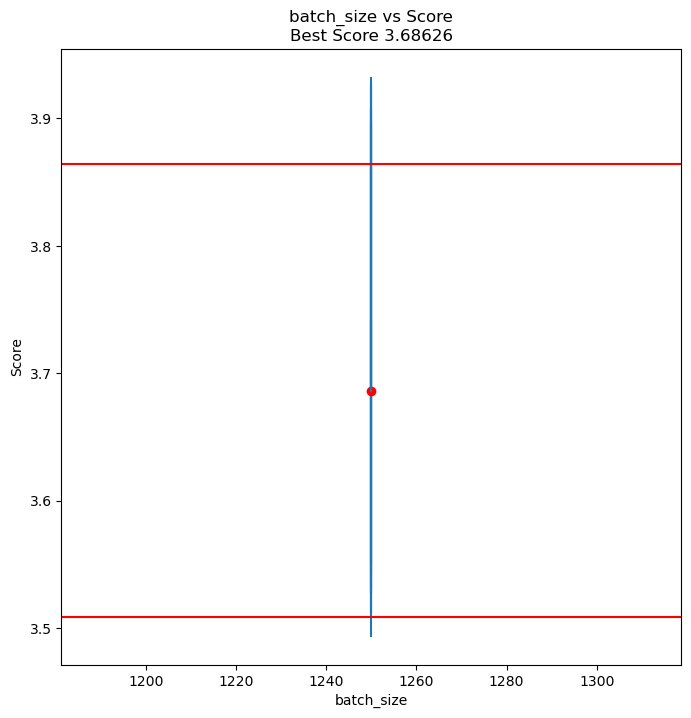

{'L1': 0.01,
 'L2': 0.001,
 'batch_size': 1250,
 'epochs': 150,
 'hidden_layers': 2,
 'optimizer': 'Adam',
 'p': 0.4}

In [134]:
optimizers = ['Adam']
epochs = [150]
batch_size = [1250]
hidden_layers = [1, 2]
p = [0.4, 0.5]
L1 = [1e-2, 1e-3]
L2 = [1e-2, 1e-3]

param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batch_size, L1 = L1, L2 = L2, hidden_layers = hidden_layers, p = p)

grid = GridSearchCV(estimator=Keras_MLP, param_grid=param_grid, cv=5,
                   scoring='neg_root_mean_squared_error')
grid_result = grid.fit(X=X_train, y=y_train)

GridSearch_table_plot(grid_result, "batch_size", negative=True, display_all_params=False)
grid_result.best_params_

## Assessing convergence

The plot shows the training loss to asses the convergence of the training algorithm. It is generated defining the history object as the fitted keras model. The neural network has converged since the training loss stabilizes around a specific value.

In [135]:
Keras_MLP_convergence = Neural_model(L1 = 1e-2, L2 = 1e-3, hidden_layers = 2, p = 0.4)

history = Keras_MLP_convergence.fit(
    x = X_train,
    y = y_train,
    epochs = 150,
    batch_size = 1250,
)

Epoch 1/150
17/17 [==============================] - 0s 3ms/step - loss: 53.6344 - root_mean_squared_error: 5.3039
Epoch 2/150
17/17 [==============================] - 0s 3ms/step - loss: 43.7664 - root_mean_squared_error: 4.4588
Epoch 3/150
17/17 [==============================] - 0s 3ms/step - loss: 40.1027 - root_mean_squared_error: 4.2527
Epoch 4/150
17/17 [==============================] - 0s 3ms/step - loss: 37.6113 - root_mean_squared_error: 4.1839
Epoch 5/150
17/17 [==============================] - 0s 3ms/step - loss: 35.4468 - root_mean_squared_error: 4.1467
Epoch 6/150
17/17 [==============================] - 0s 3ms/step - loss: 33.1885 - root_mean_squared_error: 4.0865
Epoch 7/150
17/17 [==============================] - 0s 3ms/step - loss: 31.4532 - root_mean_squared_error: 4.0727
Epoch 8/150
17/17 [==============================] - 0s 3ms/step - loss: 29.9671 - root_mean_squared_error: 4.0722
Epoch 9/150
17/17 [==============================] - 0s 3ms/step - loss: 28.7068

17/17 [==============================] - 0s 3ms/step - loss: 16.3938 - root_mean_squared_error: 3.8690
Epoch 142/150
17/17 [==============================] - 0s 3ms/step - loss: 16.0895 - root_mean_squared_error: 3.8315
Epoch 143/150
17/17 [==============================] - 0s 3ms/step - loss: 16.5764 - root_mean_squared_error: 3.8930
Epoch 144/150
17/17 [==============================] - 0s 3ms/step - loss: 16.3708 - root_mean_squared_error: 3.8648
Epoch 145/150
17/17 [==============================] - 0s 3ms/step - loss: 16.2969 - root_mean_squared_error: 3.8562
Epoch 146/150
17/17 [==============================] - 0s 3ms/step - loss: 16.4788 - root_mean_squared_error: 3.8802
Epoch 147/150
17/17 [==============================] - 0s 3ms/step - loss: 16.3772 - root_mean_squared_error: 3.8685
Epoch 148/150
17/17 [==============================] - 0s 3ms/step - loss: 16.5008 - root_mean_squared_error: 3.8839
Epoch 149/150
17/17 [==============================] - 0s 3ms/step - loss: 16.

dict_keys(['loss', 'root_mean_squared_error'])


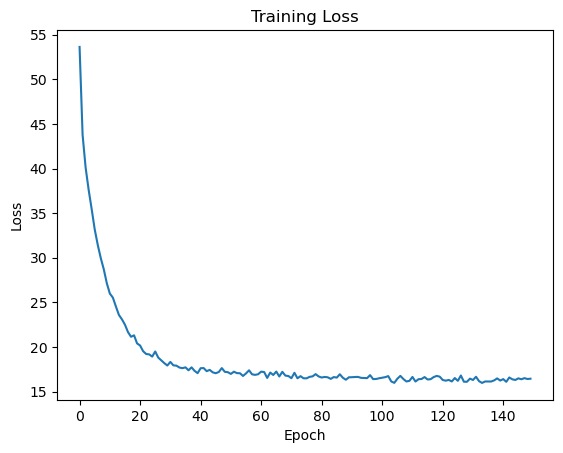

In [136]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

The in-sample predictions and in-sample Root Mean Squared Error are computed:

In [137]:
in_sample_MLP = Keras_MLP_convergence.predict(X_train)

rmse = mean_squared_error(y_train, in_sample_MLP, squared=False)
rmse

653/653 [==============================] - 0s 262us/step


3.6764740361727184

Also the out-sample predictions are created:

In [138]:
out_sample_MLP = Keras_MLP_convergence.predict(X_test)

164/164 [==============================] - 0s 281us/step


## Interpretation of the neural network

### Using LIME

LIME, which stands for Local Interpretable Model-Agnostic Explanation, operates under the assumption that despite a model's complexity, it behaves linearly within a local context. When explaining a specific target observation, LIME constructs a local linear model. It achieves this by assigning weights to observations based on their proximity (or similarity measured through a kernel function) to the target observation.

In [139]:
explainerlime = lime.lime_tabular.LimeTabularExplainer(
    training_data= X_train.values,
    mode='regression',
    training_labels=y_train,
    feature_names=X_train.columns.values, 
    random_state= SEED)

The following code aims to generate a prediction interpretation for the observation with index 1 from the testing set:

In [140]:
exp = explainerlime.explain_instance(
    data_row = X_test.iloc[1].values,
    predict_fn = Keras_MLP_convergence.predict)

157/157 [==============================] - 0s 859us/step


In [141]:
exp.show_in_notebook()

The model has predicted a length of stay in the UCI of 8.62 days for the first patient of the testing dataset. This prediction was mainly based on features related to the diagnosis and the information from comorbidities, especially the statistics maximum, mean, standard deviation and the 10th and 90th quantile computed from the metadata. Instead, features as the number of comorbidities of said patient or *FIRST_CAREUNIT_CSRU* decreases its lenght of the stay but they are outweighted by all the other features which cause that this pateint has a length of stay much higher than the average computed in the training dataset, which was 3.70 days.

### Using SHAP

SHAP (SHapley Additive exPlanation) values represent the contribution of each feature to the output prediction, showcasing how much each feature pushes the model output from the expected prediction.

The SHAP function used for neural network is *shap.DeepExplainer*. However, due to error arisen due to the version of TensorFlow, this section will use instead the general function *shap.KernelExplainer*. 

Since *shap.KernelExplainer* is much slower, for the aim of computationally reducing the time, we will use a selection of 100 samples from the dataset to represent “typical” feature values, and then use 500 perterbation samples to estimate the SHAP values for a given prediction.

Focusing on the training set, the highest average impact on model input magnitude corresponds to the features *number_comorbidities*, *min*, *max*, *mean*, *sum*, *q90* and *std*, among others. All these features refers to statistics from the metadata, which is expected by the increase of the predictive performance after adding them into the preprocessing.

4/4 [==============================] - 0s 648us/step


  0%|          | 0/100 [00:00<?, ?it/s]

1563/1563 [==============================] - 0s 276us/step


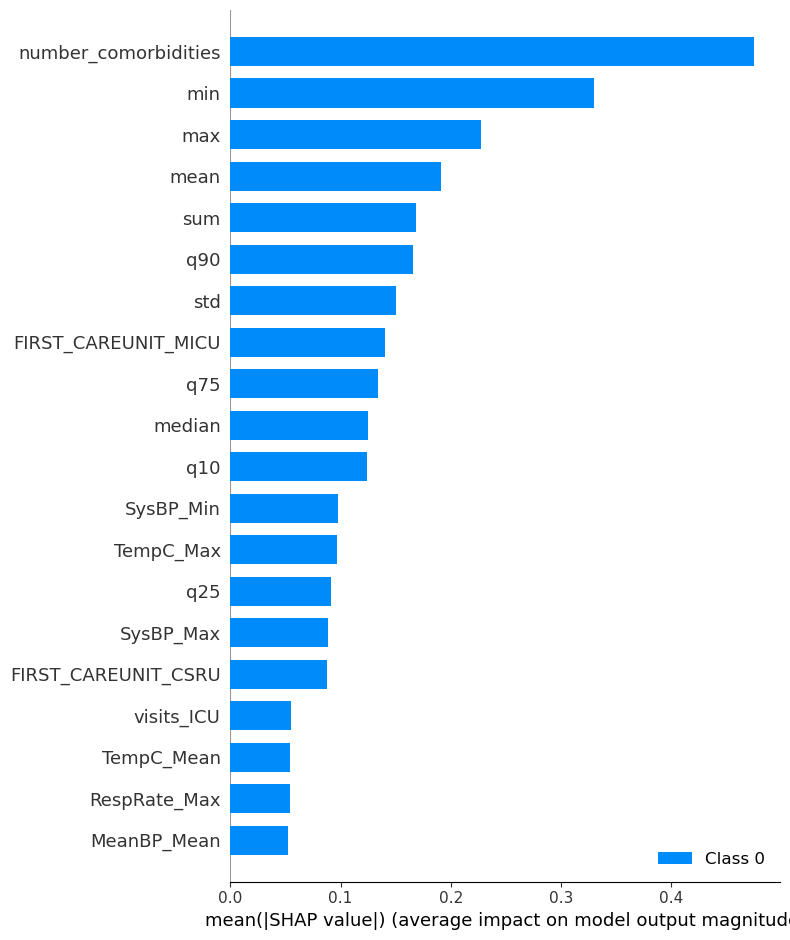

In [142]:
explainer = shap.KernelExplainer(Keras_MLP_convergence.predict, X_train.iloc[:100,:])
shap_values = explainer.shap_values(X_train.iloc[:100,:], nsamples=500)
shap.initjs()

shap.summary_plot(shap_values, X_train.iloc[:100,:], plot_type="bar", feature_names=X_train.columns)

Regarding testing set, it is done a global explanation considering the 100 selected samples and a local prediction interpretation for the observation with index 1 from the testing set:

Focusing on the global explanation, the features that attain the highest average impact on model input magnitude are similar than in the training dataset.

4/4 [==============================] - 0s 708us/step


  0%|          | 0/100 [00:00<?, ?it/s]

1563/1563 [==============================] - 0s 288us/step


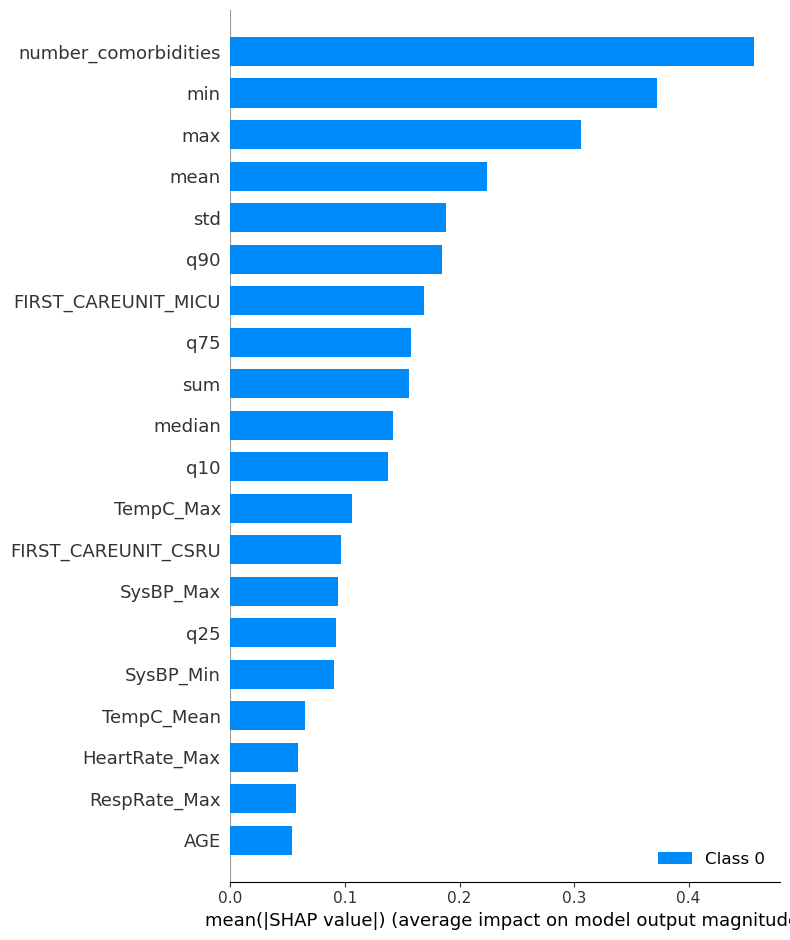

In [143]:
explainer = shap.KernelExplainer(Keras_MLP_convergence.predict, X_train.iloc[:100,:])
shap_values = explainer.shap_values(X_test.iloc[:100,:], nsamples=500)
shap.initjs()

shap.summary_plot(shap_values, X_test.iloc[:100,:], plot_type="bar")

Now we focus on the local explanation for the observation with index 1 from the testing set. The force plot below shows how each feature contributes to the model output from the base value (the average model output over the passed dataset) to the model output. Features increasing the prediction are shown in red, for example *median*, *mean* and *max*. Features decreasing the prediction are in blue and includes features such as *number_of_comorbidities*.

In [144]:
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values[0][1], X_test.iloc[1])

In [145]:
pd.DataFrame(zip(
    X_train.columns,
    X_train.mean(),
    X_test.iloc[1, :],
    [shap_values[0][1][i] for i in range(len(X_train.columns))]
), columns=['feature', 'avg_value', 'mytarget_value', 'shap_value'])

feature     avg_value  mytarget_value  shap_value
0                HeartRate_Min -4.108923e-03        1.433890    0.210490
1                HeartRate_Max -2.538728e-03        1.896352    0.191131
2               HeartRate_Mean -3.519251e-03        1.951235   -0.156101
3                    SysBP_Min  4.762393e-03       -1.026895    0.068631
4                    SysBP_Max -1.005614e-03       -0.322282   -0.096303
..                         ...           ...             ...         ...
57             RELIGION_JEWISH -1.564997e-17       -0.310827   -0.044669
58      RELIGION_NOT SPECIFIED -5.562544e-17        1.693820   -0.021008
59              RELIGION_OTHER  6.072869e-17       -0.299957    0.000000
60  RELIGION_PROTESTANT QUAKER  2.857821e-17       -0.389655    0.000000
61       RELIGION_UNOBTAINABLE  1.445921e-17       -0.279667   -0.002835

[62 rows x 4 columns]

The following plot is a force plot enable to have a final visualization for the selected test dataset:

In [146]:
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[:100,:])

Finally, the plot shows a summary of effect of each feature on final result.

  0%|          | 0/100 [00:00<?, ?it/s]

1563/1563 [==============================] - 0s 290us/step


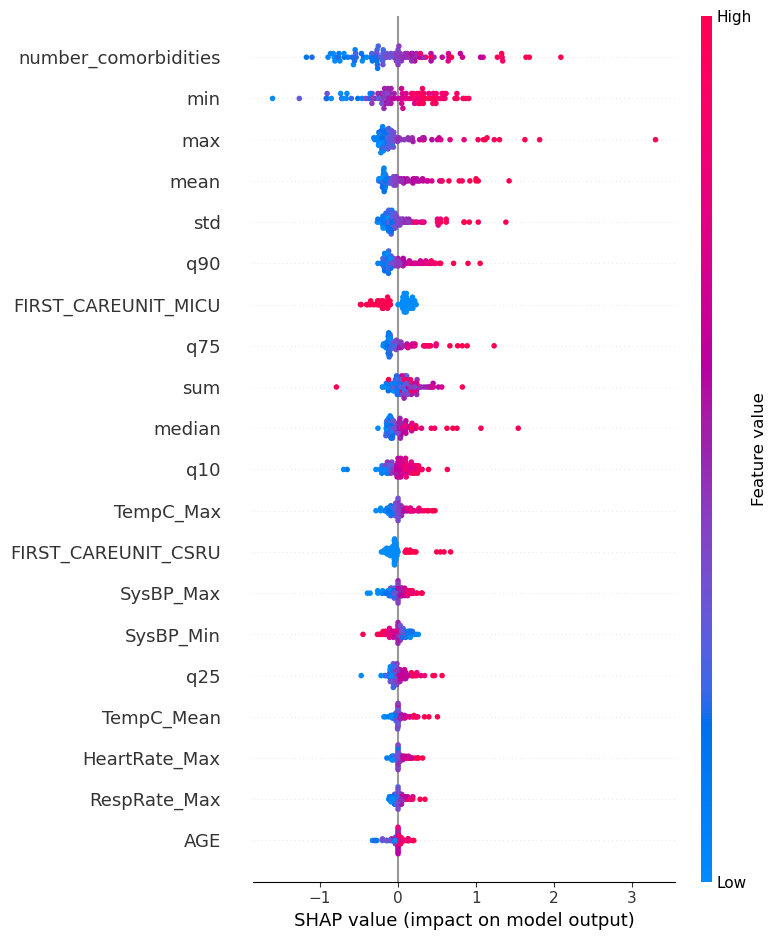

In [147]:
shap_values = explainer.shap_values(X_test.iloc[:100,:], nsamples=500)
shap.summary_plot(shap_values[0], X_test.iloc[:100,:])

The vertical axis indicates the feature names in order of importance from top to bottom. The horizontal axis represents the SHAP value, which indicates the impact on the model output.

For example, for the case of *median*, it is mostly high with a positive SHAP value, which indicates that a higher value of the statistics *median* increases the length of stay. As another example, a low value of *number_of_comorbidities* decreases the length of stay.

### Kaggle Predictions Submissions

The best predictions are obtained by the XGBoost, therefore are the ones used as the final prediction:

In [148]:
test_predictions_submit = pd.DataFrame({"icustay_id": data_test["icustay_id"], "LOS": XGB_outsample_pred})
test_predictions_submit.to_csv("test_predictions_submit.csv", index = False)

The file containing the output predictions has the following form:

In [149]:
test_predictions_submit.head()

icustay_id        LOS
0      208169   3.729846
1      251754   8.336131
2      242171   2.815330
3      263035   3.740517
4      279388  11.434708